In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

# External library imports
import datetime
import torch
import torch.nn as nn
import numpy as np
import random
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, random_split
import json
import os
import matplotlib.pyplot as plt

# internal library imports
from dataset import DebrisStatePairsDataset
from model import CNN, UNet
from train import TrainerPairs, CustomDebrisLoss
from util.setting_utils import set_seed


In [2]:
# Set the random seed for multiple libraries to ensure repeatability

# set_seed(42)

In [3]:
def read_losses(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    # Extract the subfolder name as the series name
    series_name = os.path.basename(os.path.dirname(file_path))
    return series_name, data['training_losses'], data['validation_losses']

def plot_multiple_losses(files, log_y=False):
    plt.figure(figsize=(12, 6))
    
    for file_path in files:
        series_name, training_losses, validation_losses = read_losses(file_path)
        epochs = range(1, len(training_losses) + 1)
        

        # plt.plot(epochs, training_losses, 'o-', label=f'{series_name} Training', linewidth=2)
        
        plt.plot(epochs, validation_losses, 'o--', label=f'{series_name} Validation', linewidth=2)

    plt.title('Training and Validation Losses for Multiple Models')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    if log_y:
        plt.yscale('log')  # Set the y-axis to logarithmic scale
    
    plt.show()

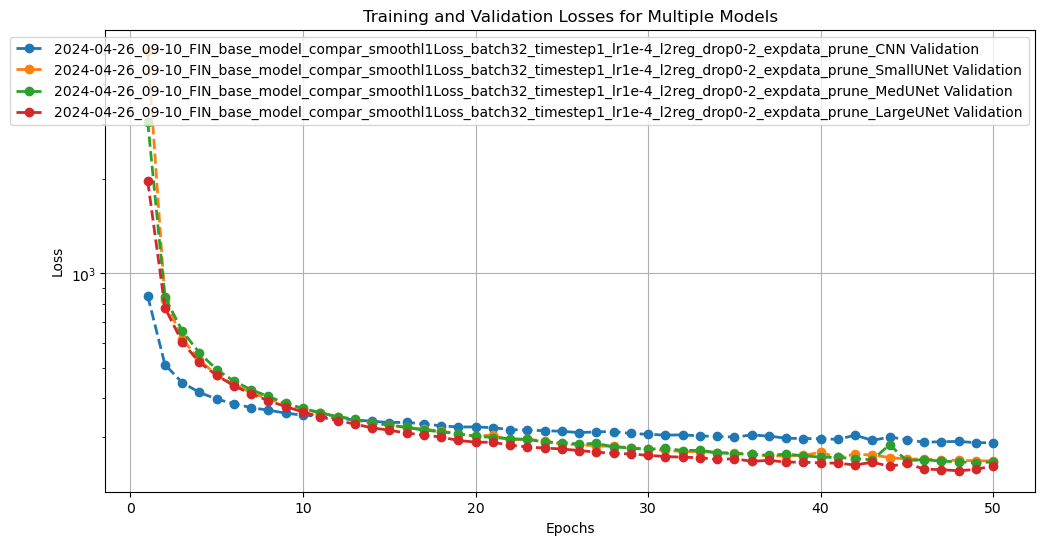

In [4]:
files = [
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_CNN/losses_epoch_50.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_SmallUNet/losses_epoch_50.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet/losses_epoch_50.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_LargeUNet/losses_epoch_50.json'
]

plot_multiple_losses(files, log_y=True)

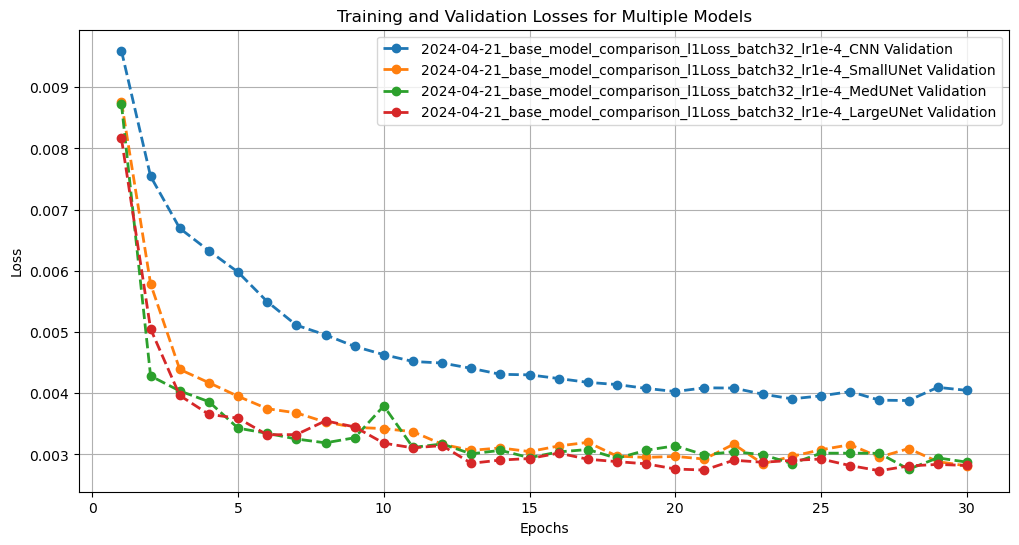

In [5]:
files = [
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_CNN/losses_epoch_30.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_SmallUNet/losses_epoch_30.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_MedUNet/losses_epoch_30.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_LargeUNet/losses_epoch_30.json'
]

plot_multiple_losses(files)

In [6]:
# Parameters

root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data_experiment_prune'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 32
split_proportions = (0.7, 0.15, 0.15)
epochs = 30

in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)

In [7]:
# Data set up

# Initialize dataset with scaling
dataset = DebrisStatePairsDataset(root_dir, array_size=256, apply_scaling=True, timestep_interval=5)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)



# Dataset stats
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

Total dataset size: 3381
Train size: 2451, Validation size: 512, Test size: 418


In [8]:
# # Create an instance of each architecture
# cnn = CNN()
# small_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256])
# med_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512])
# large_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512, 1024])

# # Calculate the number of parameters for each architecture
# cnn_params = sum(p.numel() for p in cnn.parameters())
# small_unet_params = sum(p.numel() for p in small_unet.parameters())
# med_unet_params = sum(p.numel() for p in med_unet.parameters())
# large_unet_params = sum(p.numel() for p in large_unet.parameters())

# # Print the number of parameters for each architecture
# print("ComplexCNN parameters:", cnn_params)
# print("SimpleUNet parameters:", small_unet_params)
# print("LargeUNet parameters:", med_unet_params)
# print("UNet parameters:", large_unet_params)

In [9]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = CNN().to(device)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    cnn = nn.DataParallel(cnn)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
optimizer = Adam(cnn.parameters(), lr=1e-3)

cnn_trainer = TrainerPairs(cnn, optimizer, criterion, device, model_name="cnn", checkpoint_dir=checkpoint_dir)

cnn_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_CNN/model_epoch_50.pth", train_loader)

Using 2 GPUs!
Model loaded from /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_CNN/model_epoch_50.pth


In [10]:
cnn_trainer.test(test_loader)

Test Custom Loss: 0.0582
Test L1 Loss: 0.0013
Test MSE: 0.0002
Test RMSE: 0.0140
Test PSNR: 67.4268


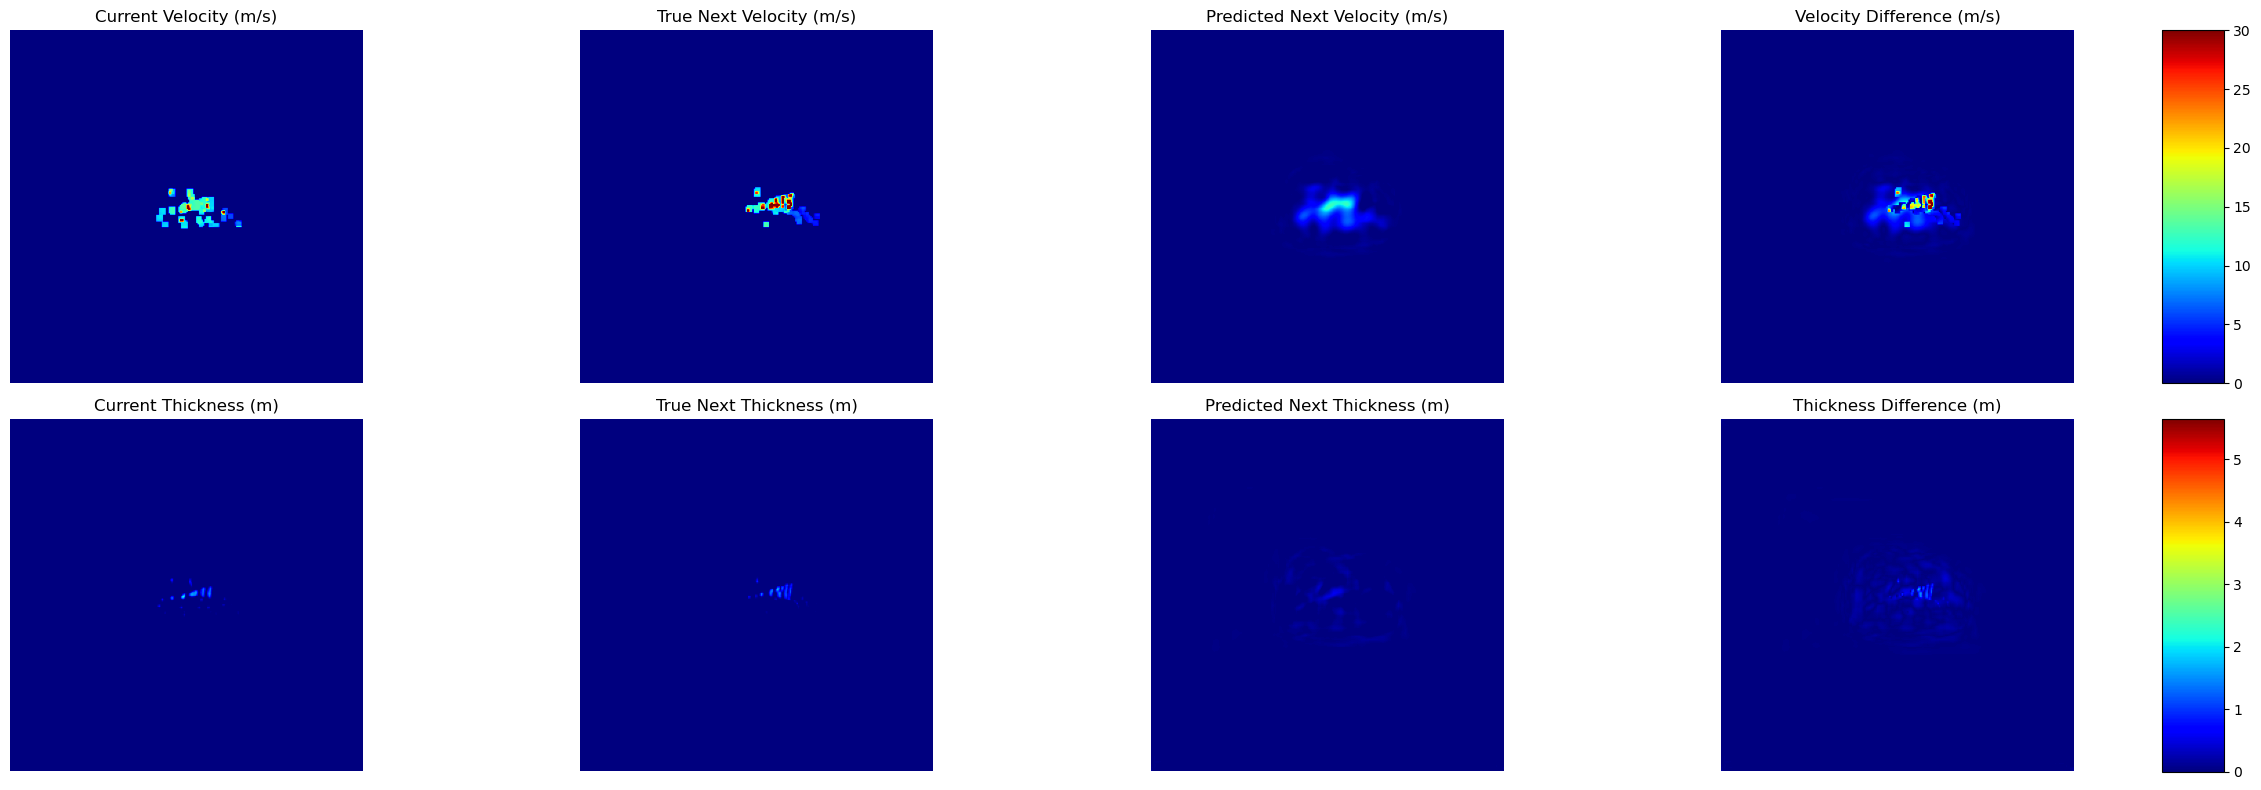

In [13]:
cnn_trainer.plot_predictions4(test_loader, num_predictions=1, show_topography=False)

In [12]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

small_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256]).to(device)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    small_unet = nn.DataParallel(small_unet)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
optimizer = Adam(cnn.parameters(), lr=1e-3)

small_unet_trainer = TrainerPairs(small_unet, optimizer, criterion, device, model_name="small_unet", checkpoint_dir=checkpoint_dir)

small_unet_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_SmallUNet/model_epoch_50.pth", train_loader)

Using 2 GPUs!
Model loaded from /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_SmallUNet/model_epoch_50.pth


In [13]:
small_unet_trainer.test(test_loader)

Test Custom Loss: 0.0589
Test L1 Loss: 0.0013
Test MSE: 0.0002
Test RMSE: 0.0141
Test PSNR: 67.3831


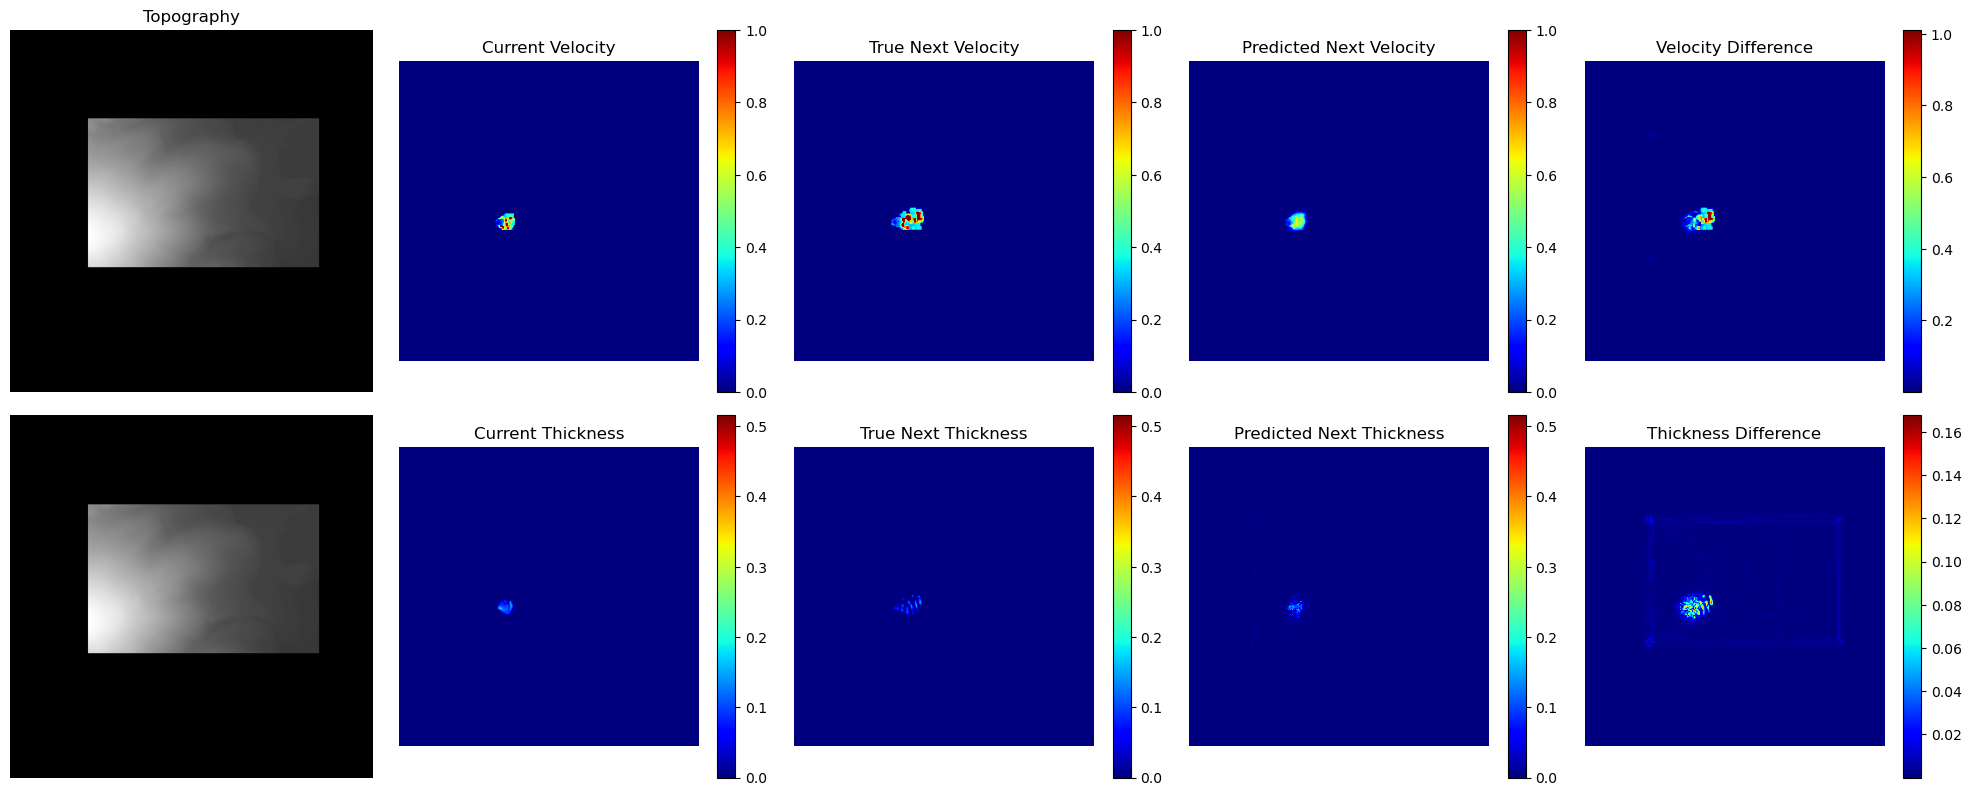

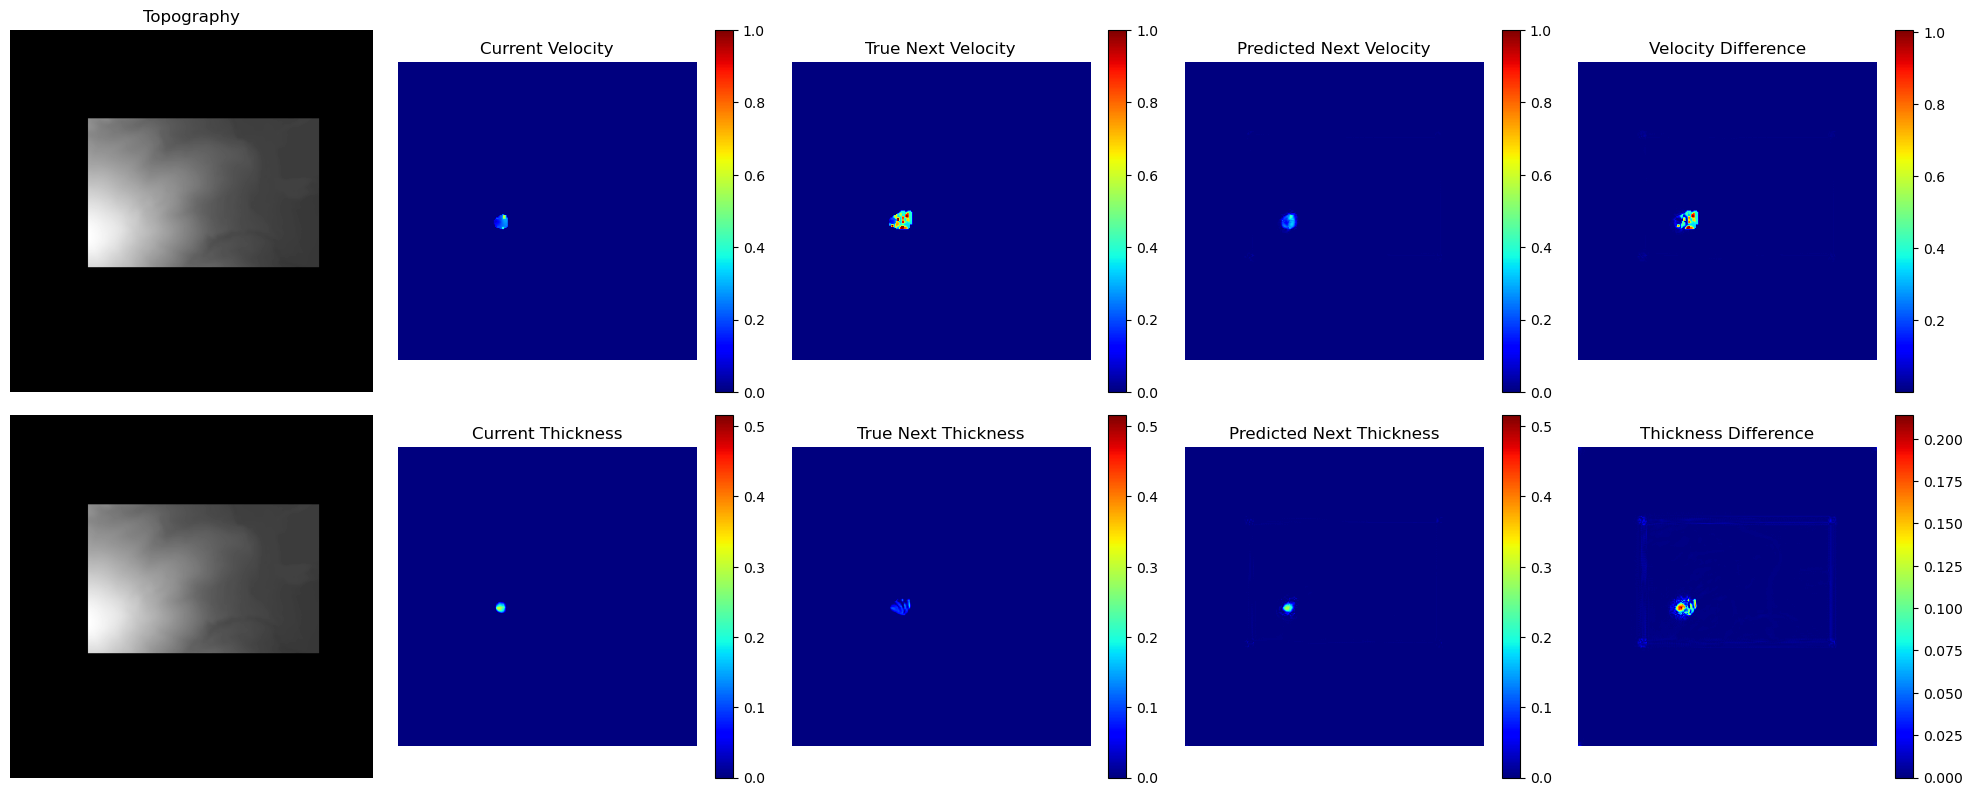

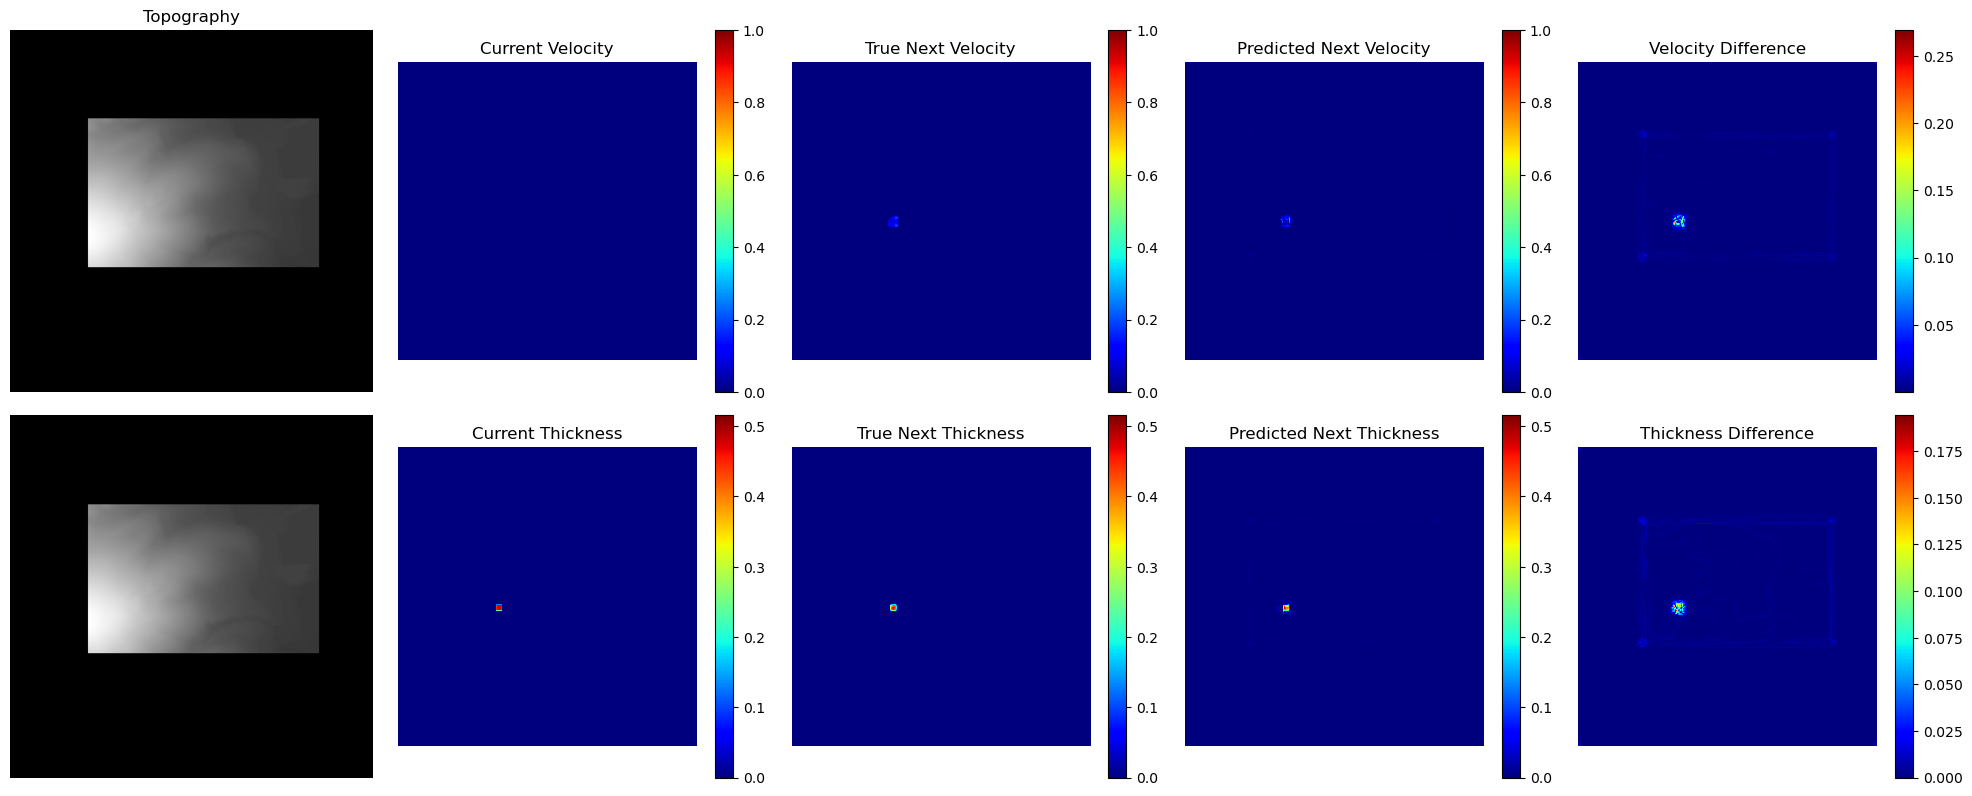

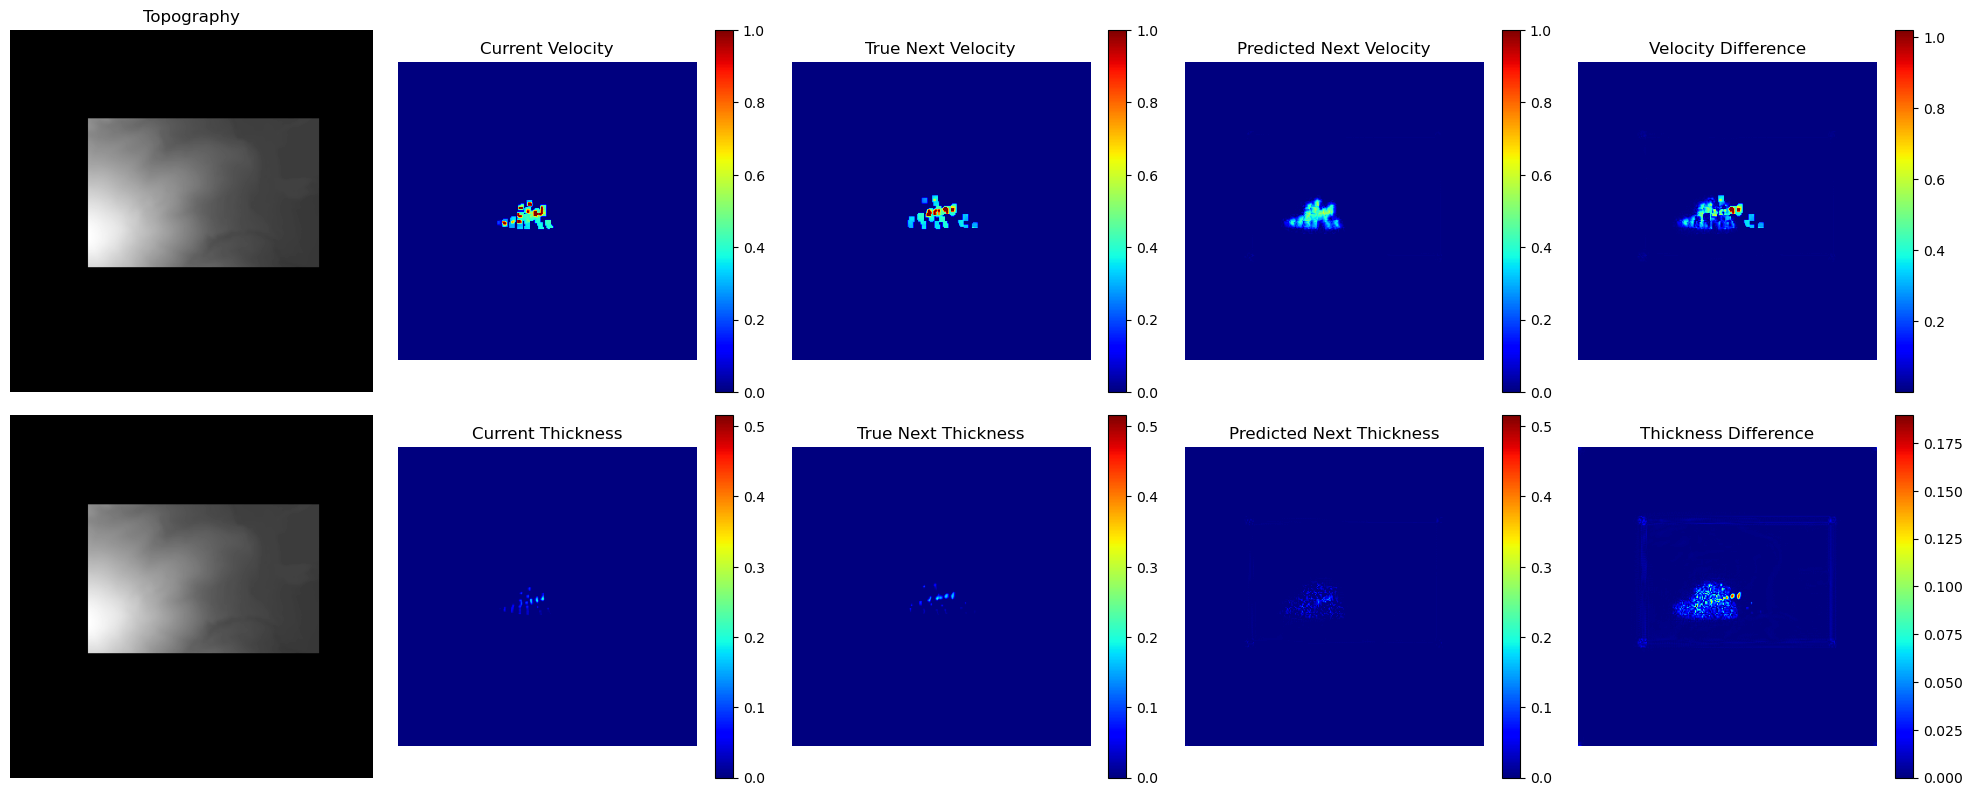

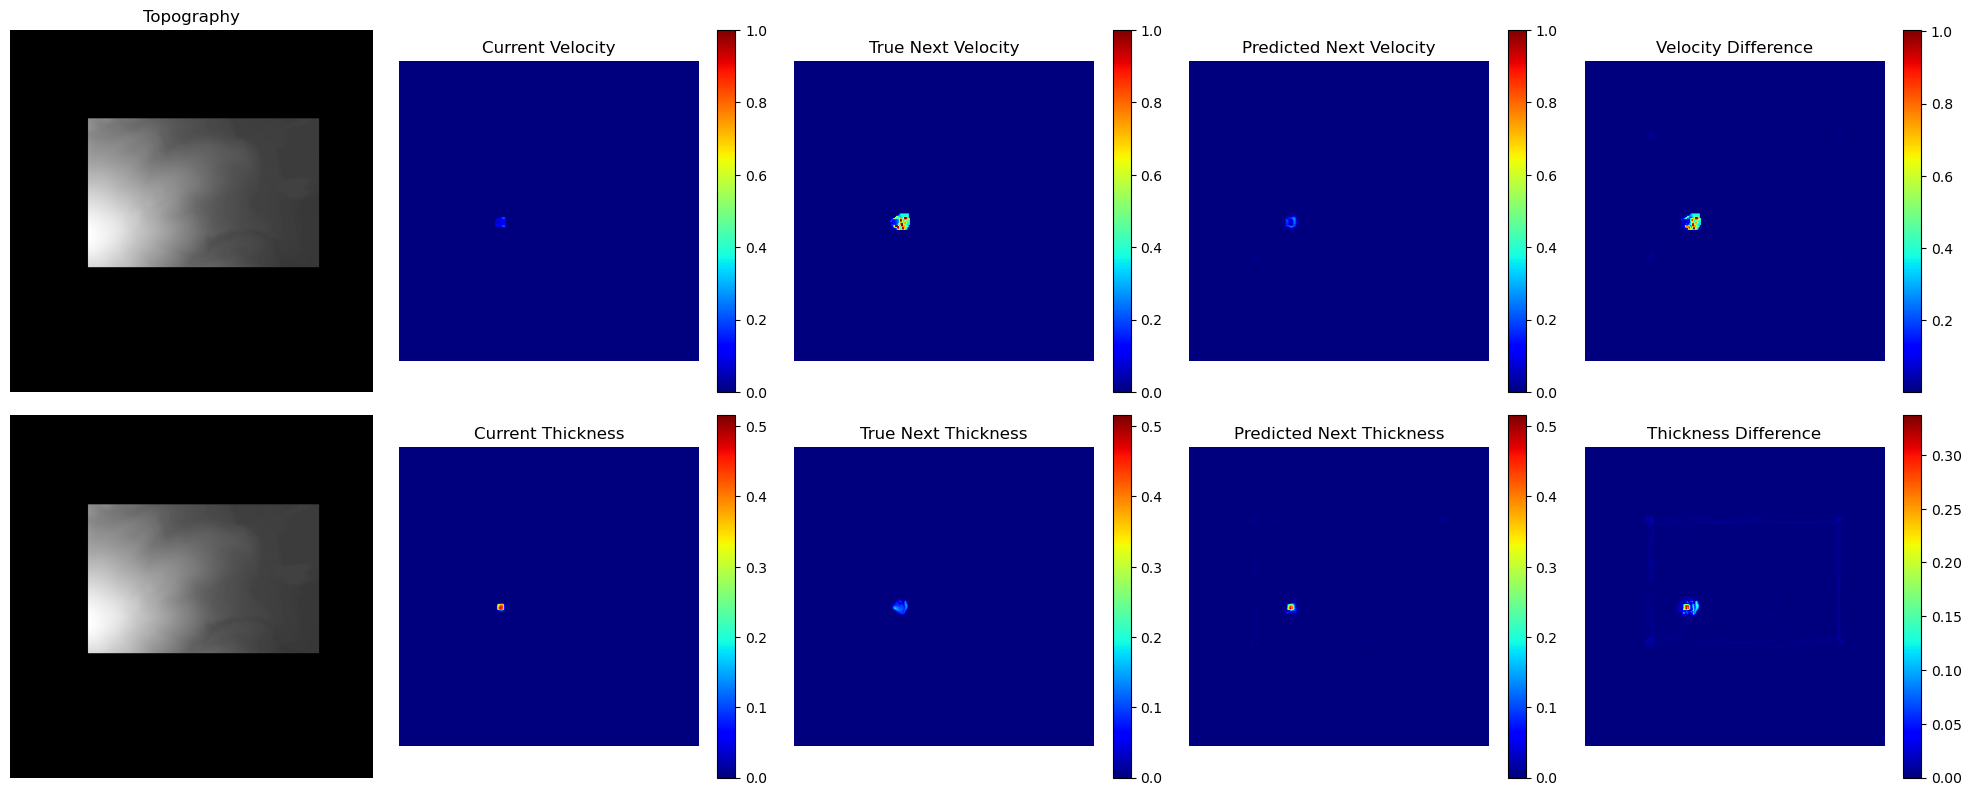

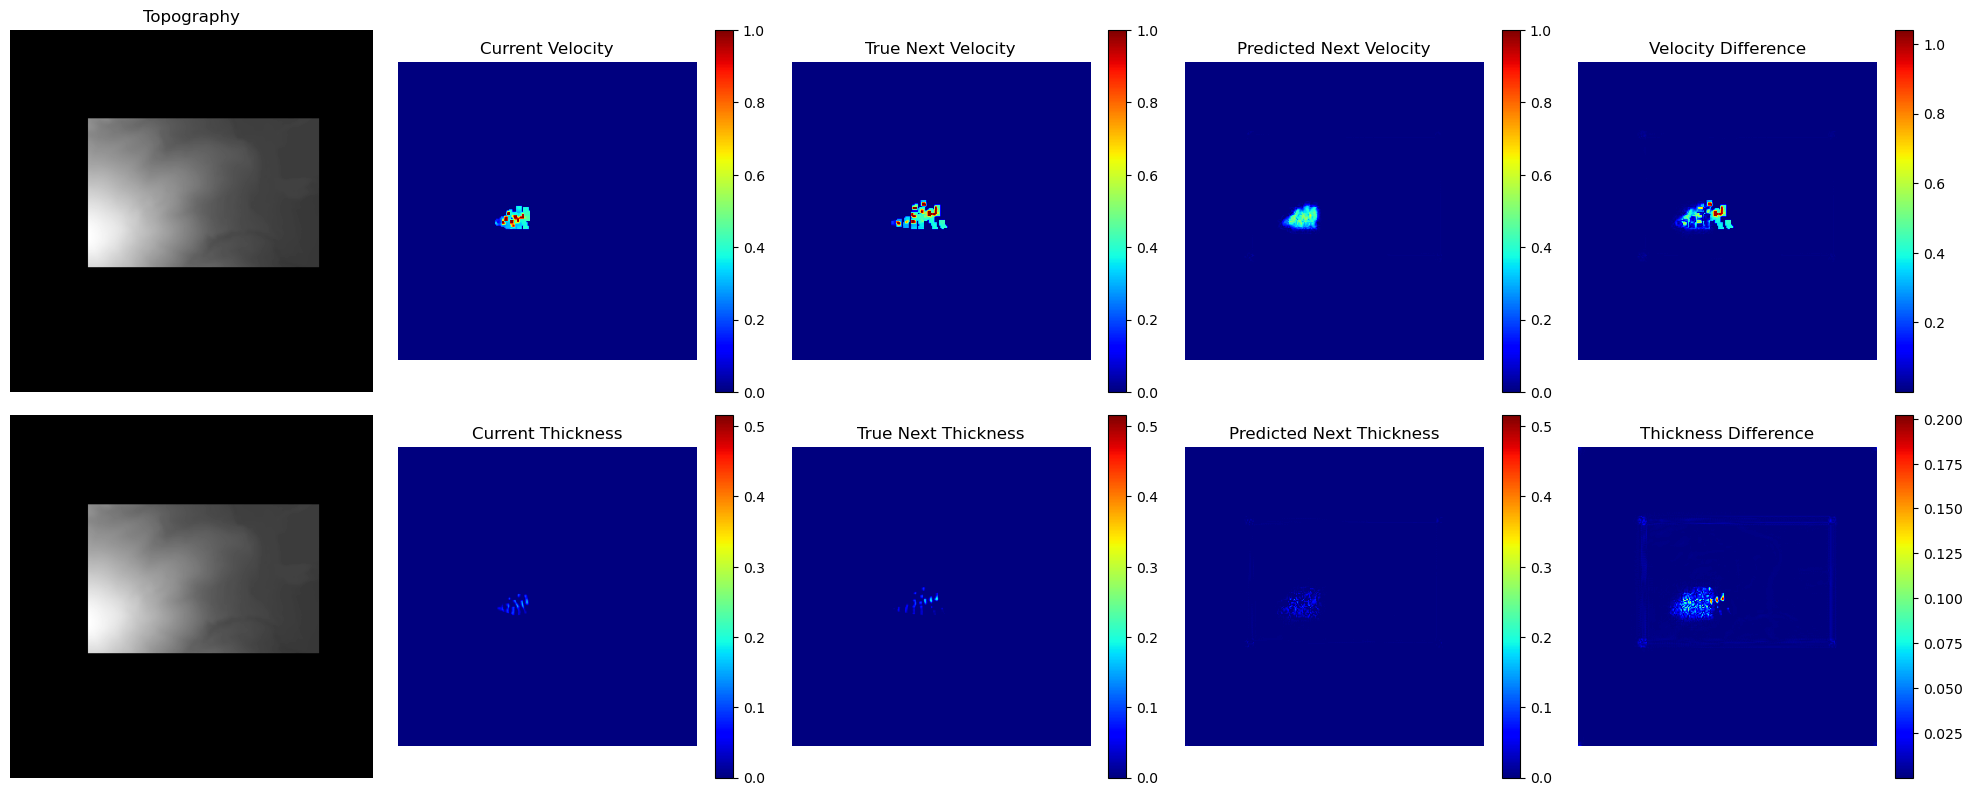

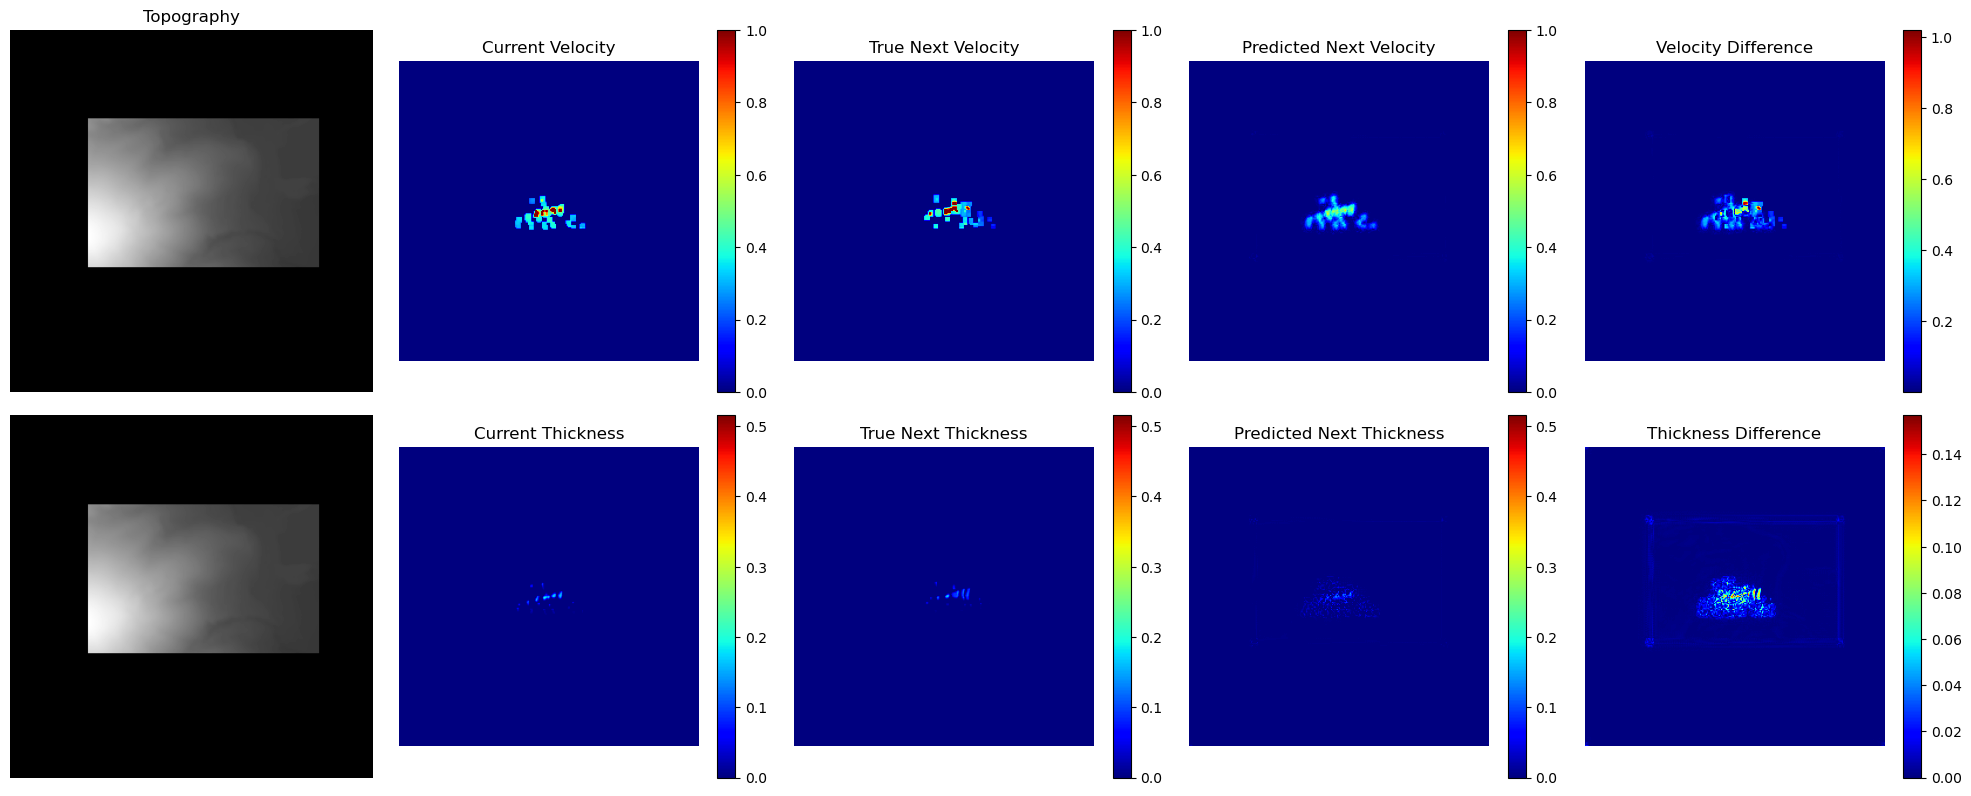

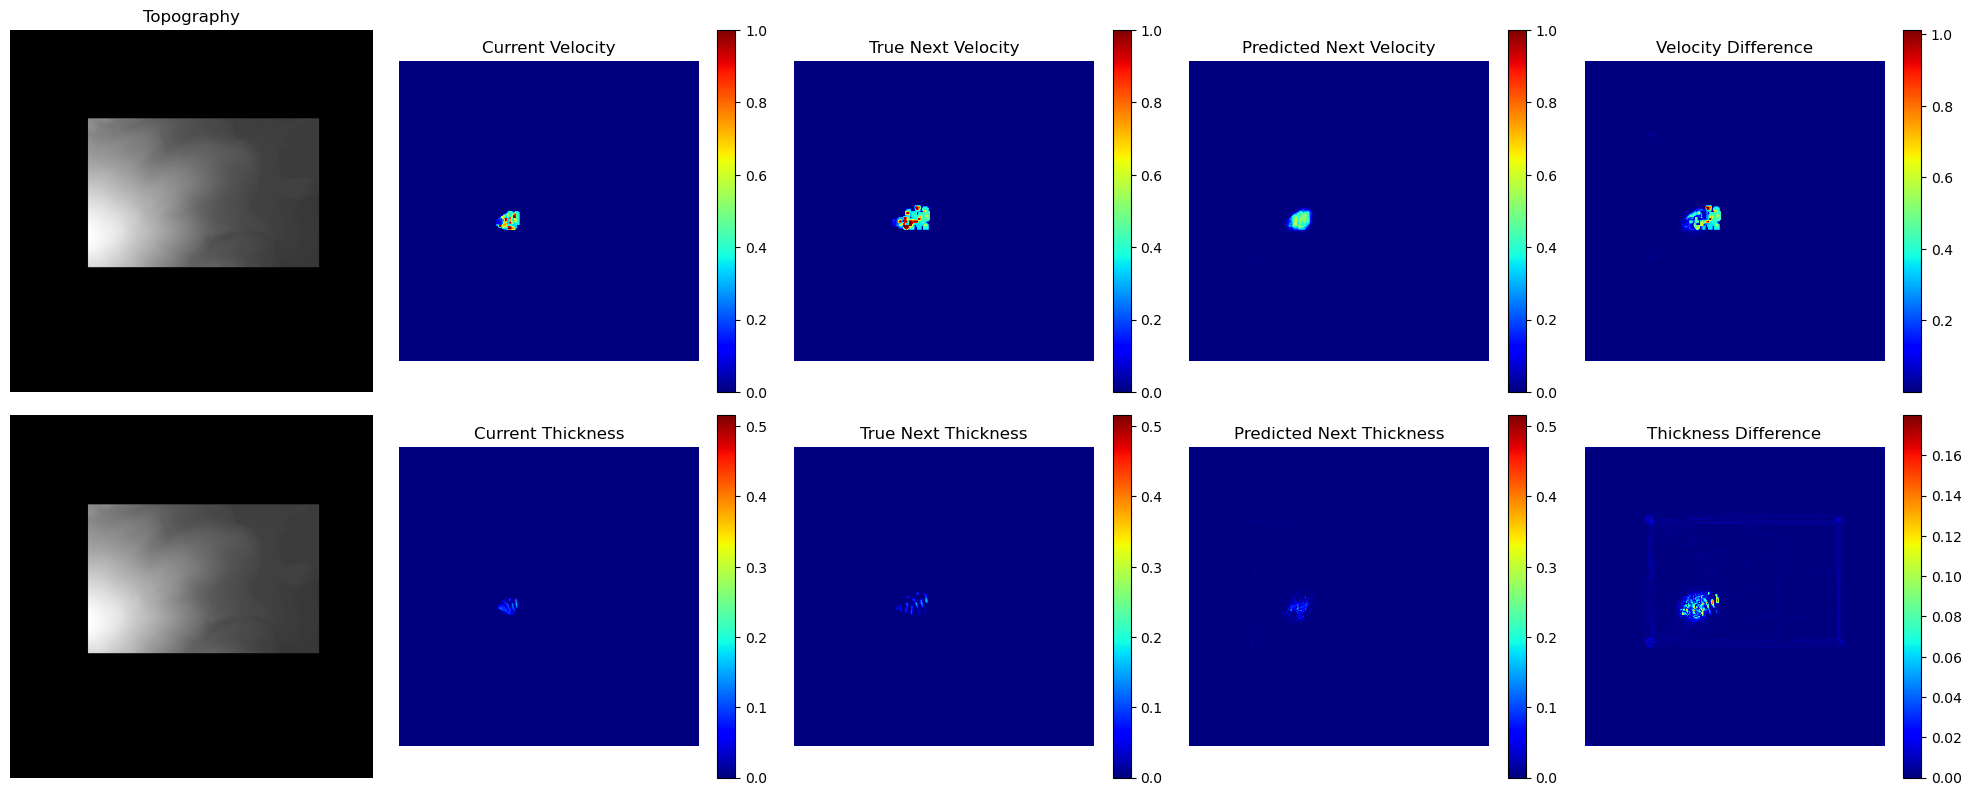

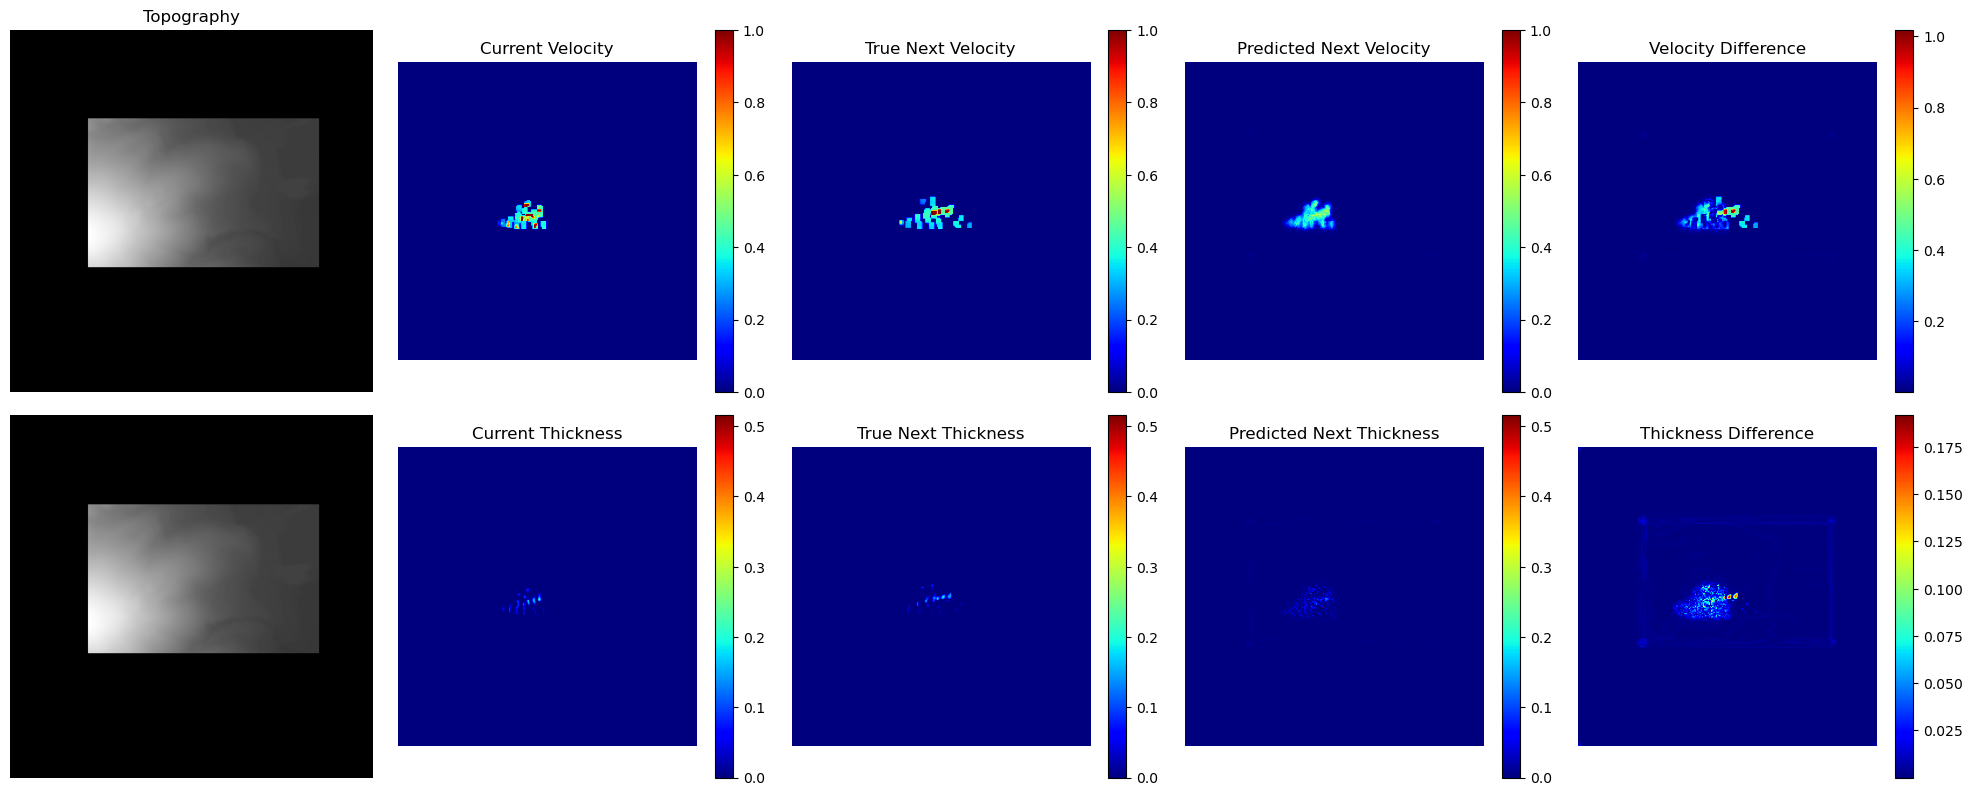

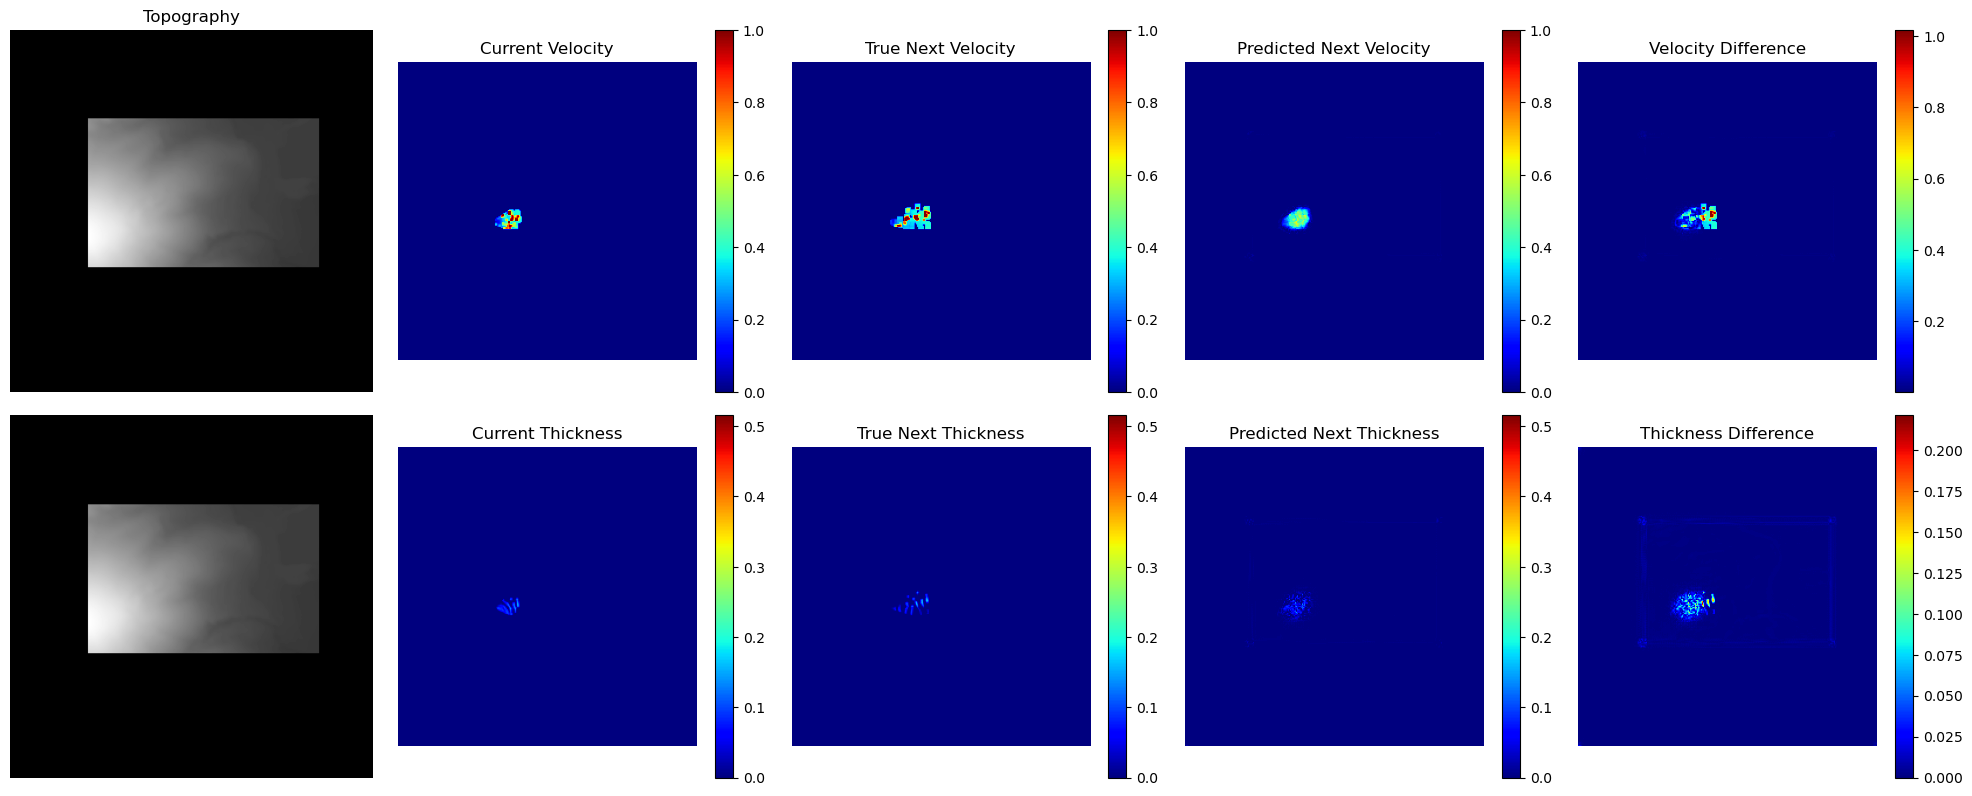

In [14]:
small_unet_trainer.plot_predictions(test_loader, num_predictions=10)

In [15]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

med_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512]).to(device)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    med_unet = nn.DataParallel(med_unet)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
optimizer = Adam(med_unet.parameters(), lr=1e-3)

med_unet_trainer = TrainerPairs(med_unet, optimizer, criterion, device, model_name="med_unet", checkpoint_dir=checkpoint_dir)

med_unet_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet/model_epoch_50.pth", train_loader)

Using 2 GPUs!
Model loaded from /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet/model_epoch_50.pth


In [16]:
med_unet_trainer.test(test_loader)

Test Custom Loss: 0.0597
Test L1 Loss: 0.0012
Test MSE: 0.0002
Test RMSE: 0.0143
Test PSNR: 67.2843


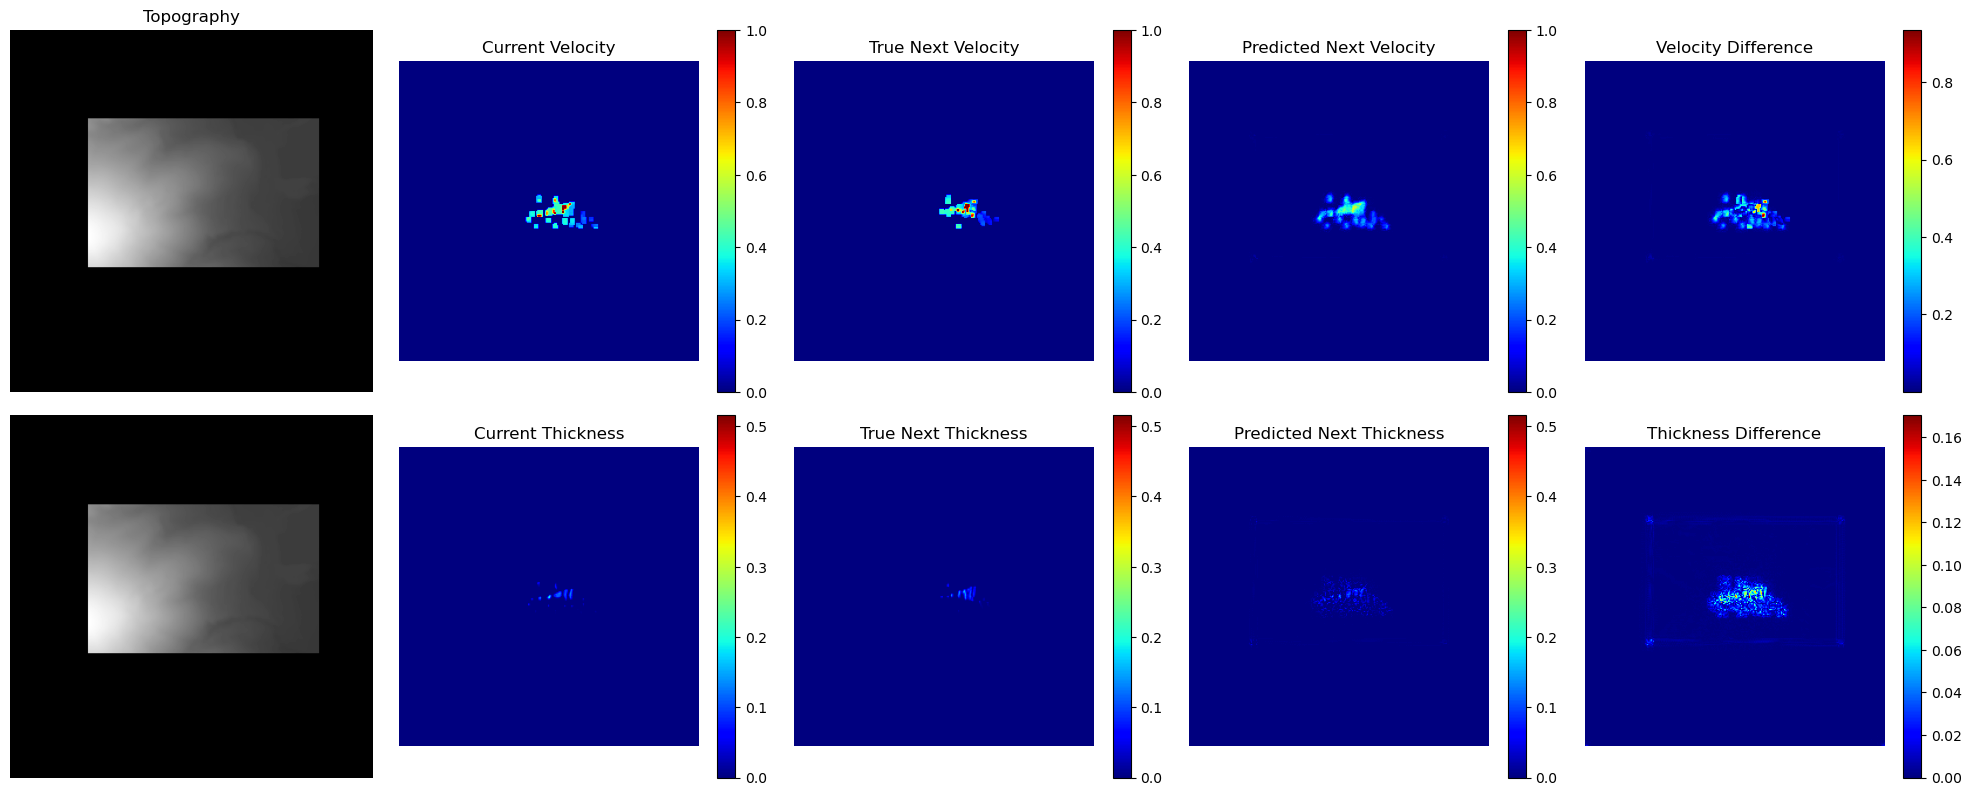

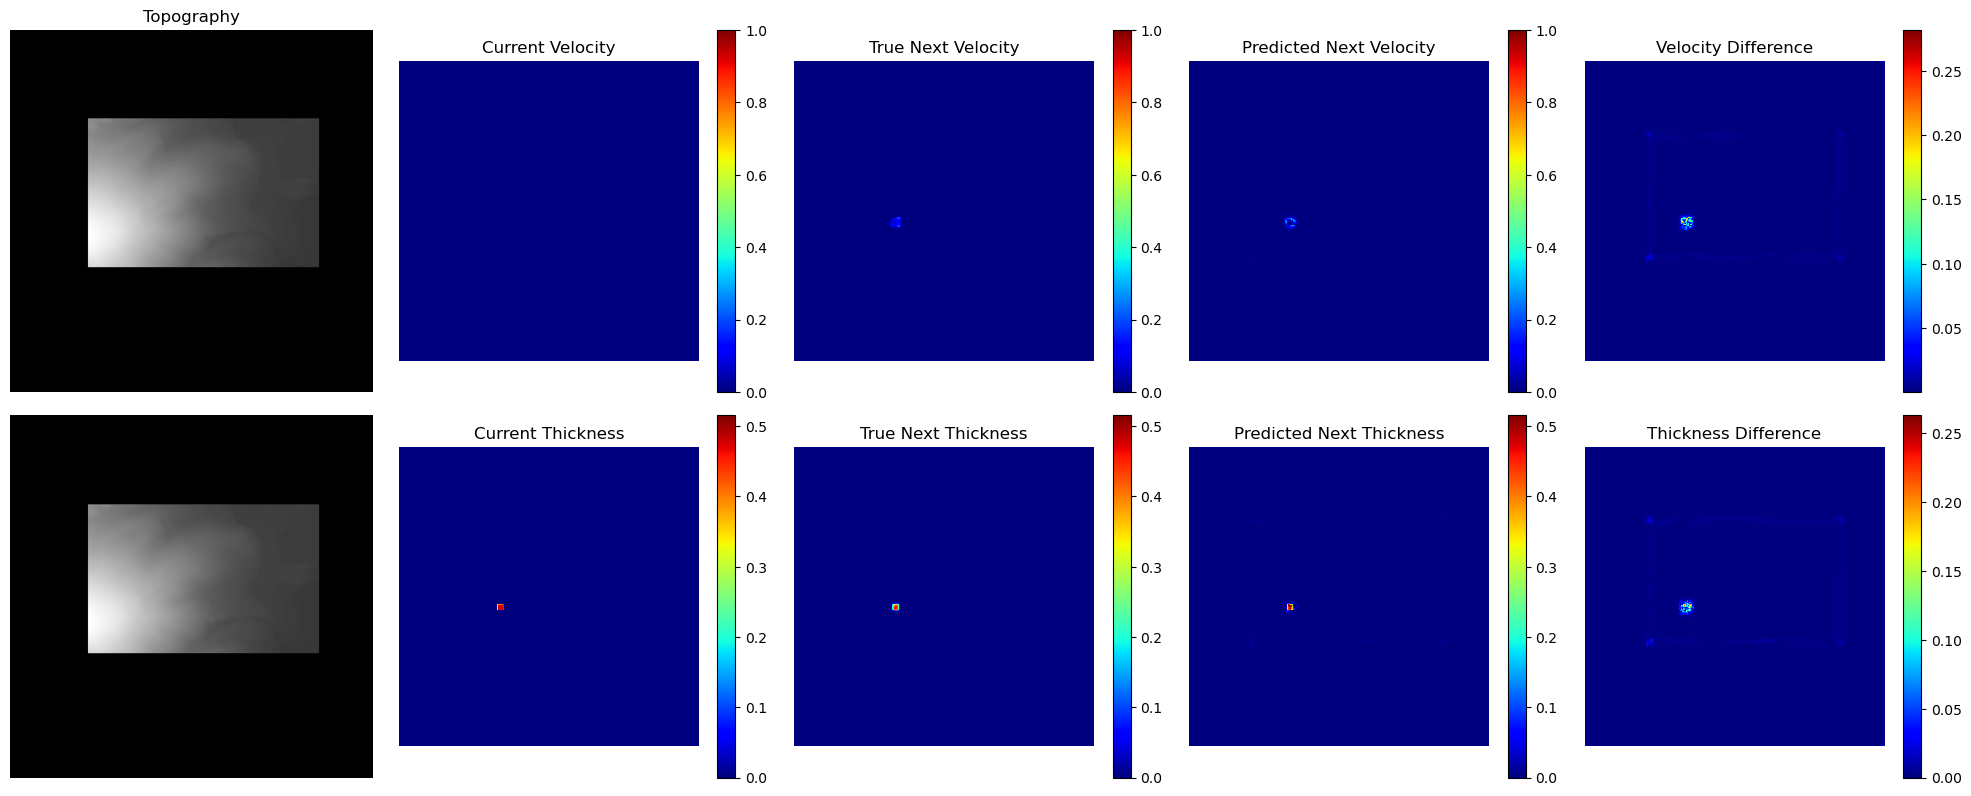

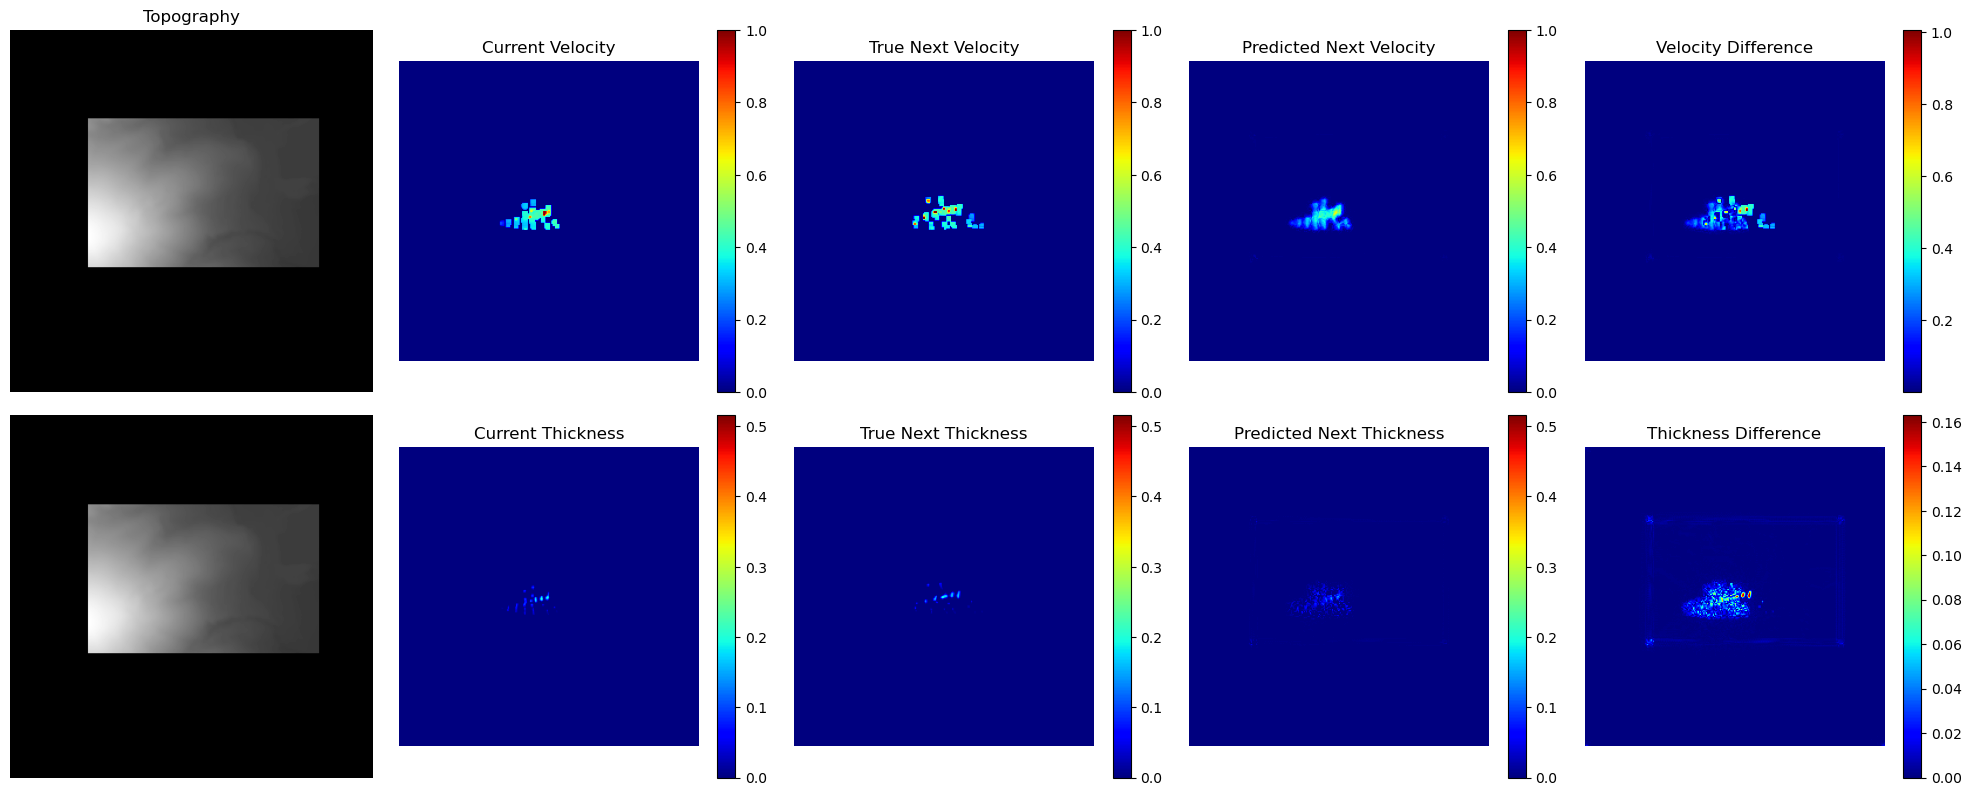

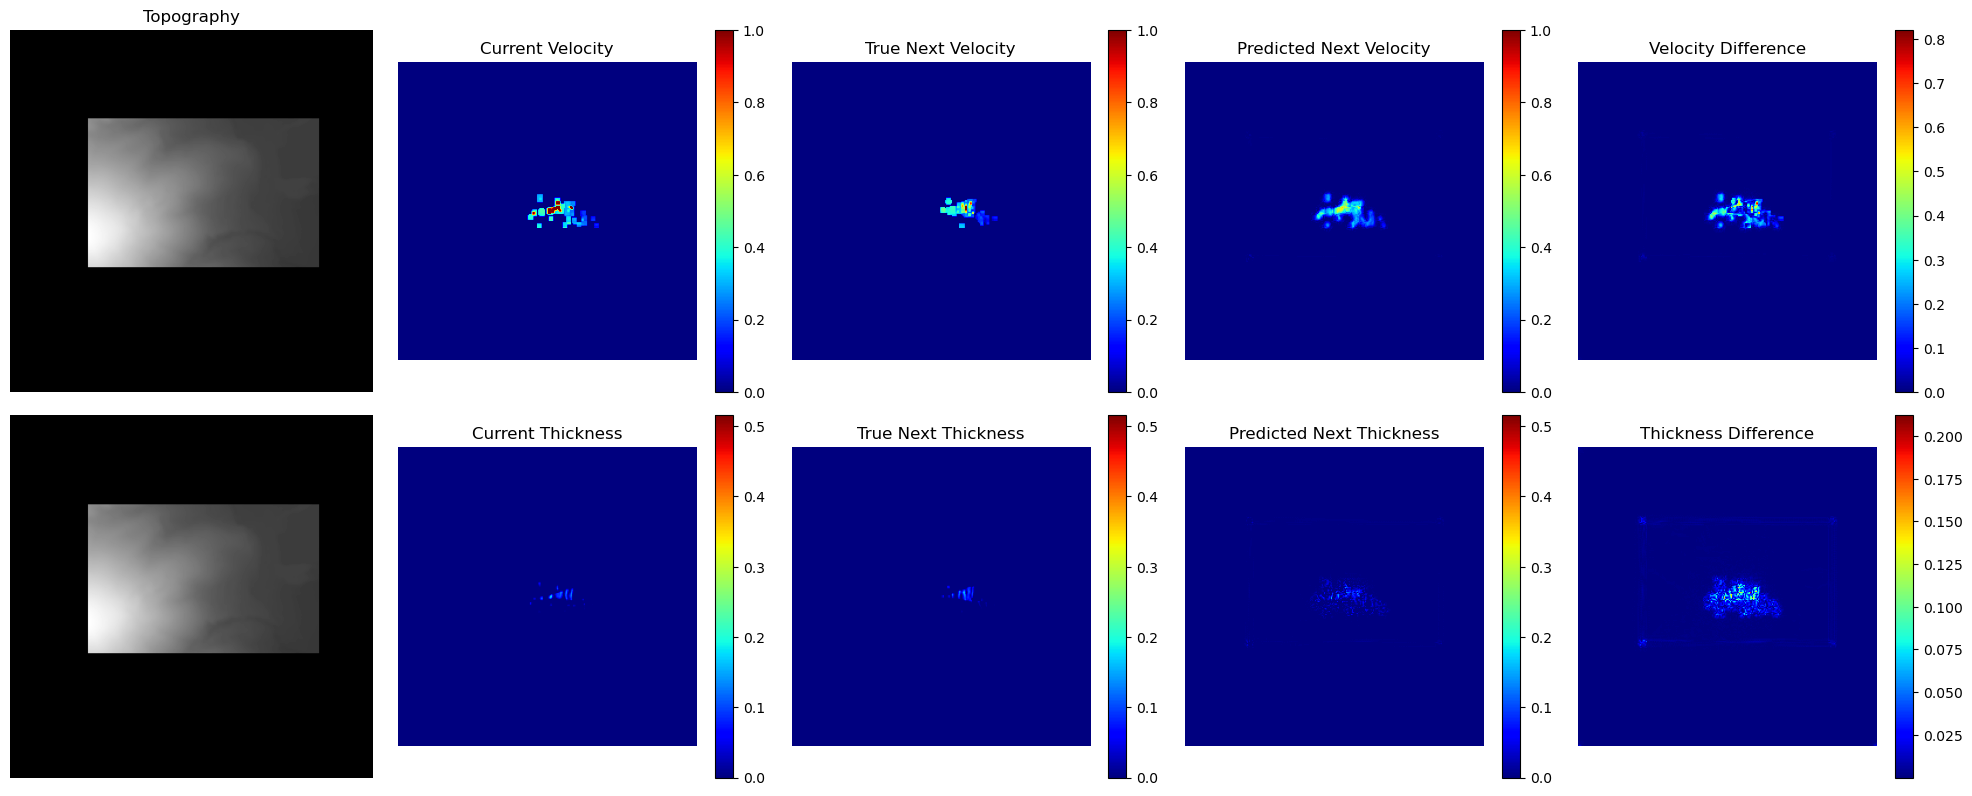

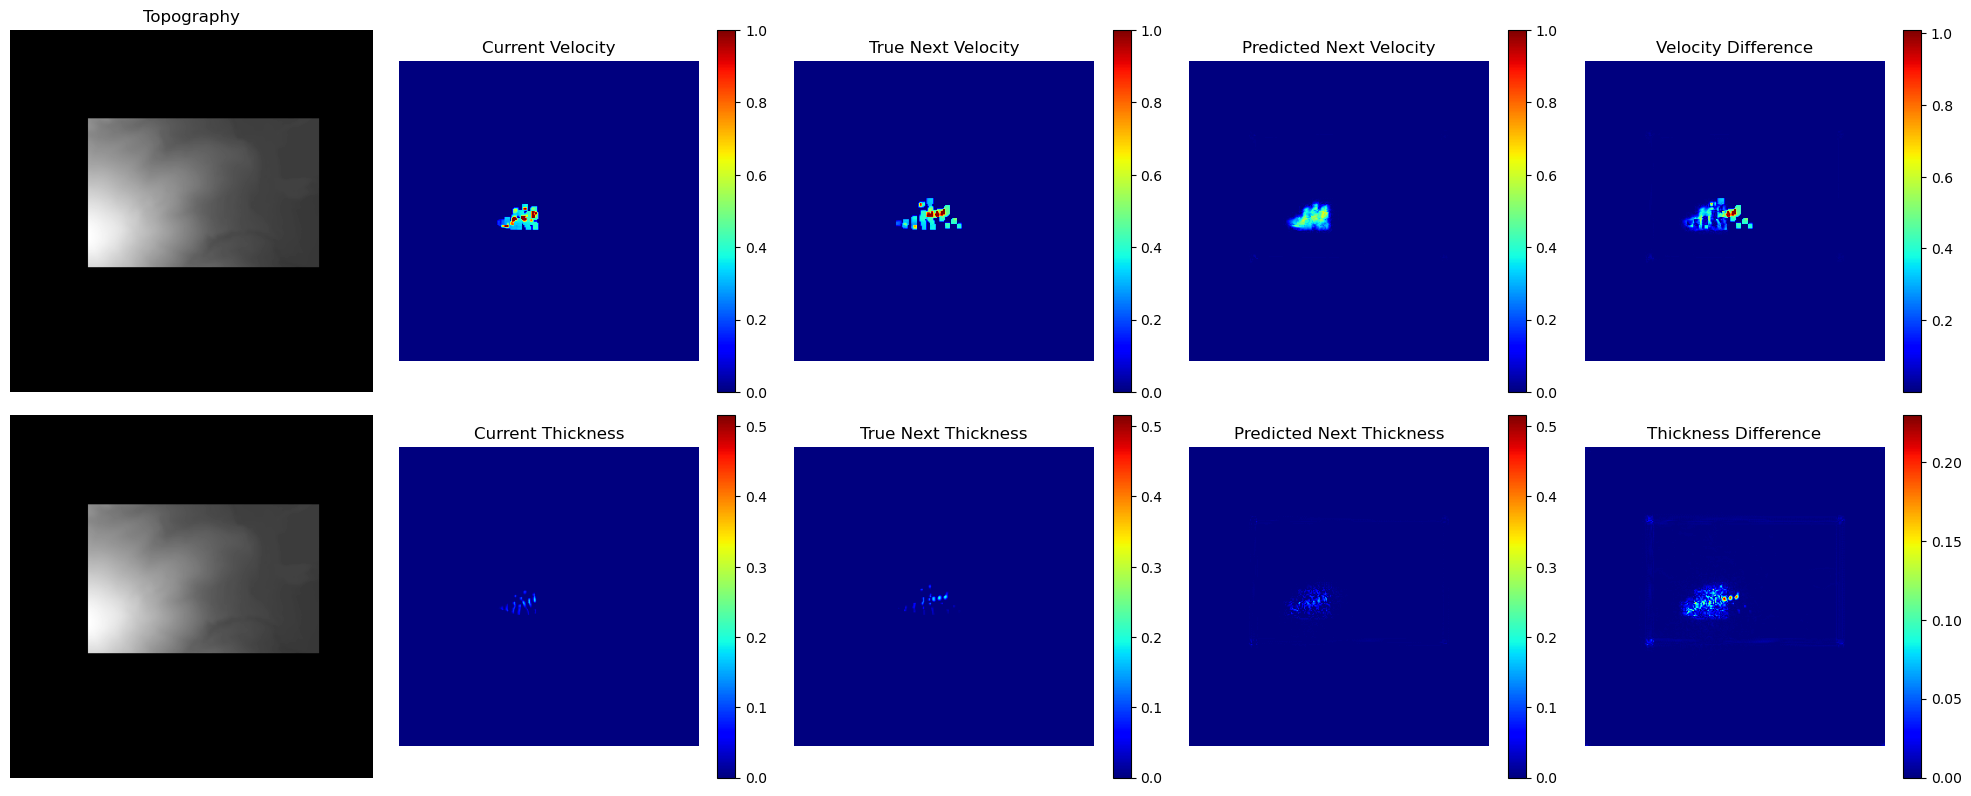

In [17]:
med_unet_trainer.plot_predictions(test_loader, num_predictions=5)

In [18]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

large_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512, 1024]).to(device)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    large_unet = nn.DataParallel(large_unet)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
optimizer = Adam(cnn.parameters(), lr=1e-3)

large_unet_trainer = TrainerPairs(large_unet, optimizer, criterion, device, model_name="large_unet", checkpoint_dir=checkpoint_dir)

large_unet_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_LargeUNet/model_epoch_50.pth", train_loader)

Using 2 GPUs!
Model loaded from /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_LargeUNet/model_epoch_50.pth


In [19]:
large_unet_trainer.test(test_loader)

Test Custom Loss: 0.0594
Test L1 Loss: 0.0012
Test MSE: 0.0002
Test RMSE: 0.0138
Test PSNR: 67.5554


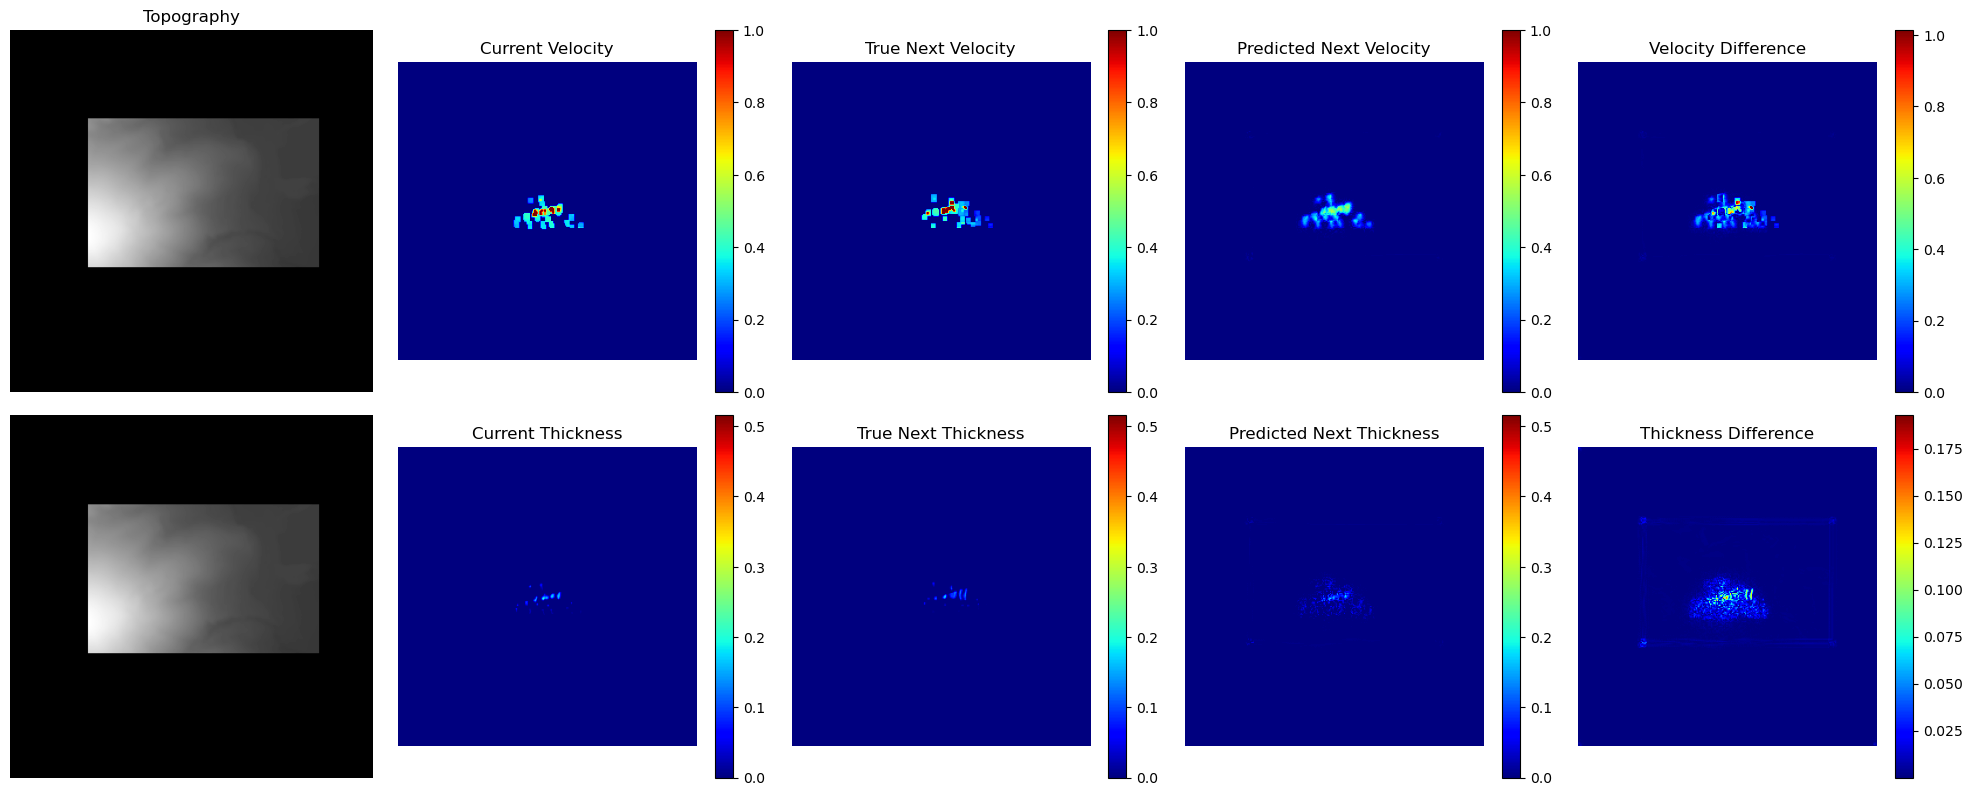

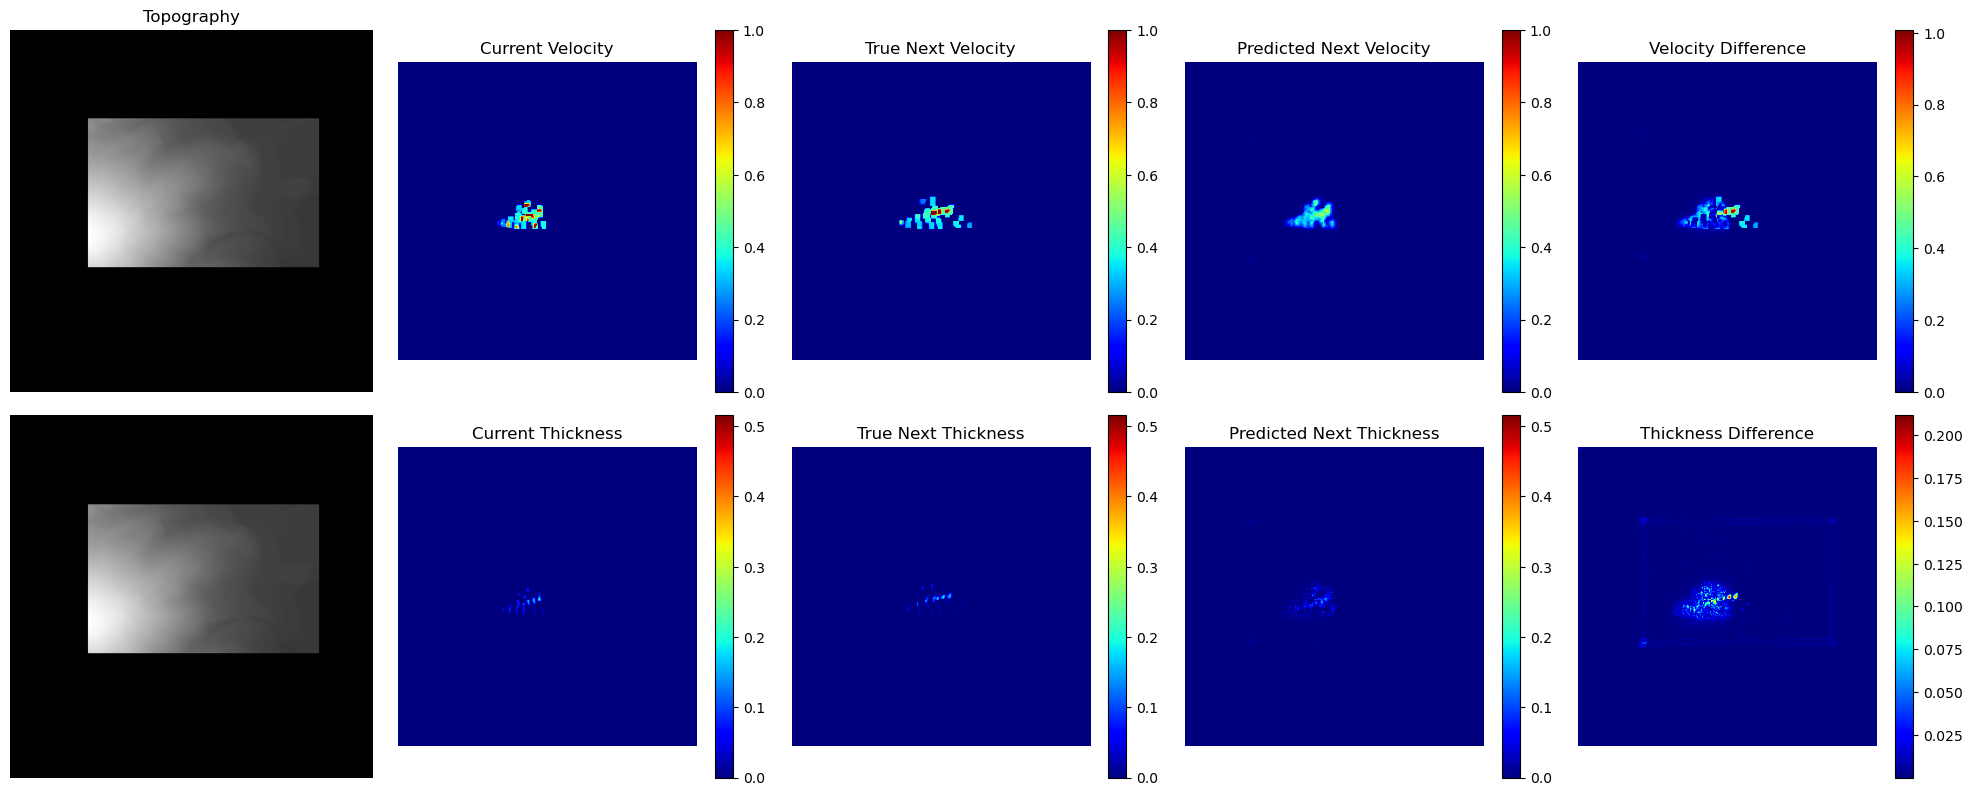

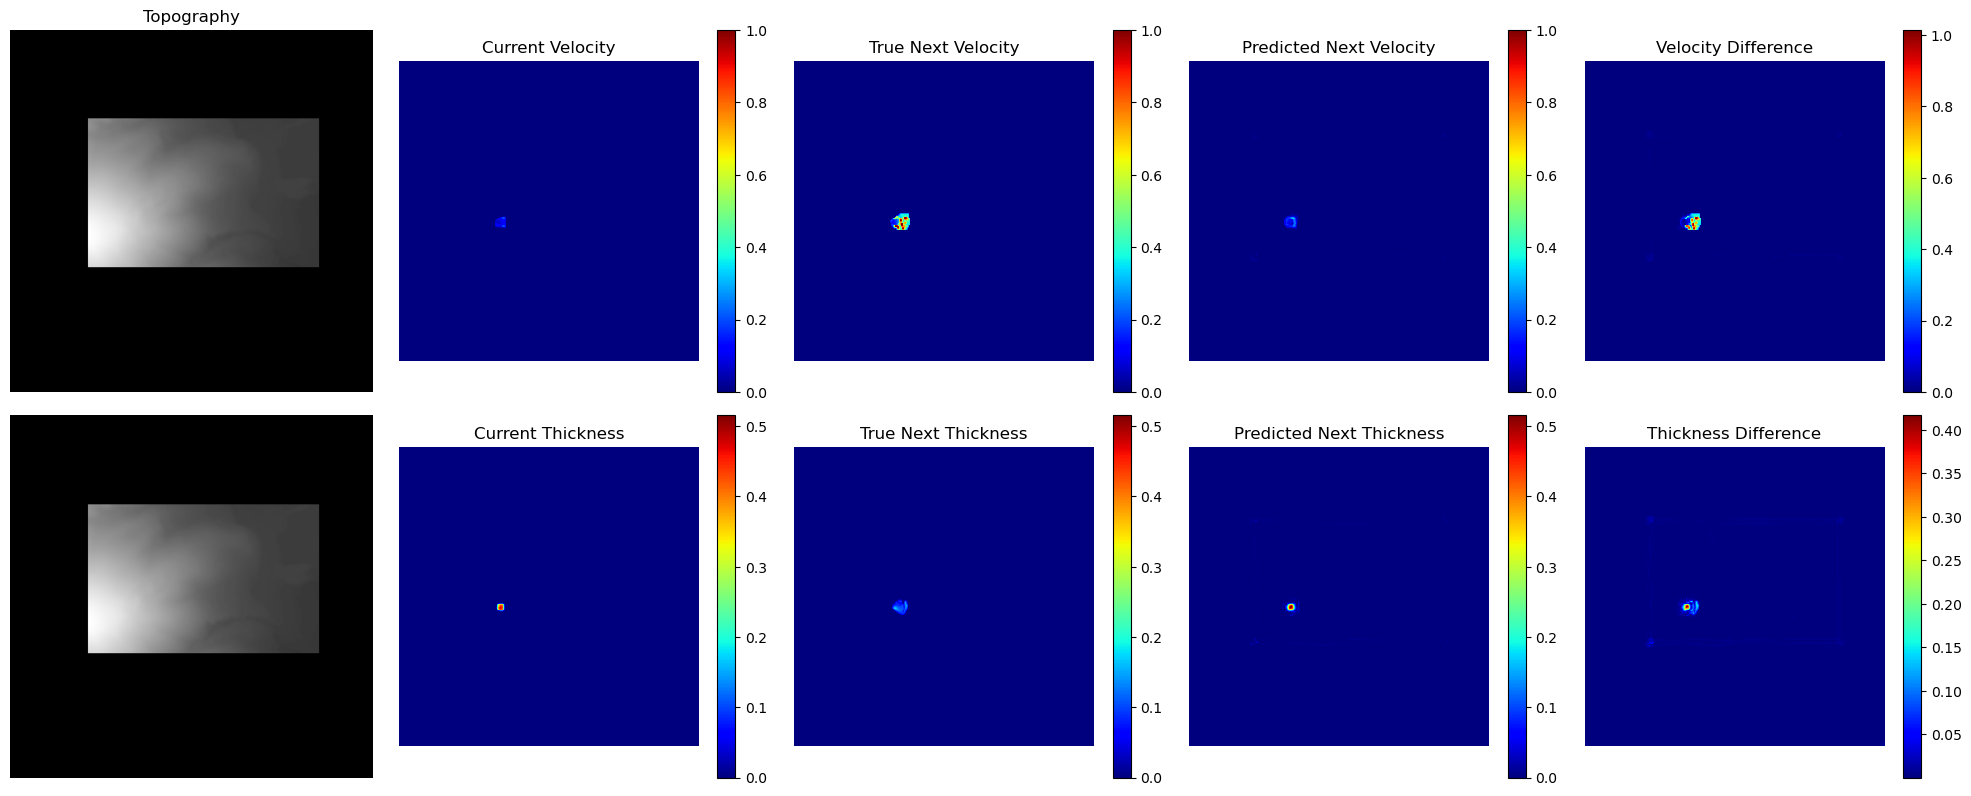

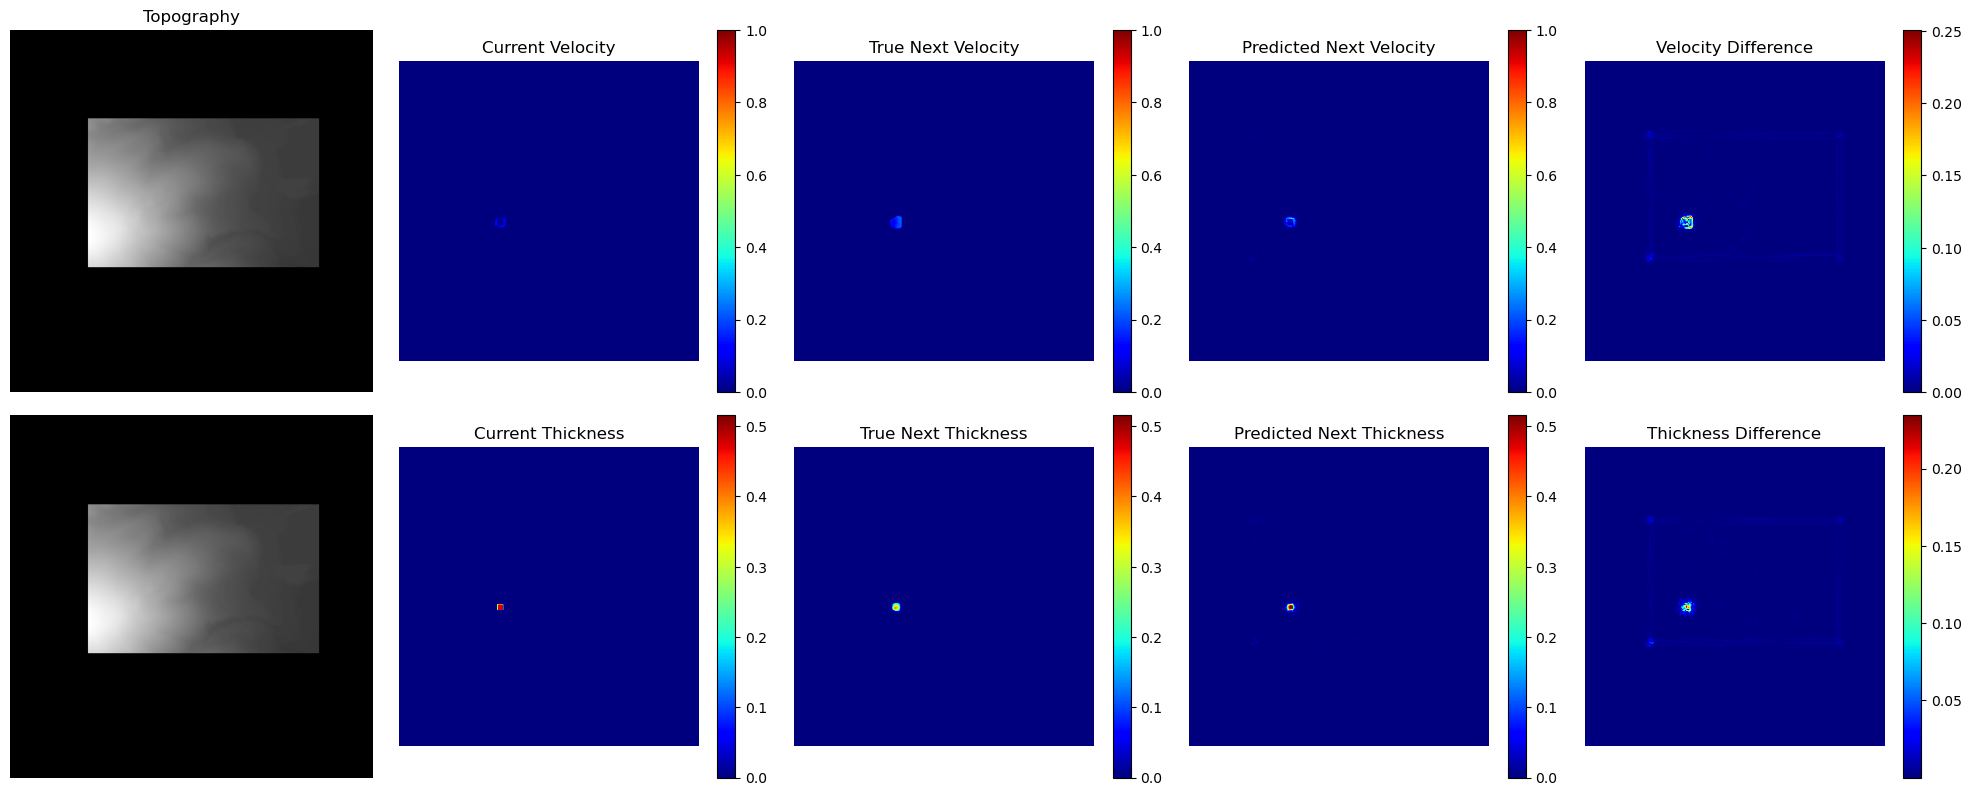

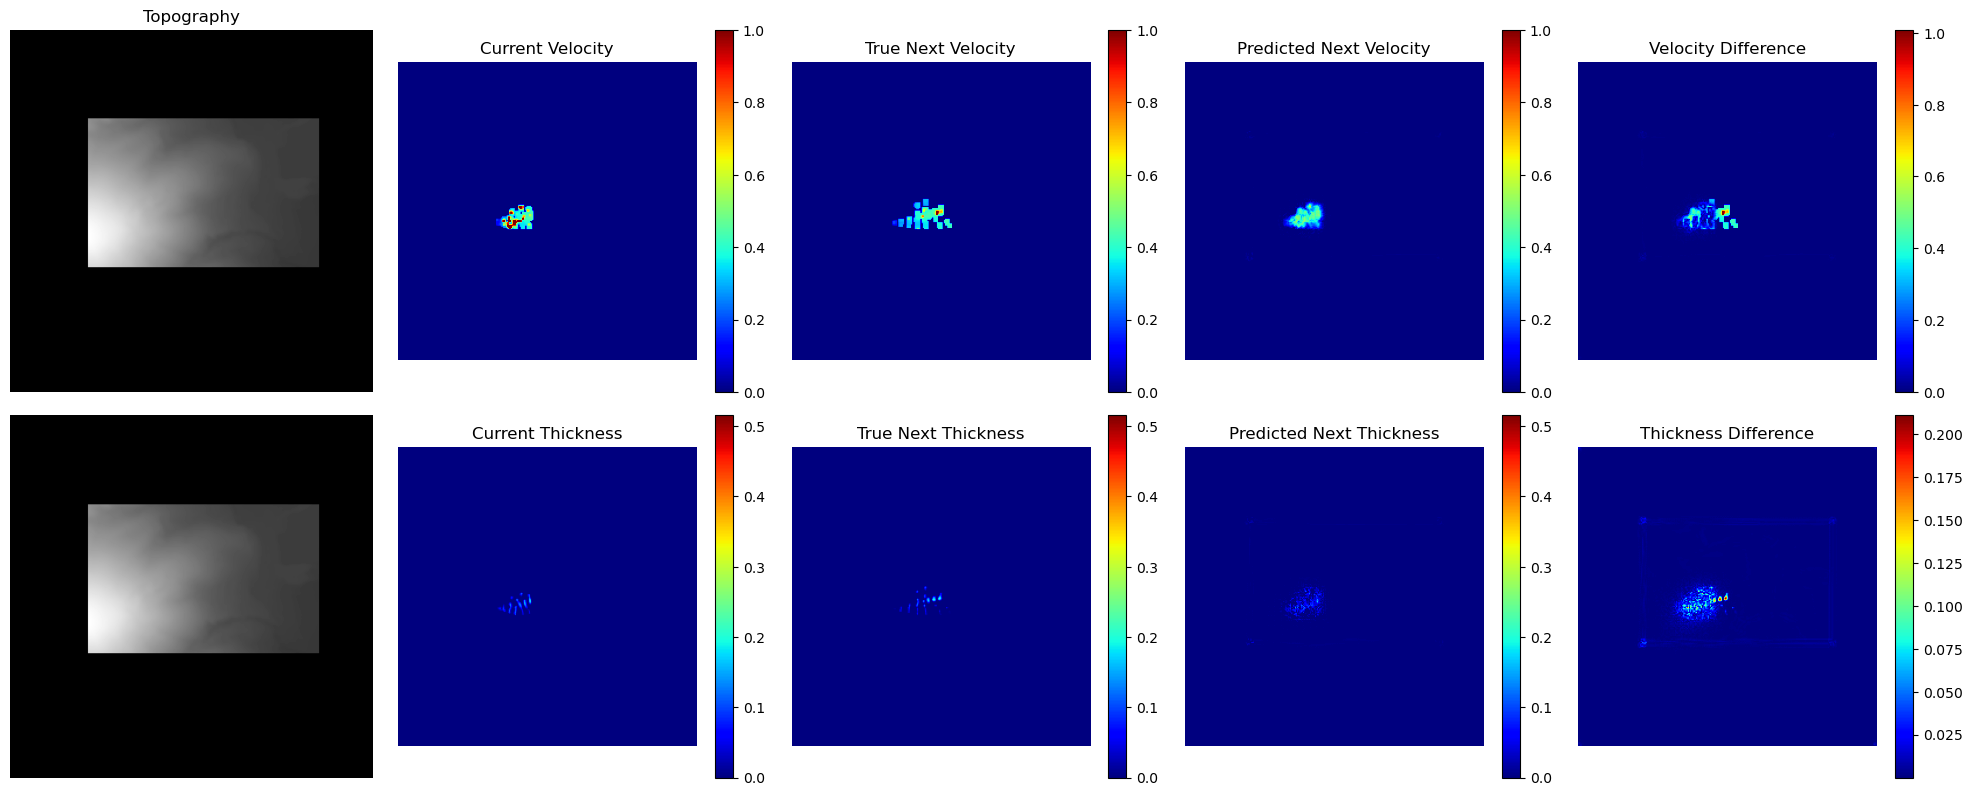

In [20]:
large_unet_trainer.plot_predictions(test_loader, num_predictions=5)

# THIS IS THE NEW STUFF TO TRY REGARDING INFER vs REAL

In [ ]:
def plot_real_vs_inferred(real_states, inferred_states, n=5):
    num_timesteps = len(real_states)
    timesteps_to_plot = range(1, num_timesteps + 1, n)  # Start from 1 and go up to num_timesteps + 1

    for timestep in timesteps_to_plot:
        real_state = real_states[timestep]
        inferred_state = inferred_states[timestep]

        # Extract velocity and thickness from real and inferred states
        real_velocity = real_state[1]
        real_thickness = real_state[0]
        inferred_velocity = inferred_state[1]
        inferred_thickness = inferred_state[0]

        # Calculate differences
        velocity_diff = np.abs(real_velocity - inferred_velocity)
        thickness_diff = np.abs(real_thickness - inferred_thickness)

        plt.figure(figsize=(20, 8))

        # Row 1: Real Velocity, Inferred Velocity, Velocity Difference
        plt.subplot(2, 3, 1)
        plt.imshow(real_velocity, cmap='jet')
        plt.title(f'Real Velocity (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        plt.subplot(2, 3, 2)
        plt.imshow(inferred_velocity, cmap='jet')
        plt.title(f'Inferred Velocity (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        plt.subplot(2, 3, 3)
        plt.imshow(velocity_diff, cmap='jet')
        plt.title(f'Velocity Difference (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        # Row 2: Real Thickness, Inferred Thickness, Thickness Difference
        plt.subplot(2, 3, 4)
        plt.imshow(real_thickness, cmap='jet')
        plt.title(f'Real Thickness (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        plt.subplot(2, 3, 5)
        plt.imshow(inferred_thickness, cmap='jet')
        plt.title(f'Inferred Thickness (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        plt.subplot(2, 3, 6)
        plt.imshow(thickness_diff, cmap='jet')
        plt.title(f'Thickness Difference (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        plt.tight_layout()
        plt.show()

    # Stack all inferred arrays and all actual arrays
    stacked_inferred_velocity = np.stack([state[1] for state in inferred_states.values()], axis=0)
    stacked_inferred_thickness = np.stack([state[0] for state in inferred_states.values()], axis=0)
    stacked_real_velocity = np.stack([state[1] for state in real_states.values()], axis=0)
    stacked_real_thickness = np.stack([state[0] for state in real_states.values()], axis=0)

    # Plot stacked arrays side by side
    plt.figure(figsize=(20, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(stacked_real_velocity.max(axis=0), cmap='jet')
    plt.title('Stacked Real Velocity')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 3, 2)
    plt.imshow(stacked_inferred_velocity.max(axis=0), cmap='jet')
    plt.title('Stacked Inferred Velocity')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 3, 3)
    plt.imshow(np.abs(stacked_real_velocity.max(axis=0) - stacked_inferred_velocity.max(axis=0)), cmap='jet')
    plt.title('Stacked Velocity Difference')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 3, 4)
    plt.imshow(stacked_real_thickness.max(axis=0), cmap='jet')
    plt.title('Stacked Real Thickness')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 3, 5)
    plt.imshow(stacked_inferred_thickness.max(axis=0), cmap='jet')
    plt.title('Stacked Inferred Thickness')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 3, 6)
    plt.imshow(np.abs(stacked_real_thickness.max(axis=0) - stacked_inferred_thickness.max(axis=0)), cmap='jet')
    plt.title('Stacked Thickness Difference')
    plt.axis('off')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


def create_real_states_dict(root_dir, model_number, start_state, num_timesteps, array_size):
    real_states = {}
    
    model_dir = os.path.join(root_dir, str(model_number))
    velocity_dir = os.path.join(model_dir, f'04_FinalProcessedData_{array_size}', 'velocity')
    thickness_dir = os.path.join(model_dir, f'04_FinalProcessedData_{array_size}', 'thickness')
    
    for t in range(num_timesteps):
        state_number = start_state + t
        
        velocity_file = os.path.join(velocity_dir, f'{model_number}_velocity_{state_number}.npy')
        thickness_file = os.path.join(thickness_dir, f'{model_number}_thickness_{state_number}.npy')
        
        velocity = np.load(velocity_file)
        thickness = np.load(thickness_file)
        
        real_states[t + 1] = np.stack((thickness, velocity), axis=0)  # Change the key to t + 1
    
    return real_states

## roughly how to use

Does some weird stuff with the class though

Elevation shape initial: torch.Size([1, 256, 256])
Elevation shape adjusted: torch.Size([1, 1, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elev

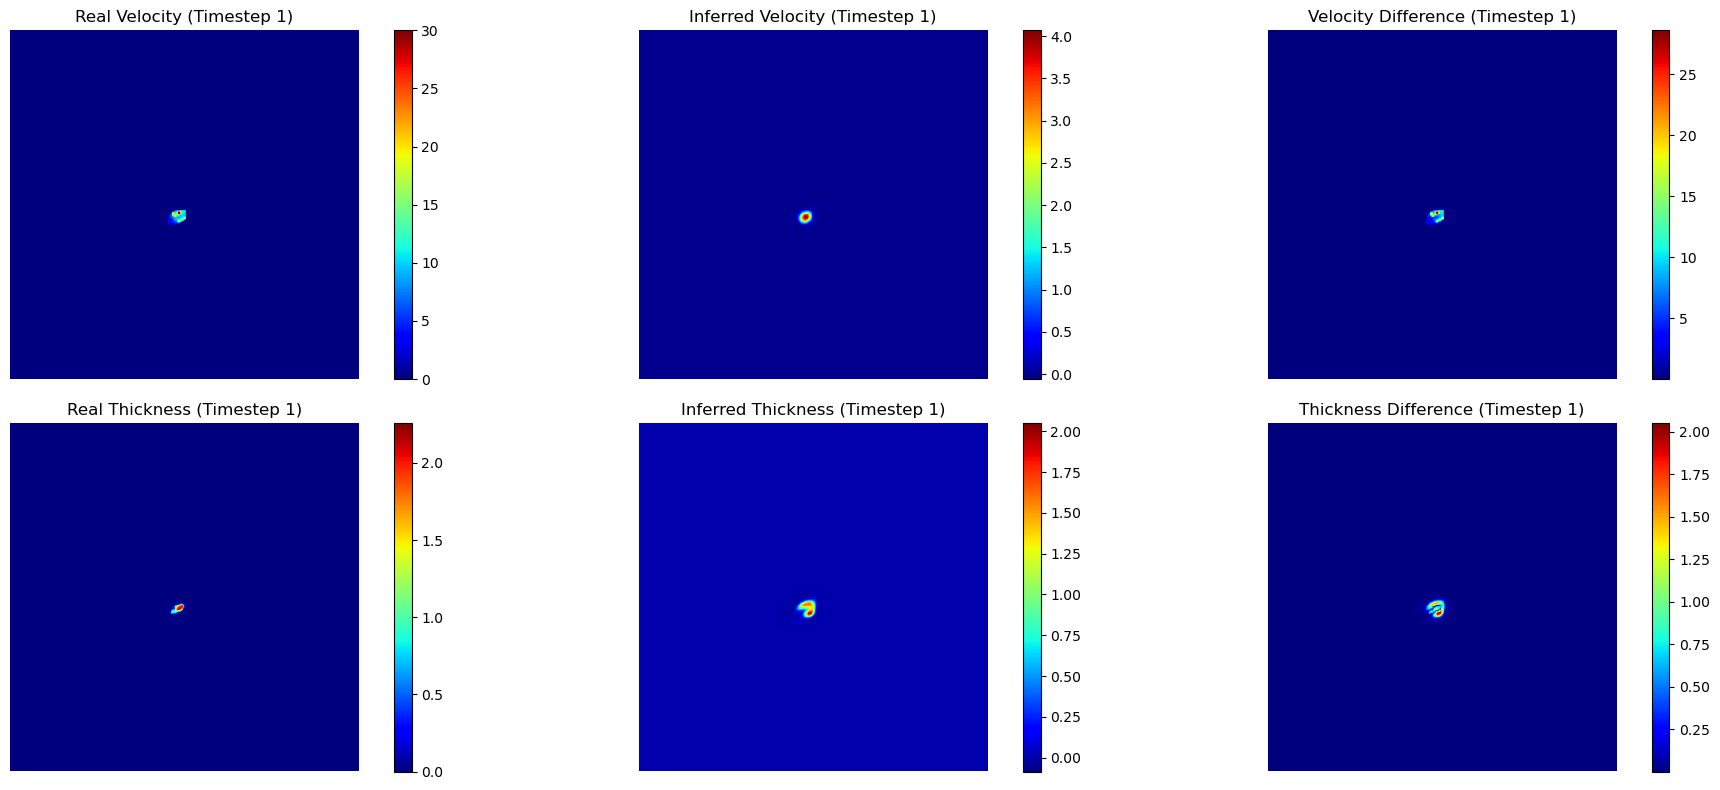

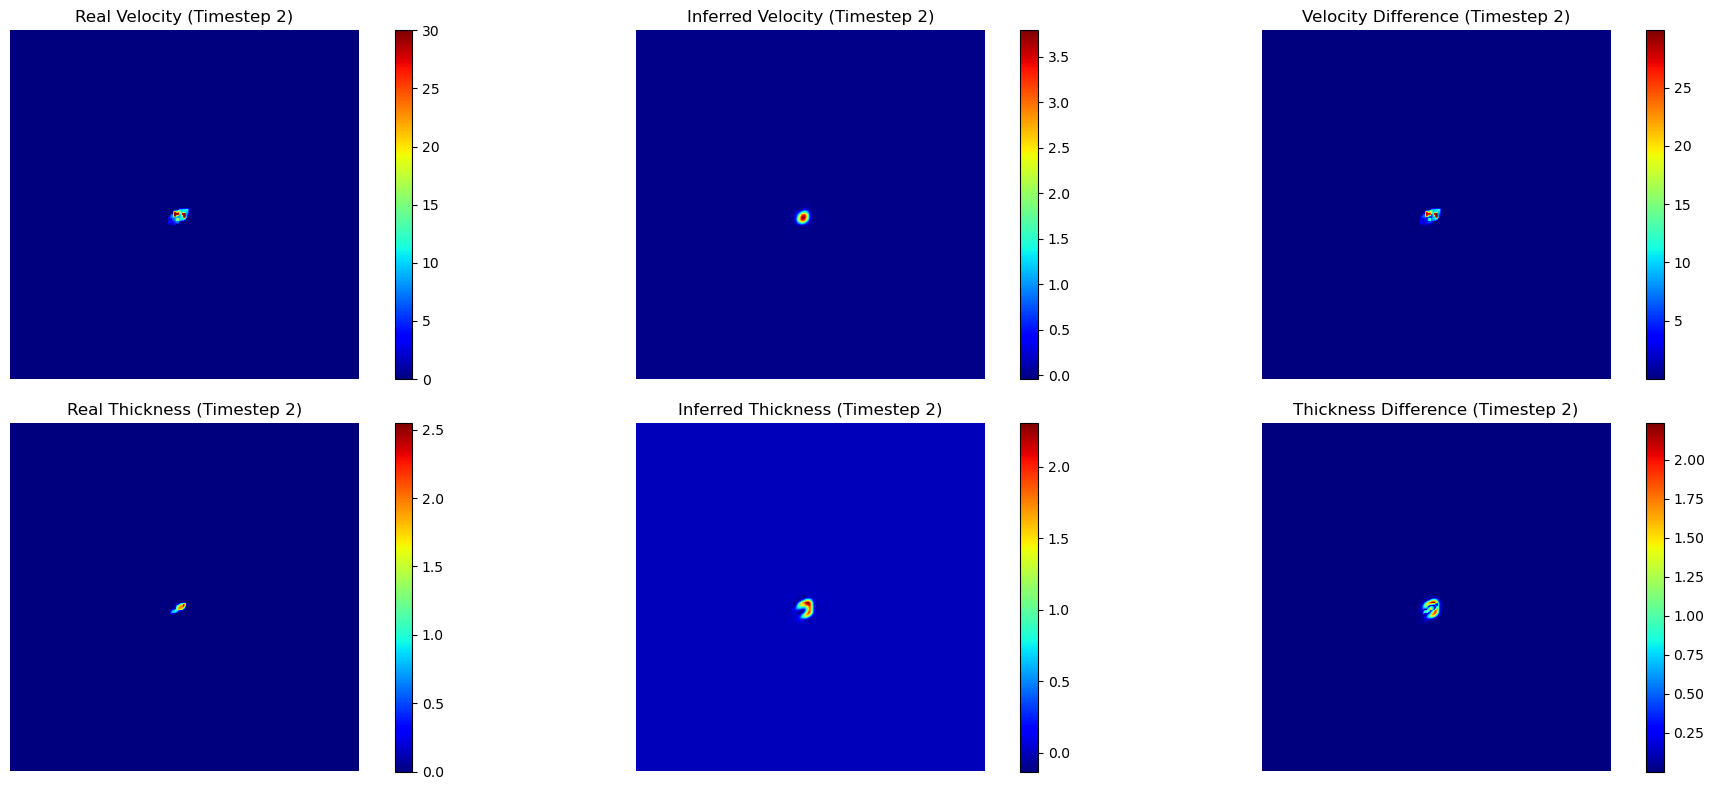

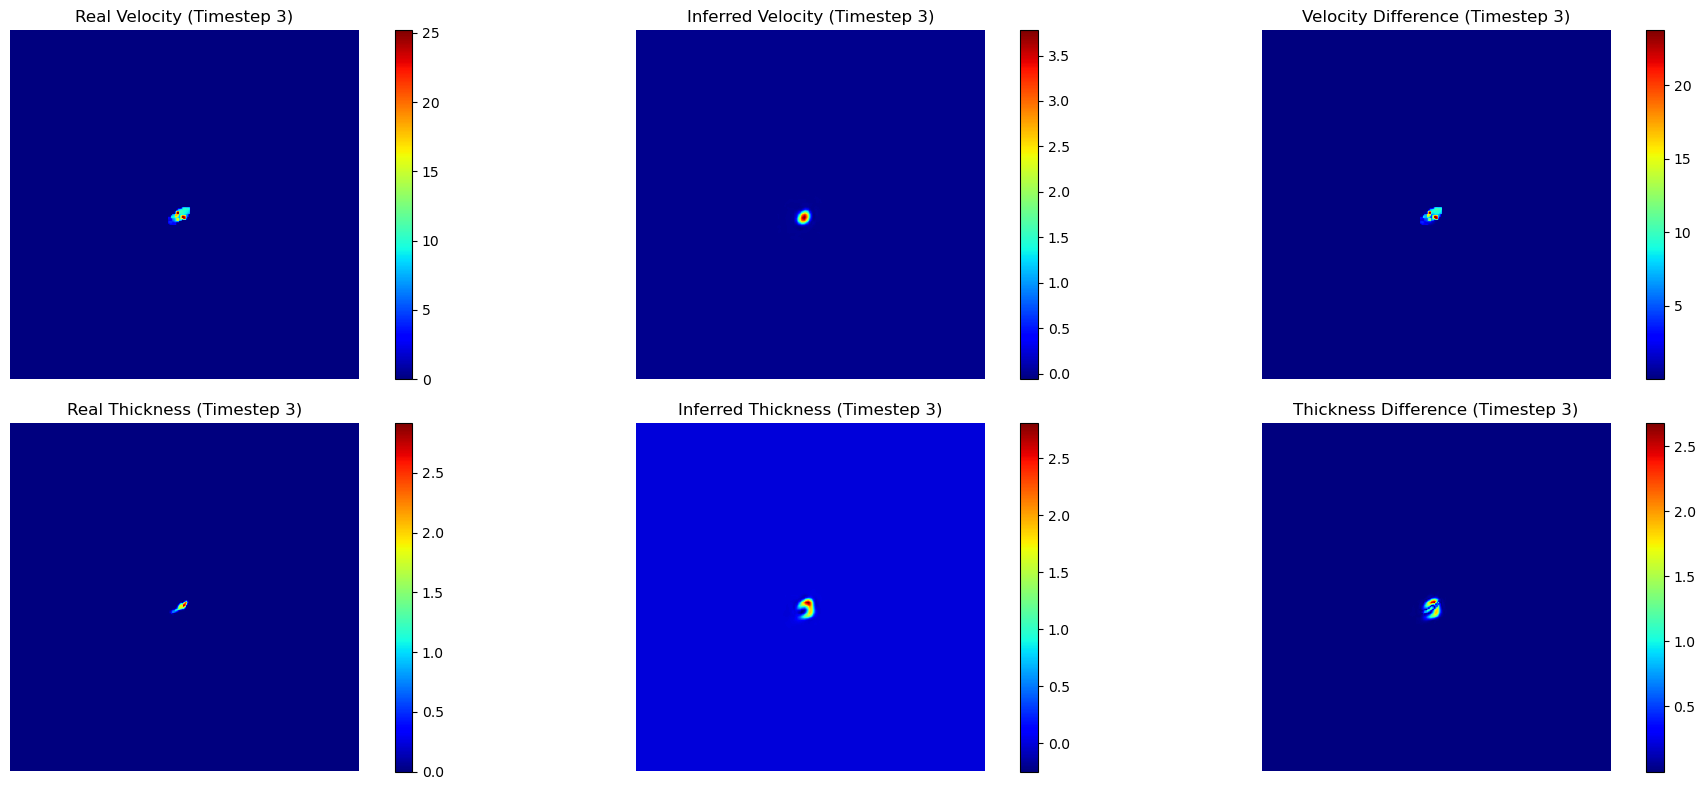

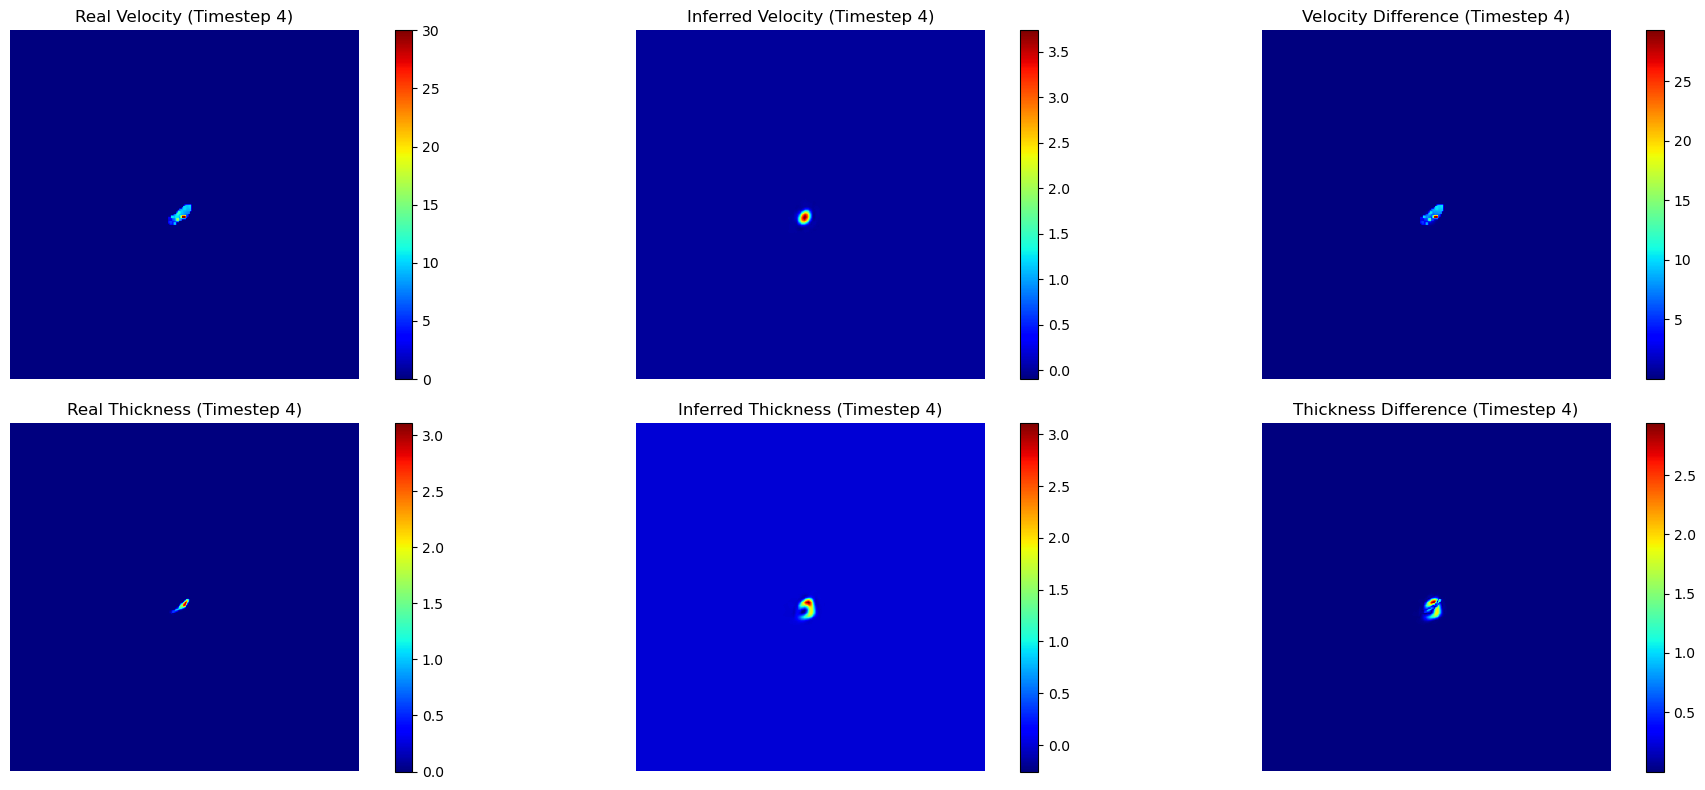

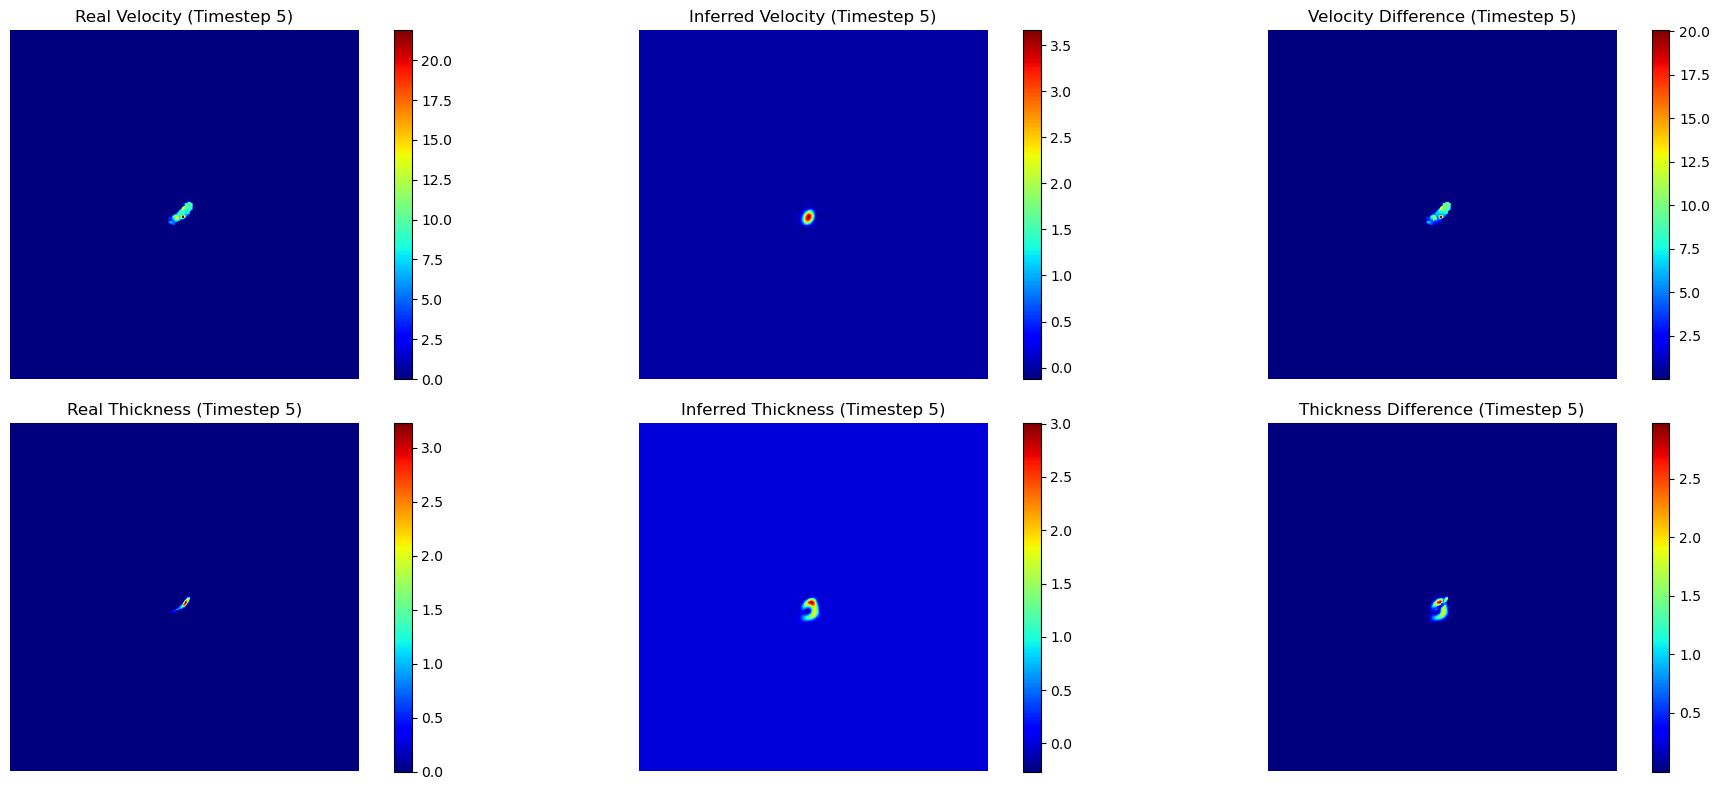

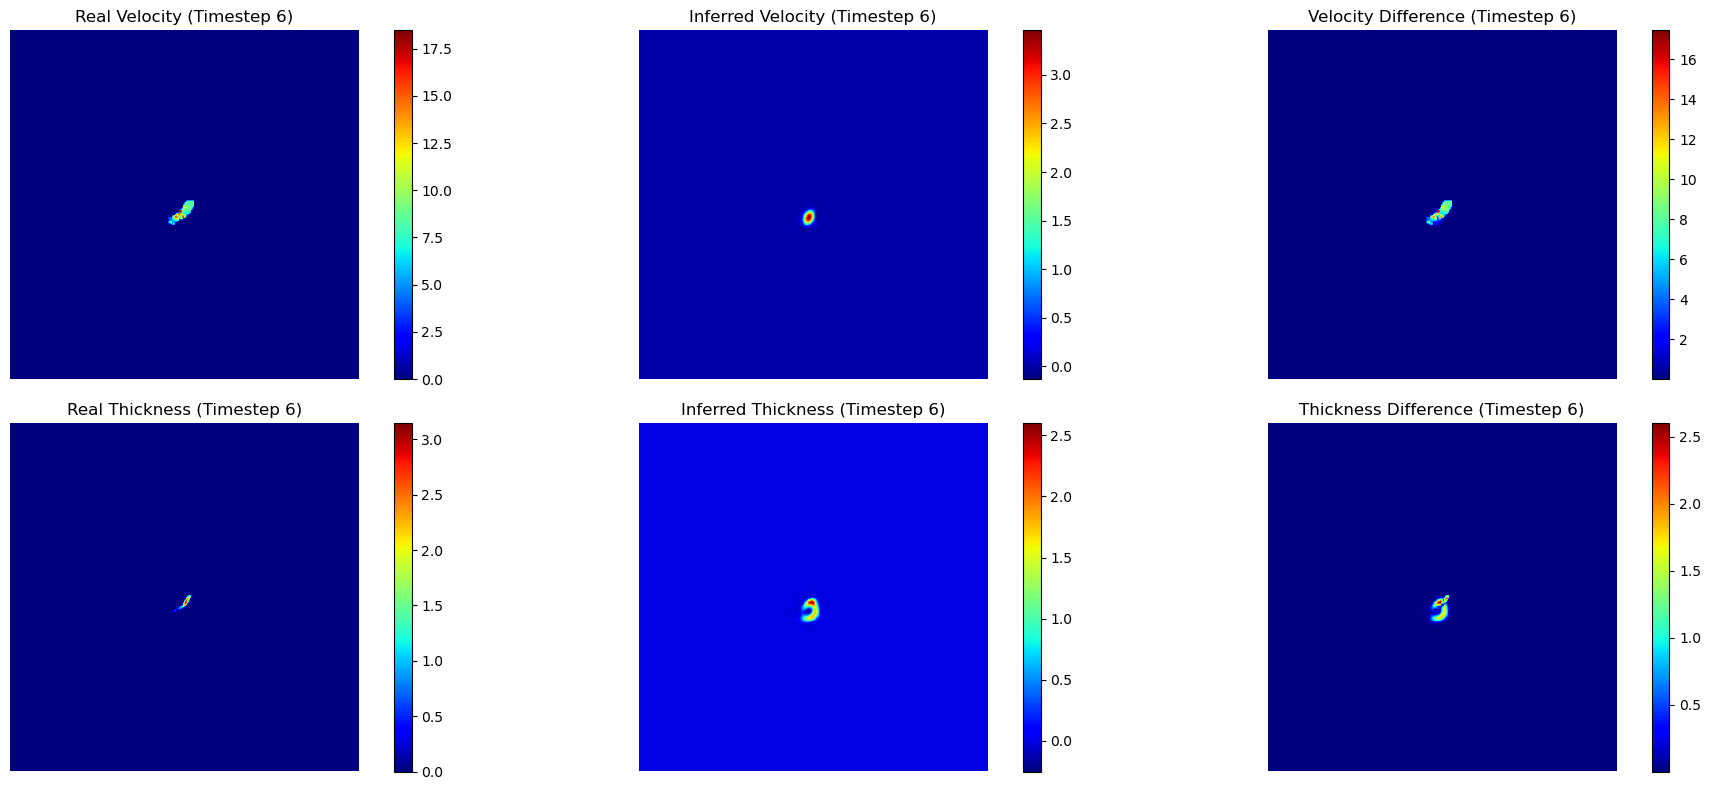

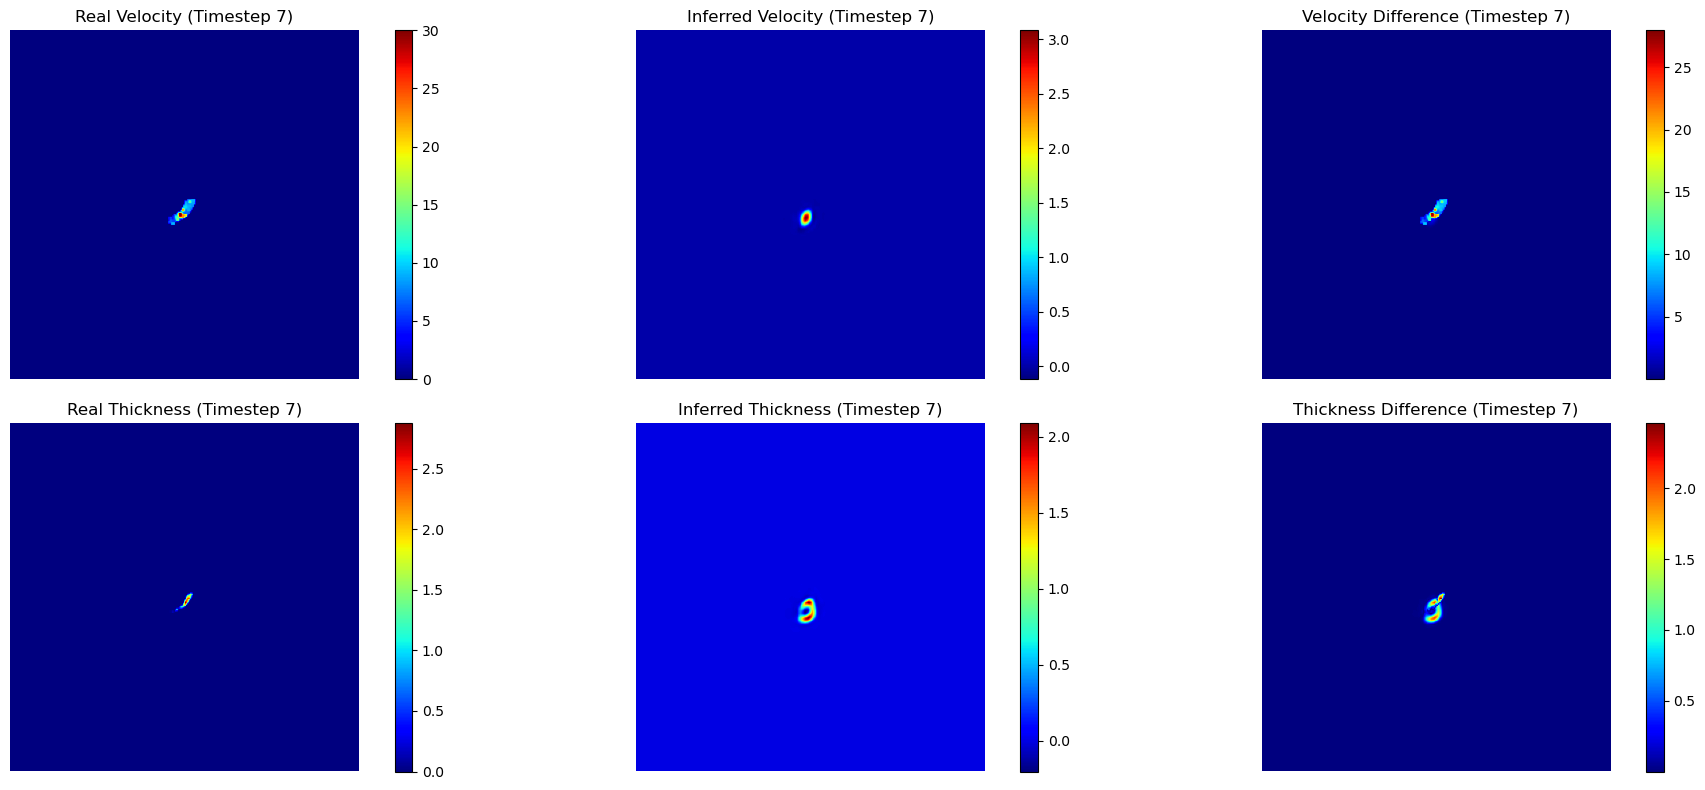

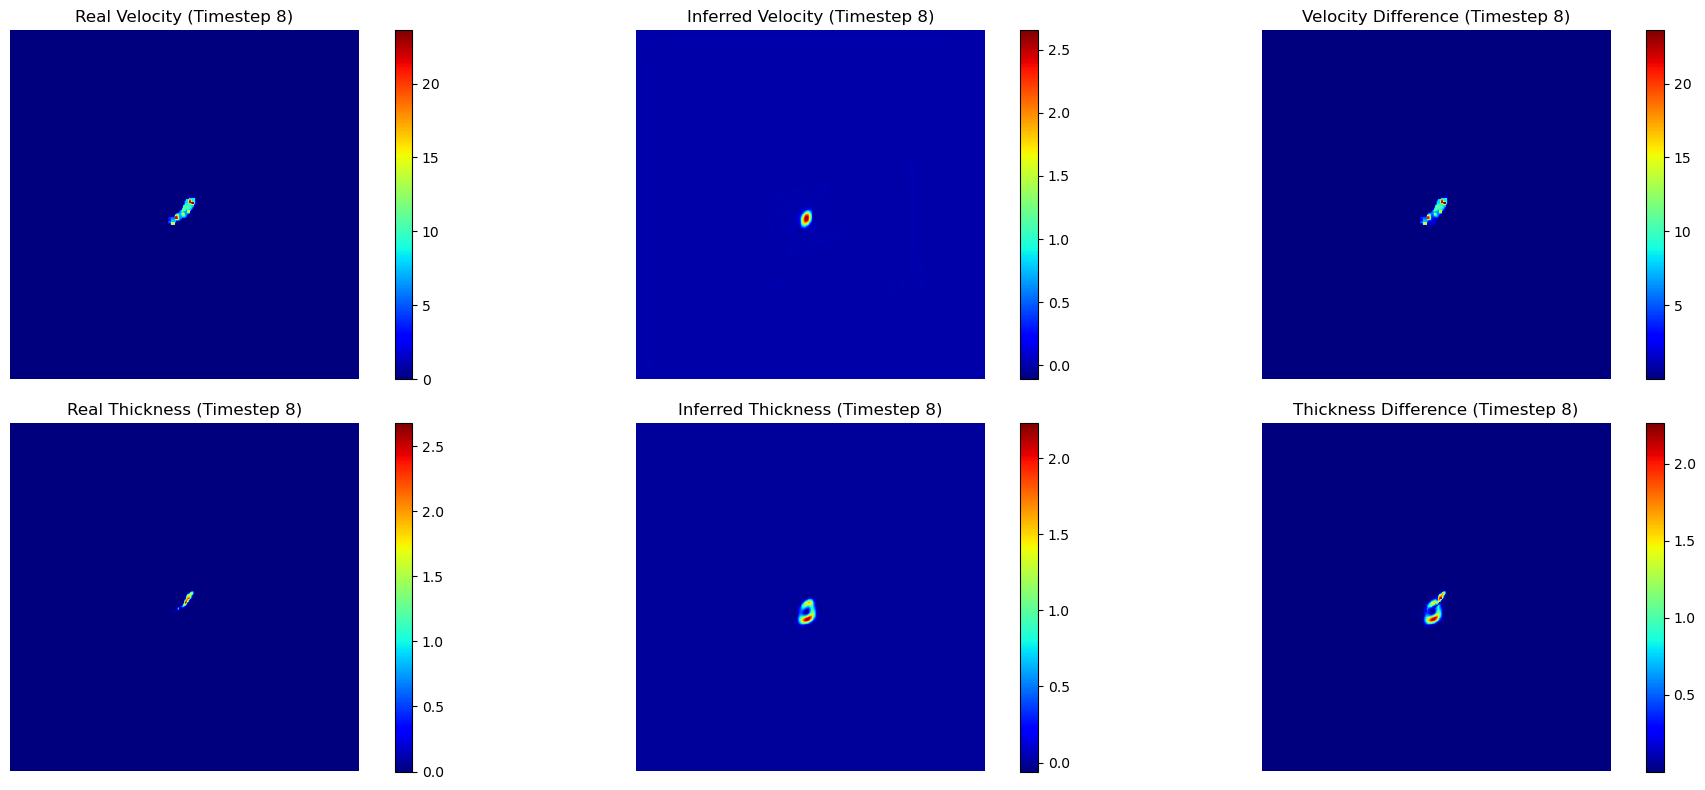

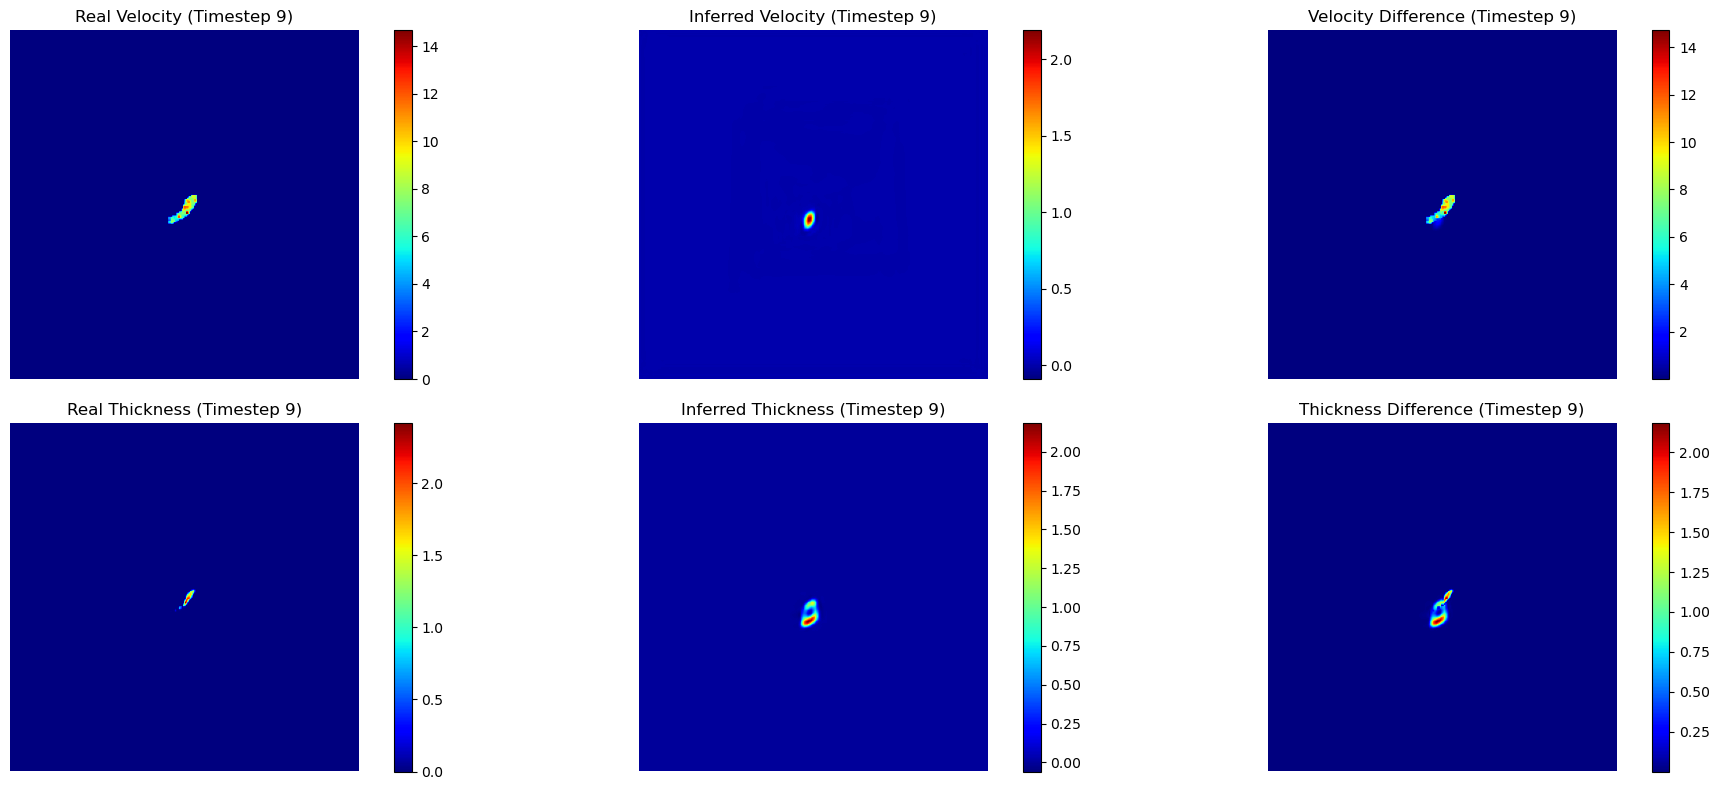

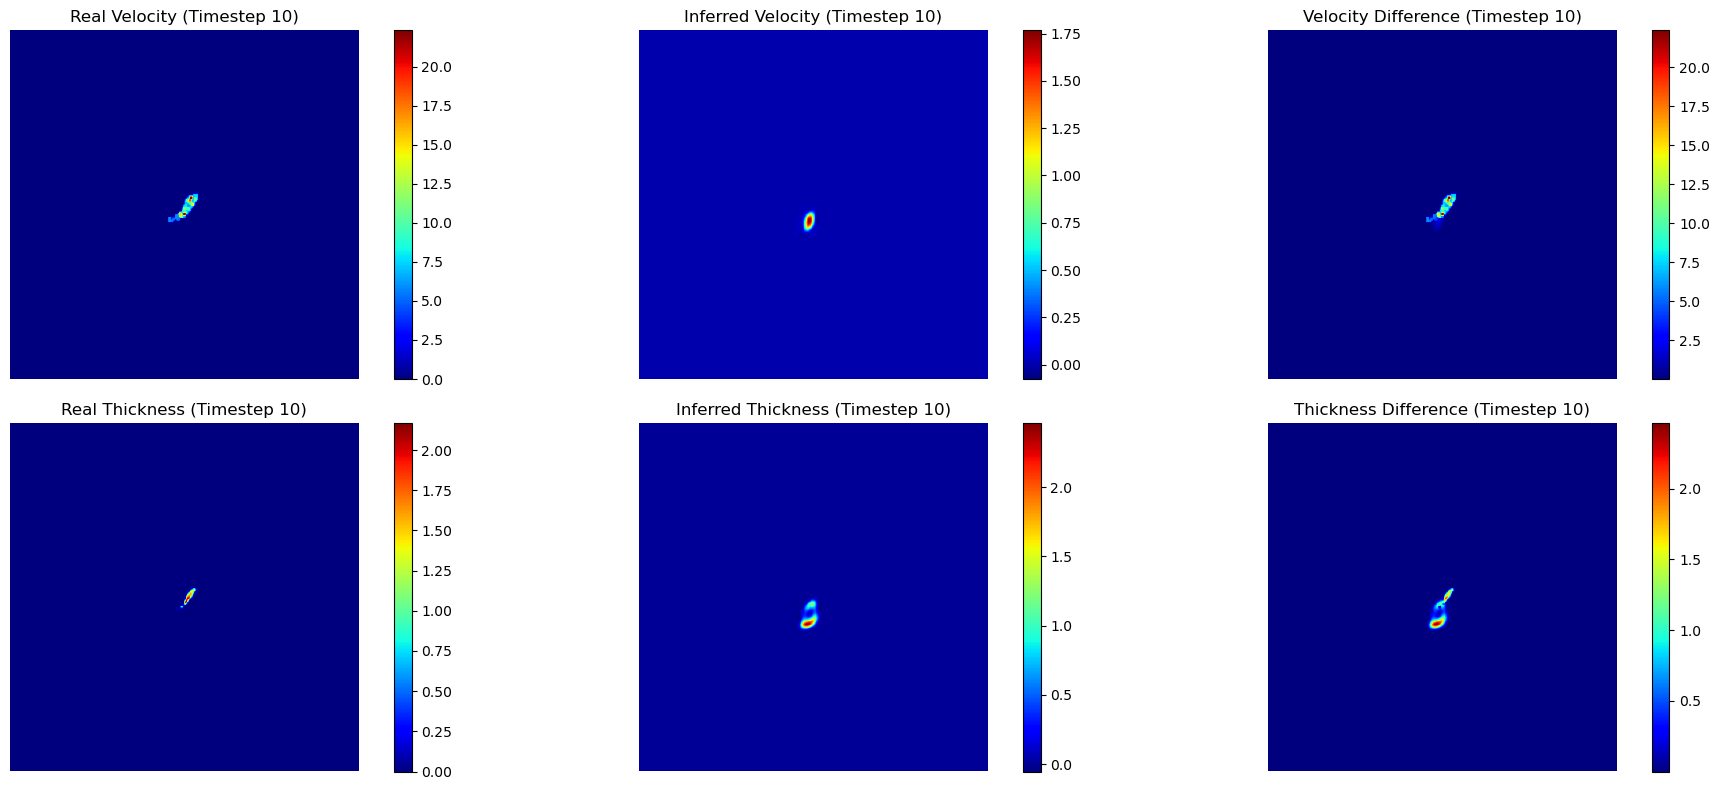

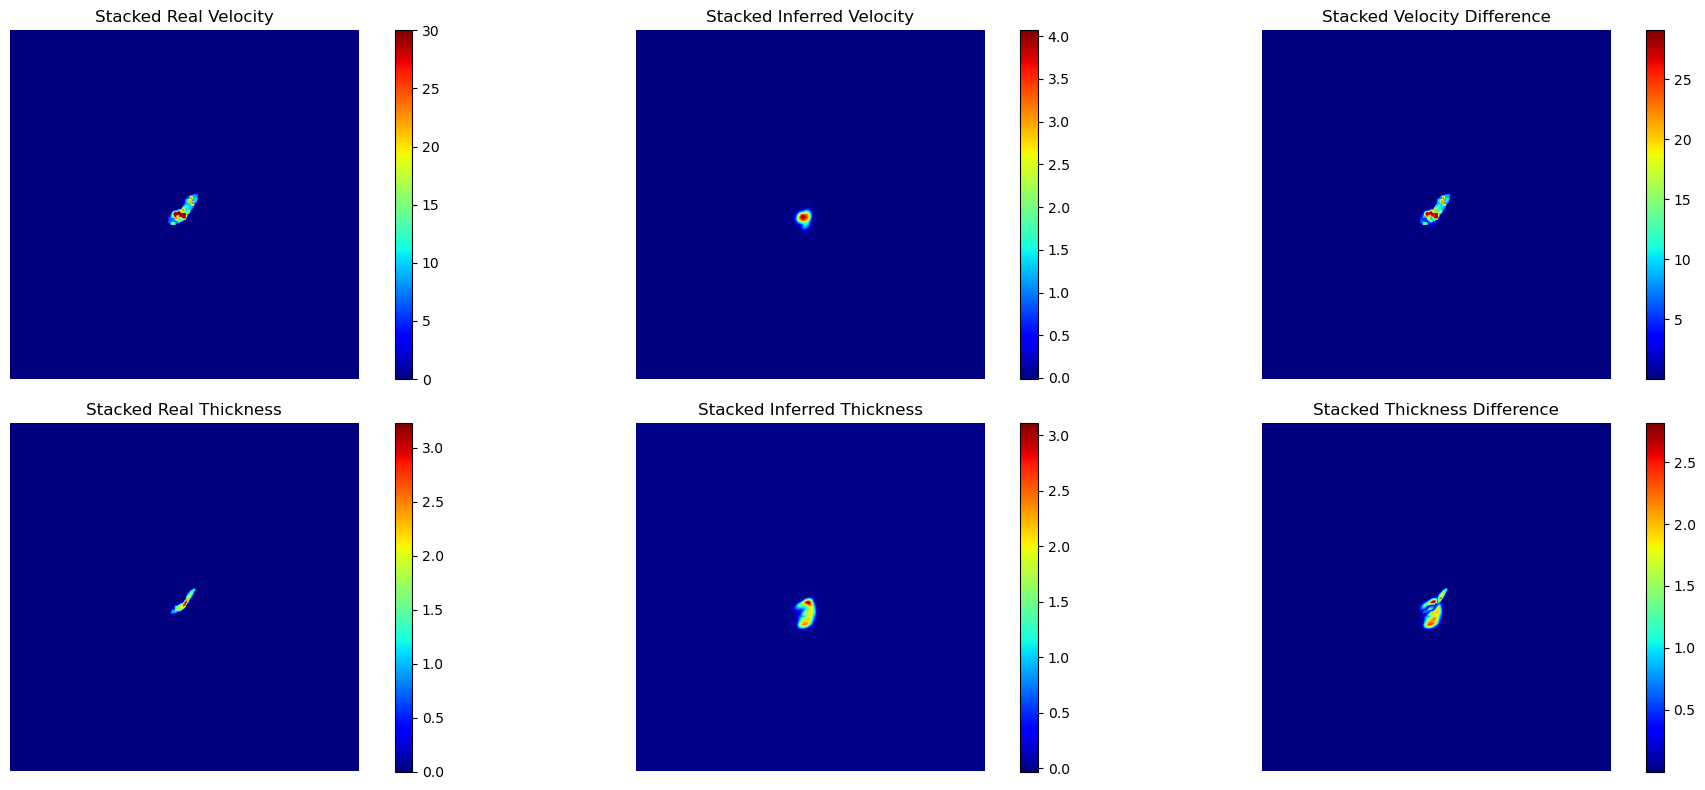

In [ ]:

# Create the initial input
initial_input = cnn_trainer.create_inference_input(root_dir, '00378', 10, 256)

# Perform inference
num_timesteps = 10
inferred_states = cnn_trainer.infer(initial_input, num_timesteps)

# Create the real states dictionary
real_states = create_real_states_dict(root_dir, '00378', 10+1, num_timesteps, 256)

# Plot real vs inferred states
plot_real_vs_inferred(real_states, inferred_states, n=1)

Elevation shape initial: torch.Size([1, 256, 256])
Elevation shape adjusted: torch.Size([1, 1, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elev

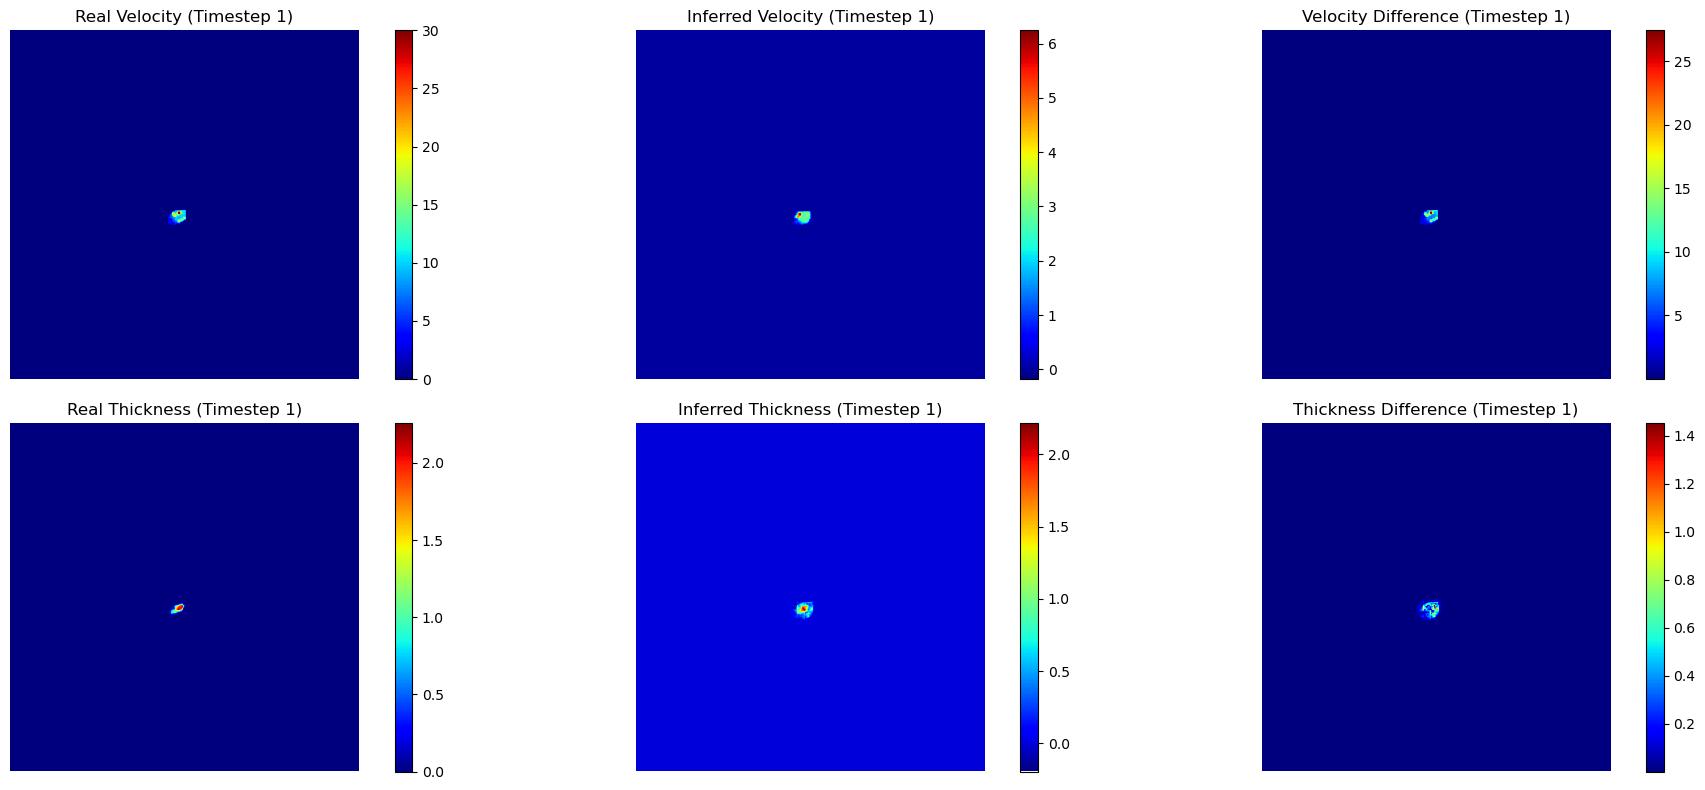

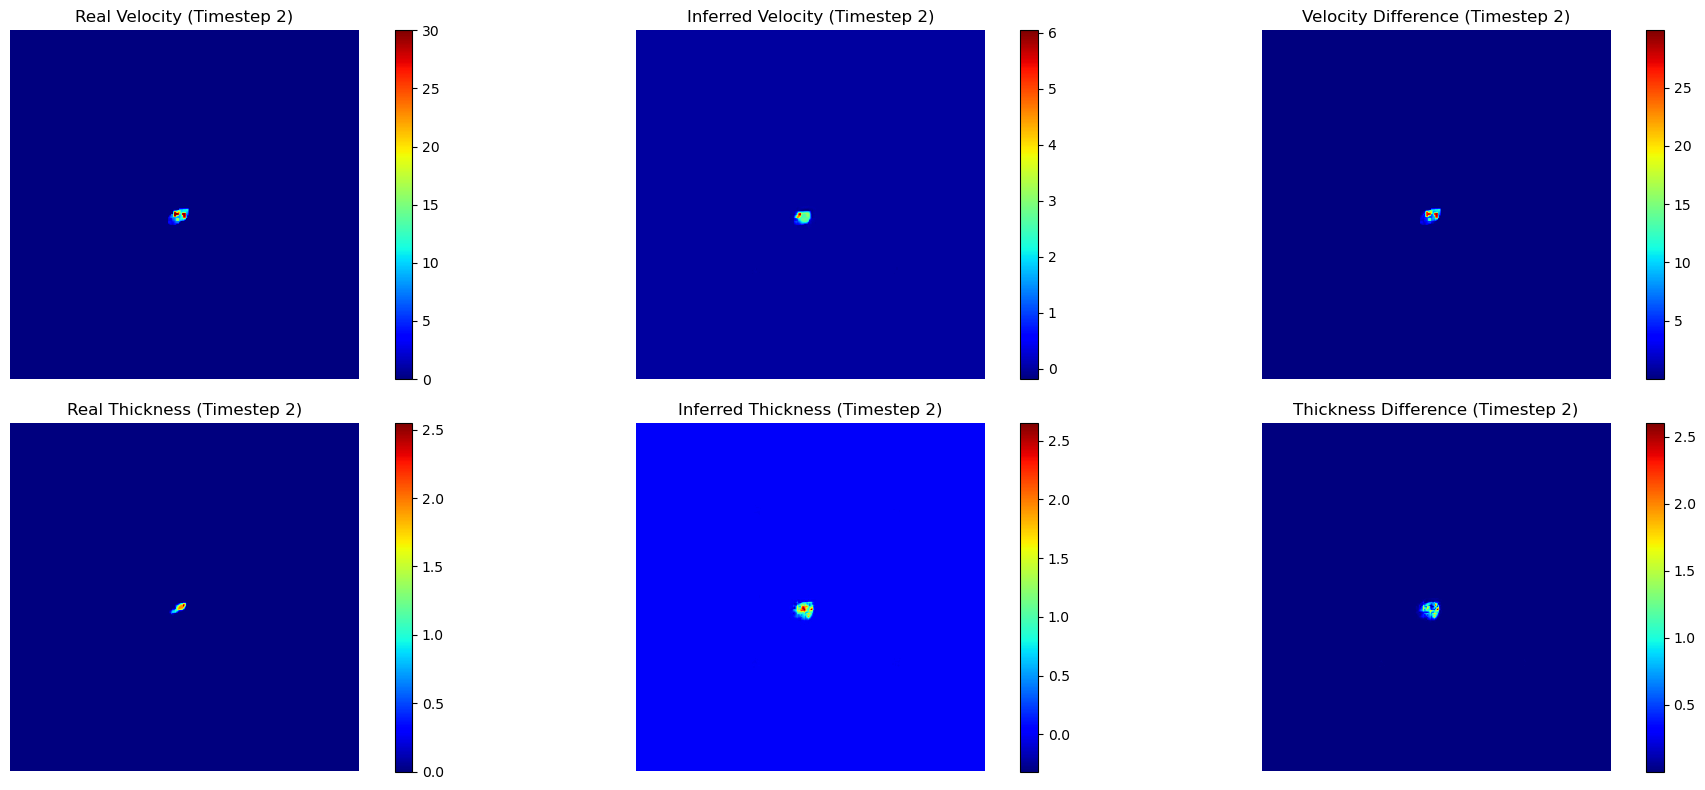

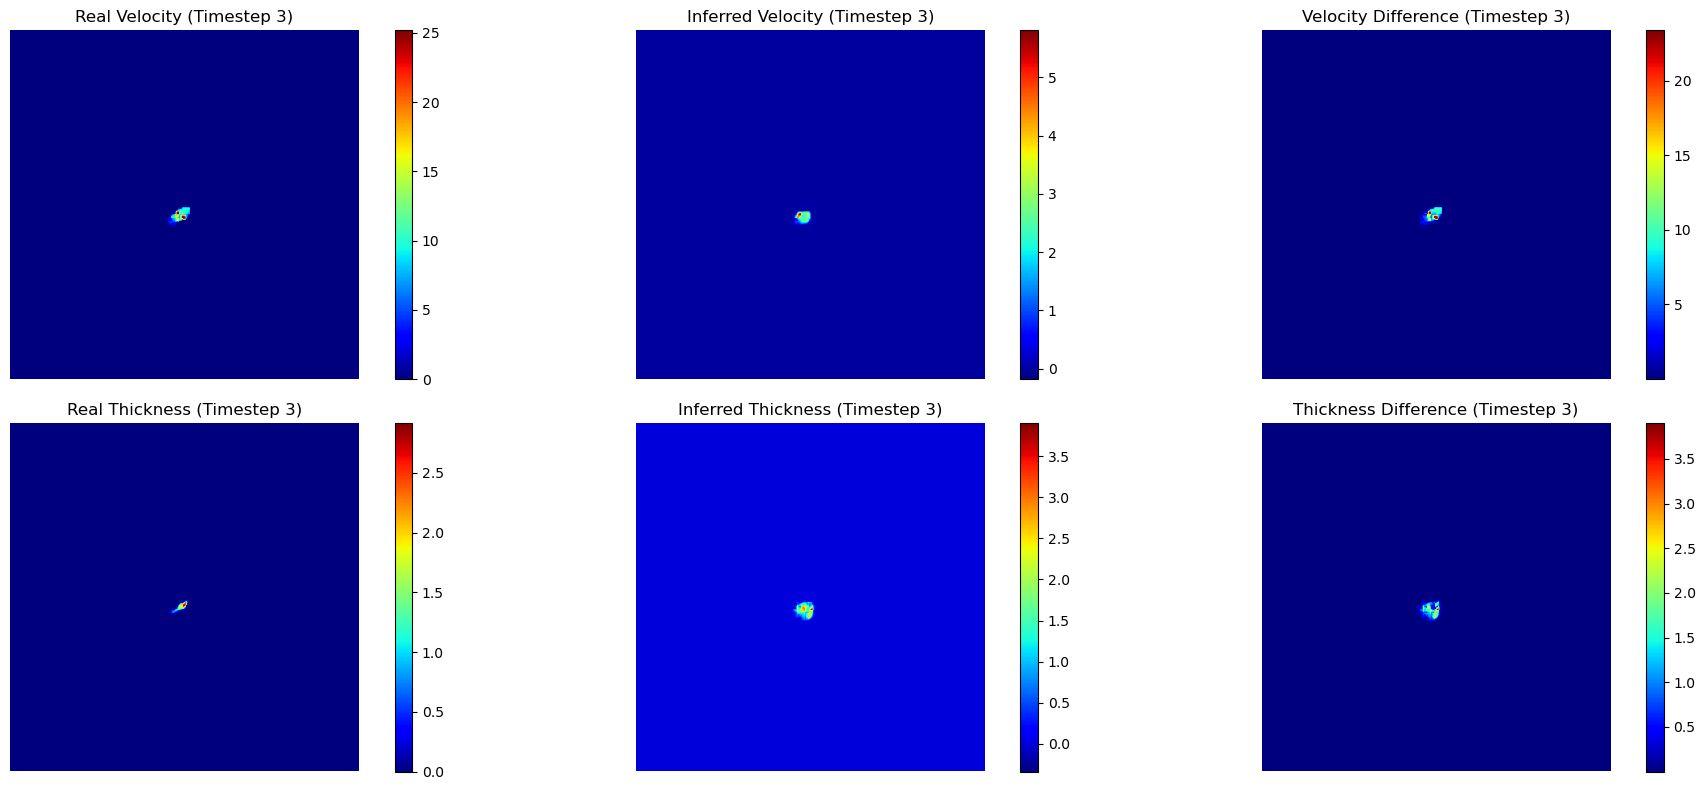

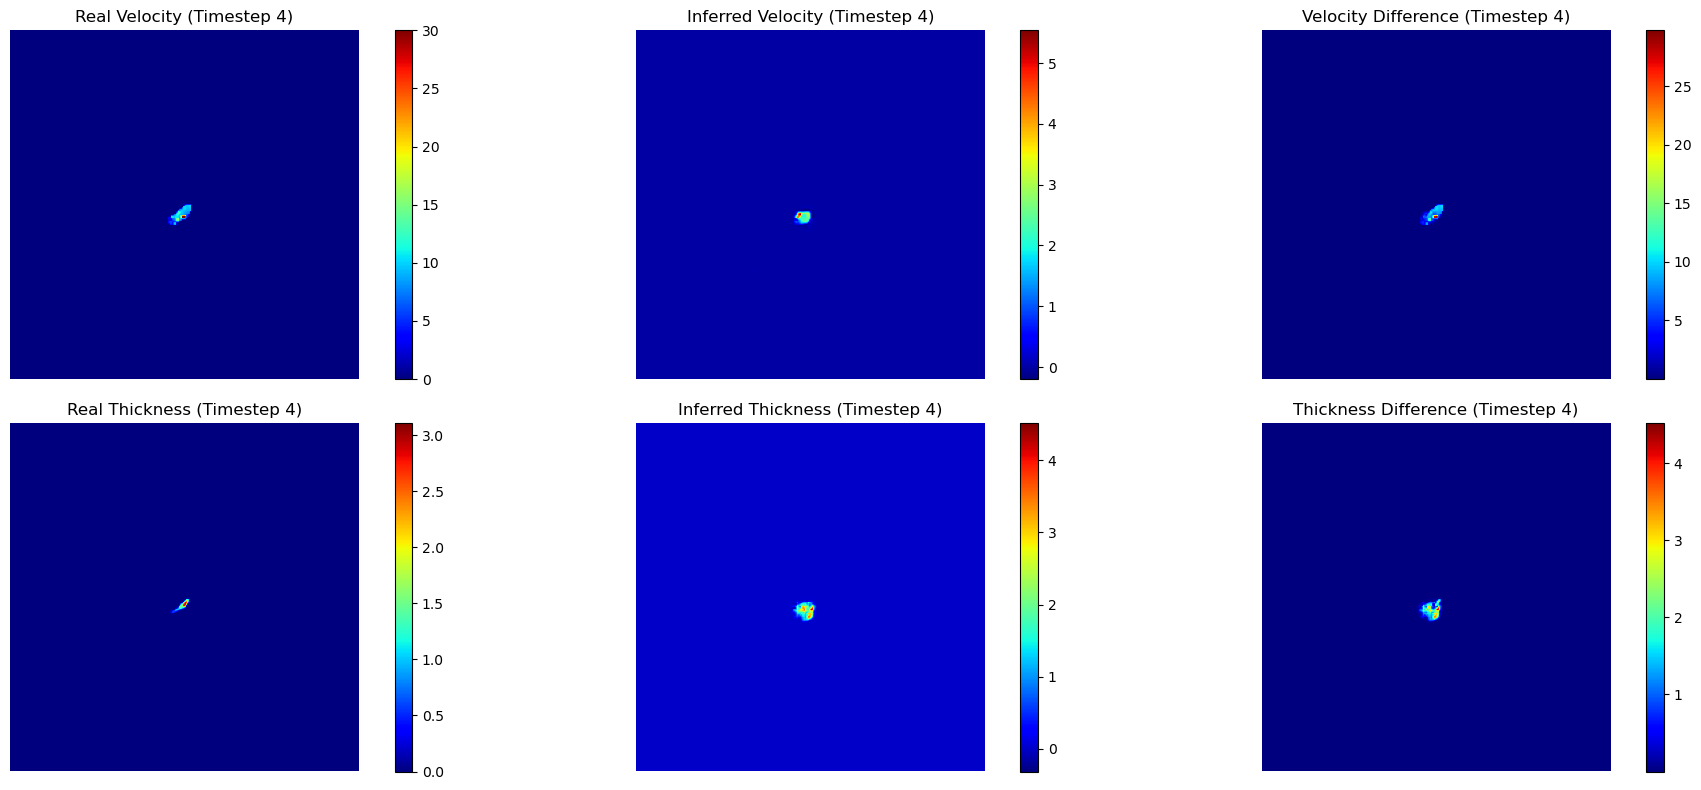

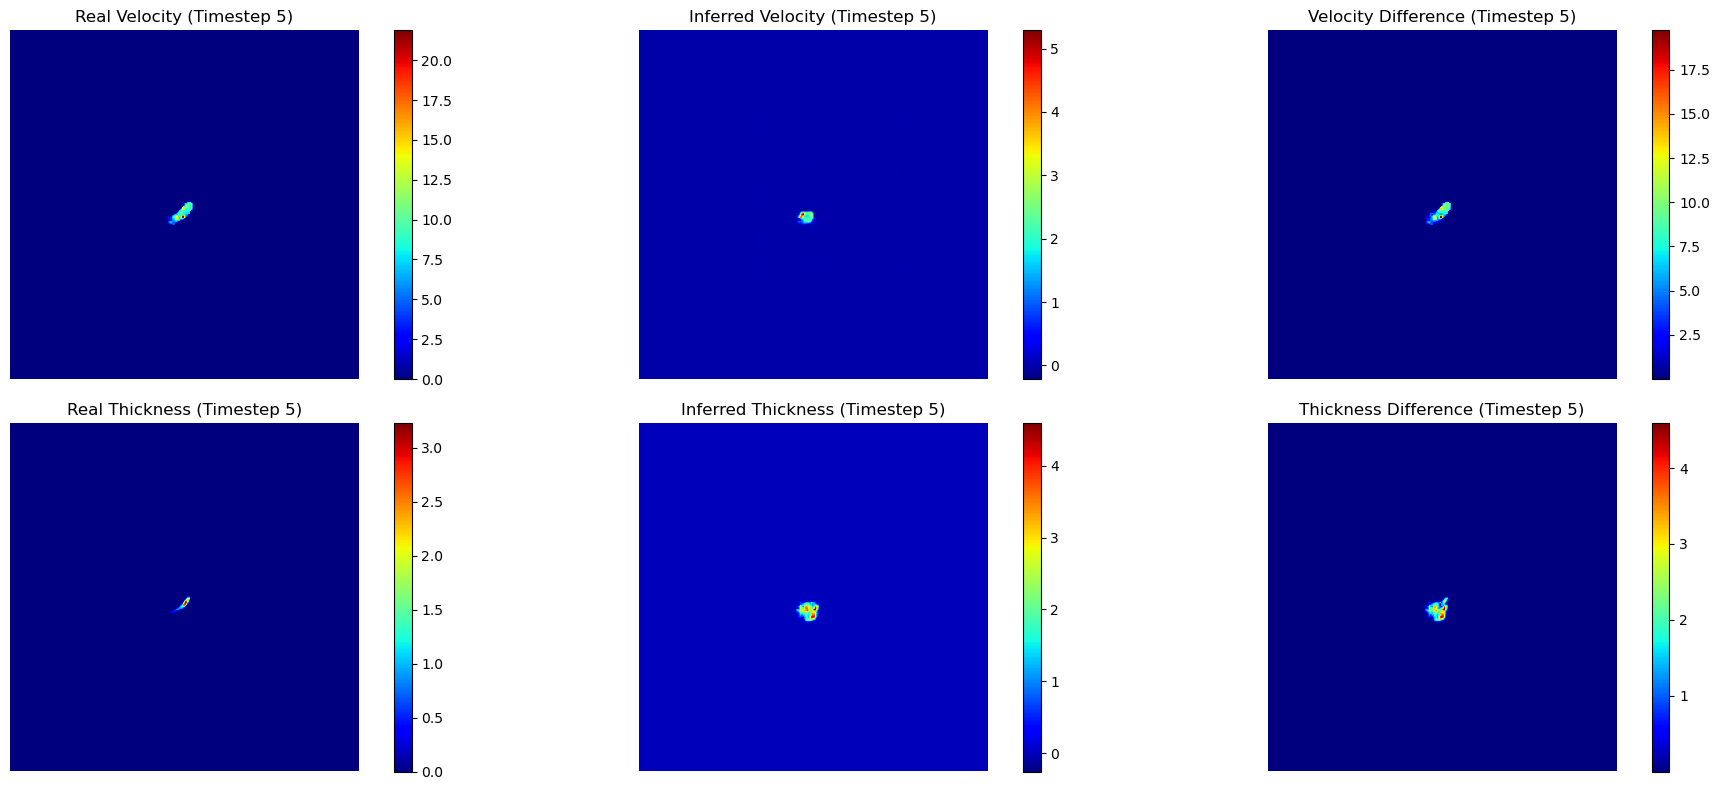

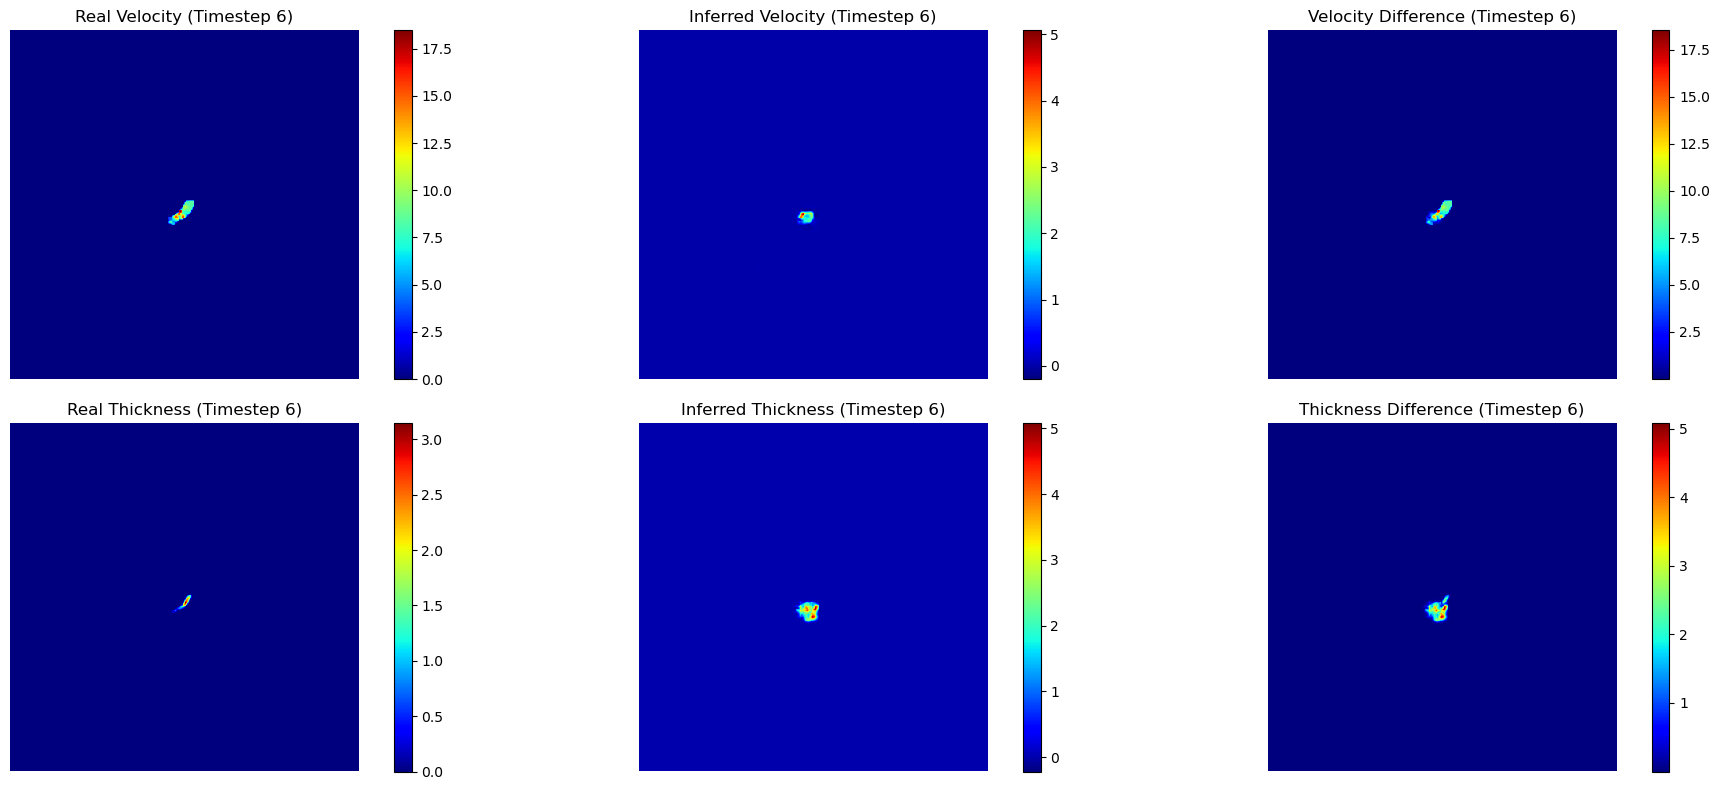

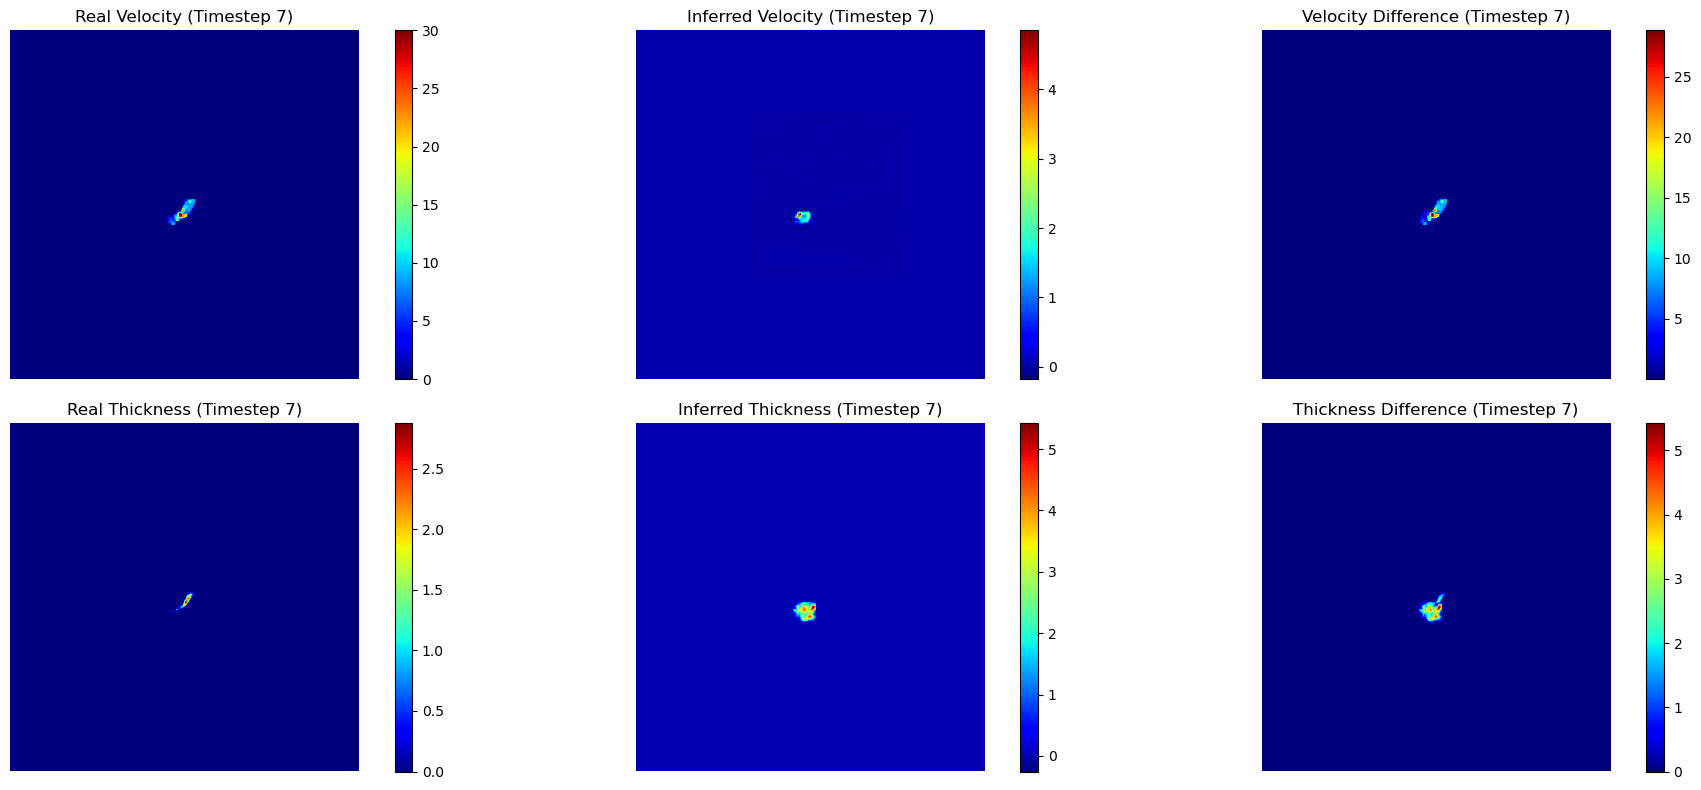

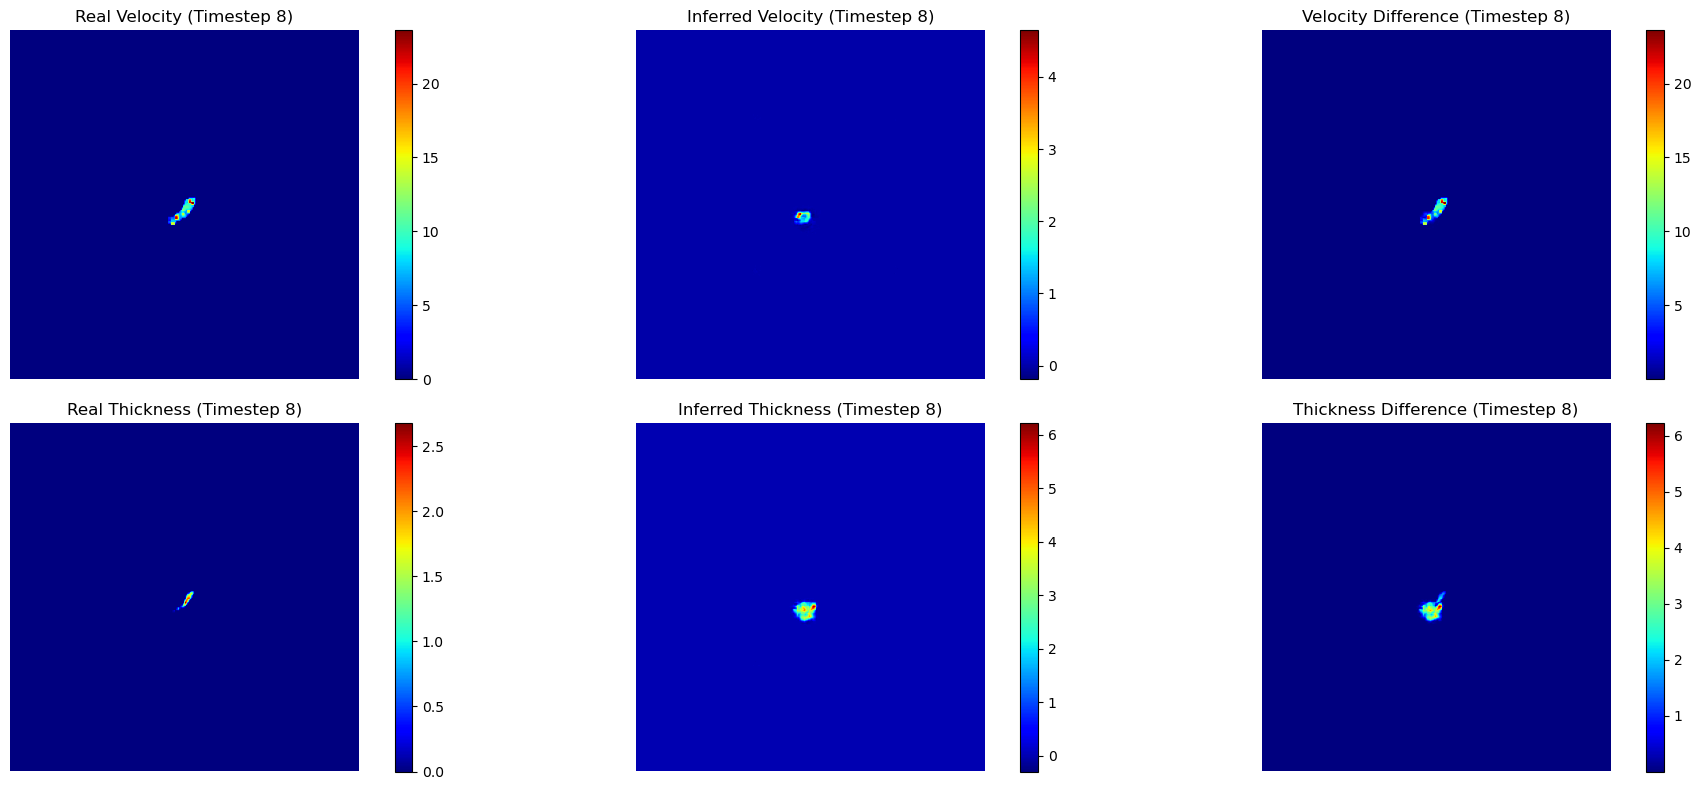

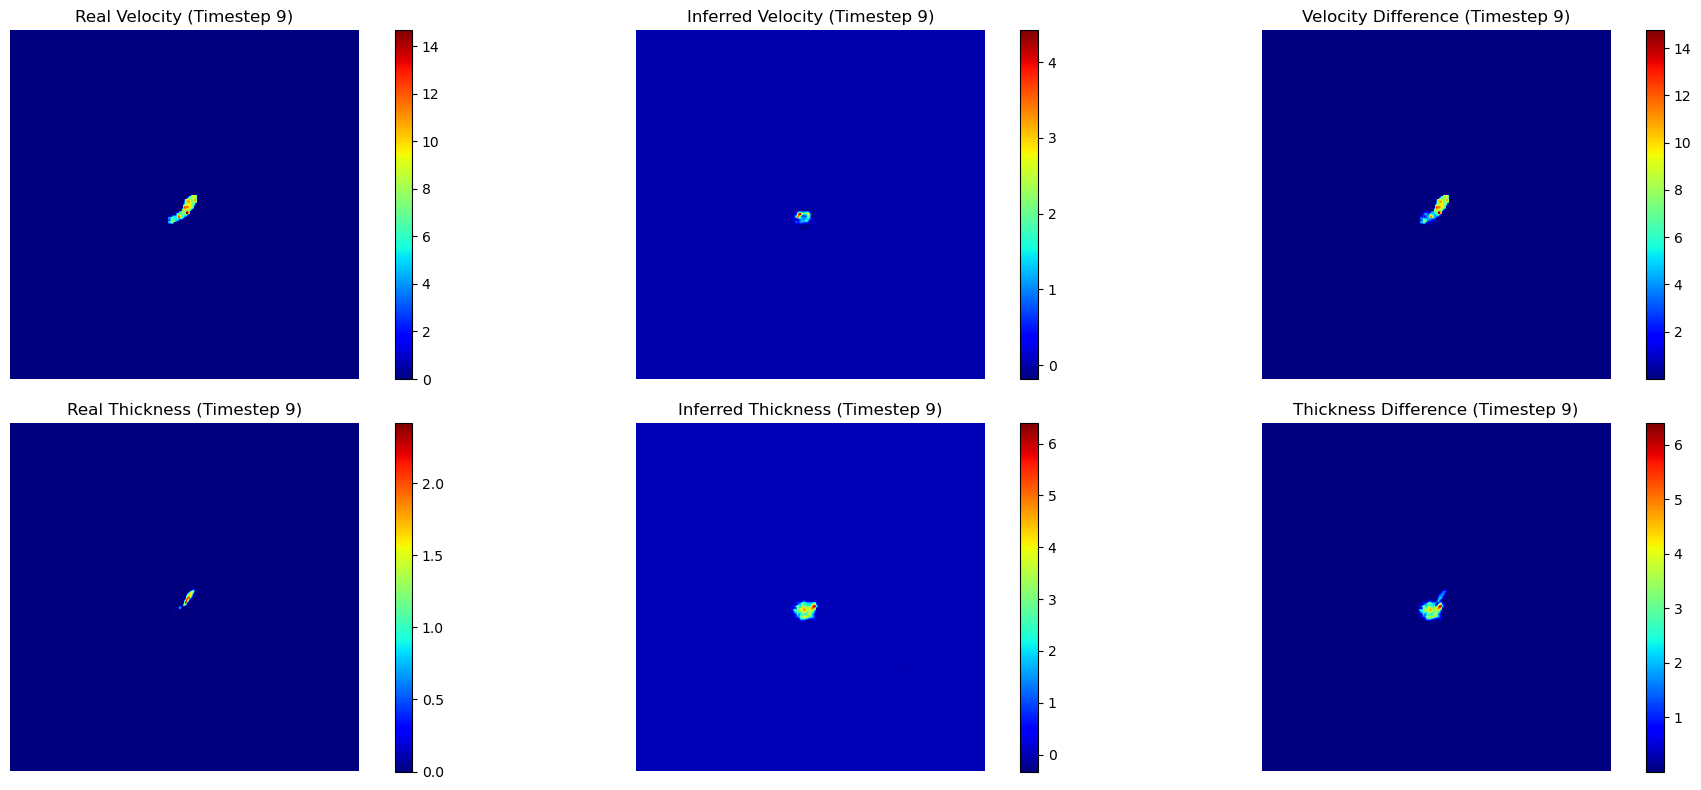

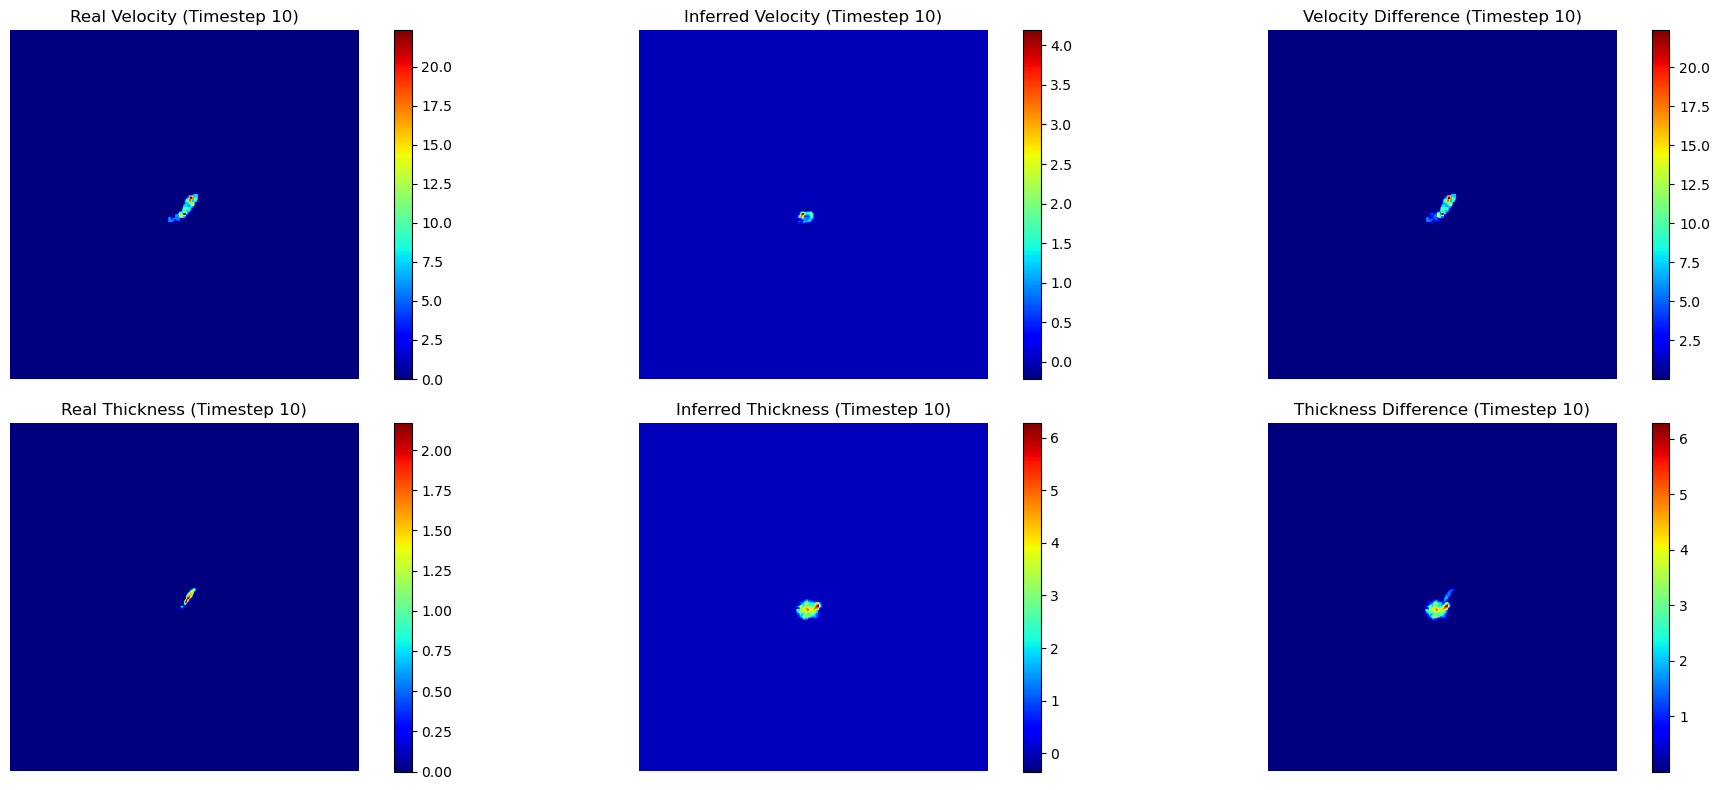

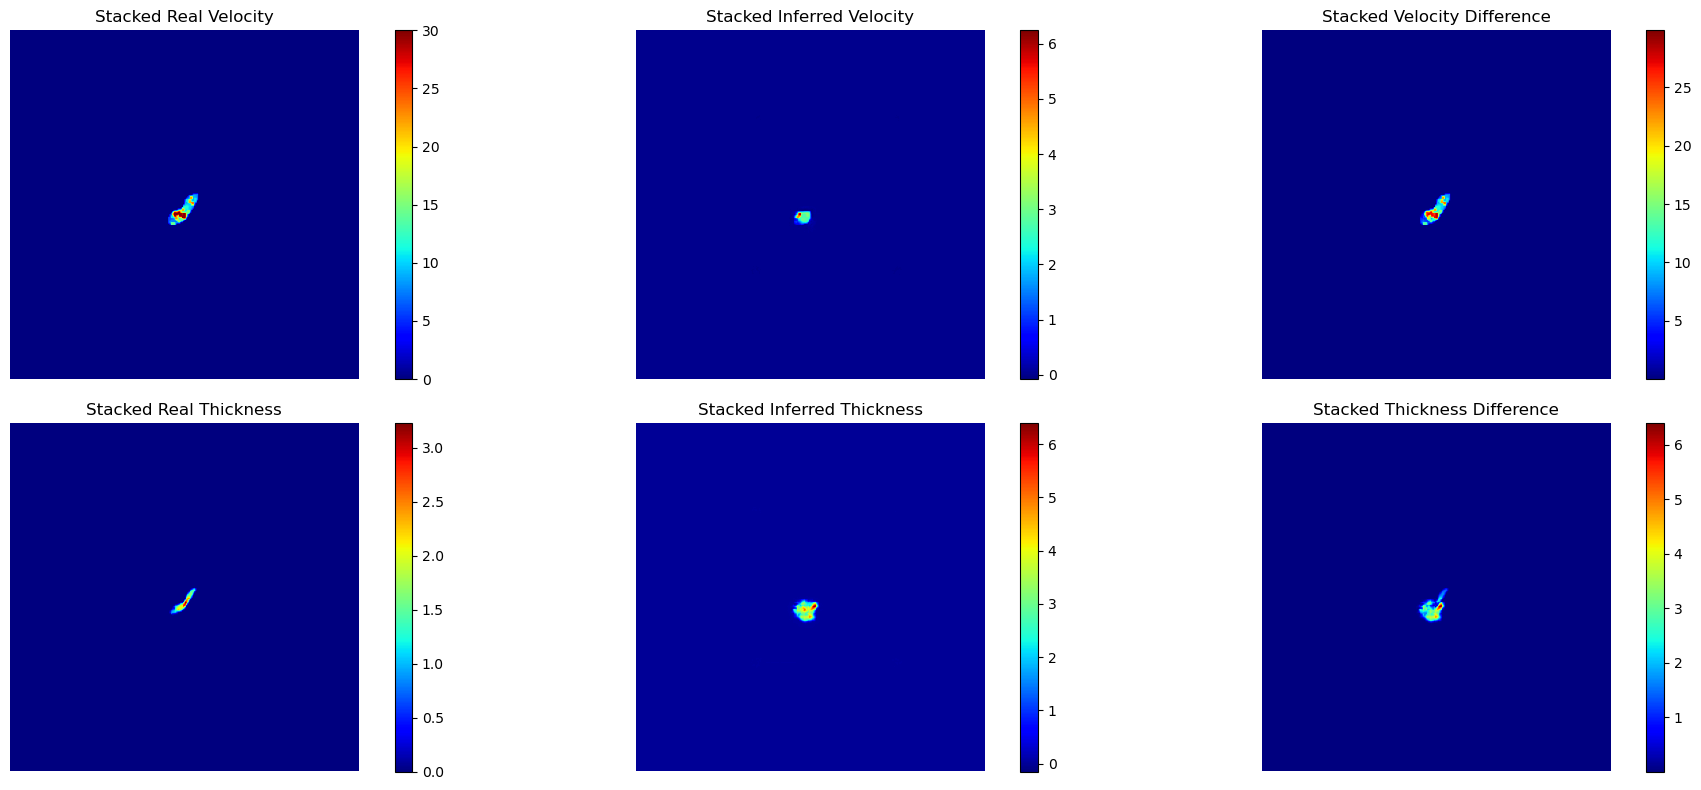

In [ ]:
# Create the initial input
initial_input = small_unet_trainer.create_inference_input(root_dir, '00378', 10, 256)

# Perform inference
num_timesteps = 10
inferred_states = small_unet_trainer.infer(initial_input, num_timesteps)

# Create the real states dictionary
real_states = create_real_states_dict(root_dir, '00378', 10+1, num_timesteps, 256)

# Plot real vs inferred states
plot_real_vs_inferred(real_states, inferred_states, n=1)

In [ ]:
inferred_states

{1: array([[[ 1.8256903e-04,  2.6292354e-04,  1.4197826e-03, ...,
           6.4626336e-05,  8.4191561e-04,  1.0331720e-04],
         [-3.7355870e-03, -2.3497790e-03, -7.3501468e-04, ...,
          -1.2446195e-04,  1.5395880e-04, -9.7028166e-03],
         [ 1.7634034e-04, -1.7147511e-04, -4.7219545e-04, ...,
           4.3599308e-04,  1.4803633e-03,  8.7282807e-04],
         ...,
         [ 2.4374574e-04,  5.3809583e-04, -3.0415989e-03, ...,
           1.7191768e-03,  1.6987324e-04,  2.3000687e-04],
         [ 2.6076287e-04, -5.7139993e-04, -1.0075793e-03, ...,
          -1.4428794e-04,  3.4539402e-04,  4.1784421e-03],
         [ 3.4748018e-04,  9.3619525e-04,  3.7027150e-04, ...,
           2.1416694e-04, -1.0189340e-03,  3.7090257e-03]],
 
        [[ 4.2669848e-03, -1.6577542e-04, -4.4919252e-03, ...,
           1.2249276e-03,  1.4321506e-04, -1.6666949e-04],
         [-3.3375621e-04, -8.8936836e-04,  1.9581169e-03, ...,
          -1.0423139e-03, -6.4488947e-03,  1.3906509e-04],
    

In [ ]:
inferred_states[1].shape

(2, 256, 256)

In [ ]:
for key, array in inferred_states.items():
    min_value = np.min(array)
    max_value = np.max(array)
    print(f"Min and max values for {key}: ({min_value}, {max_value})")

Min and max values for 1: (-0.19579237699508667, 6.244314670562744)
Min and max values for 2: (-0.3159176707267761, 6.0468268394470215)
Min and max values for 3: (-0.3358699679374695, 5.805762767791748)
Min and max values for 4: (-0.31522172689437866, 5.540675163269043)
Min and max values for 5: (-0.2568701207637787, 5.286859512329102)
Min and max values for 6: (-0.2164260596036911, 5.084585666656494)
Min and max values for 7: (-0.25282496213912964, 5.426994800567627)
Min and max values for 8: (-0.29647383093833923, 6.226446151733398)
Min and max values for 9: (-0.3279780149459839, 6.402379989624023)
Min and max values for 10: (-0.3492047190666199, 6.285695552825928)


Elevation shape initial: torch.Size([1, 256, 256])
Elevation shape adjusted: torch.Size([1, 1, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Input tensor shape: torch.Size([1, 3, 256, 256])
Model output shape: torch.Size([1, 2, 256, 256])
Output with elev

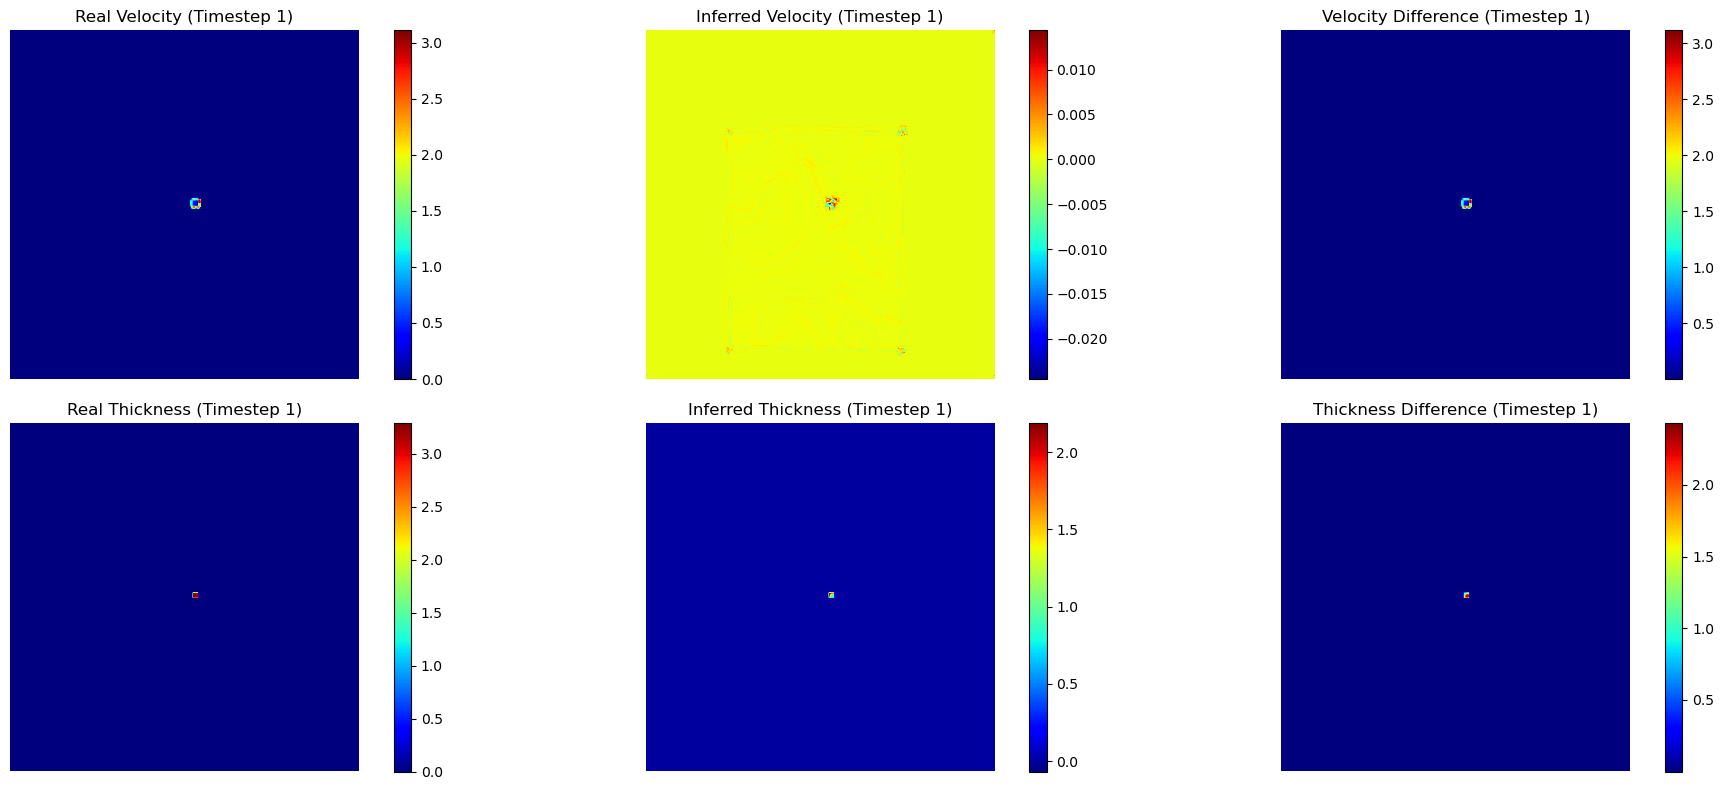

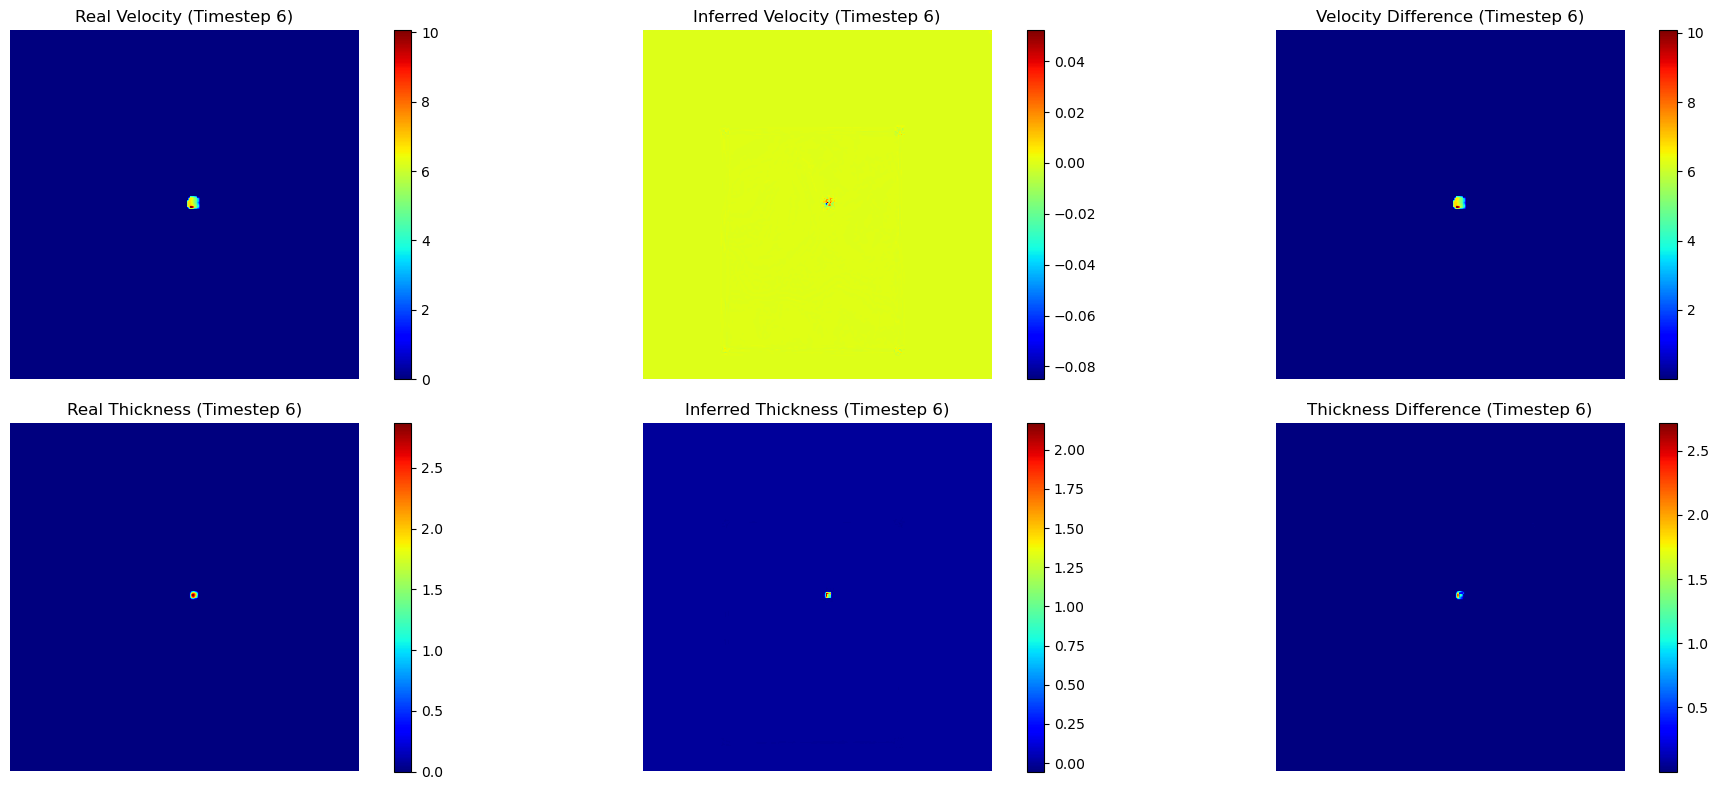

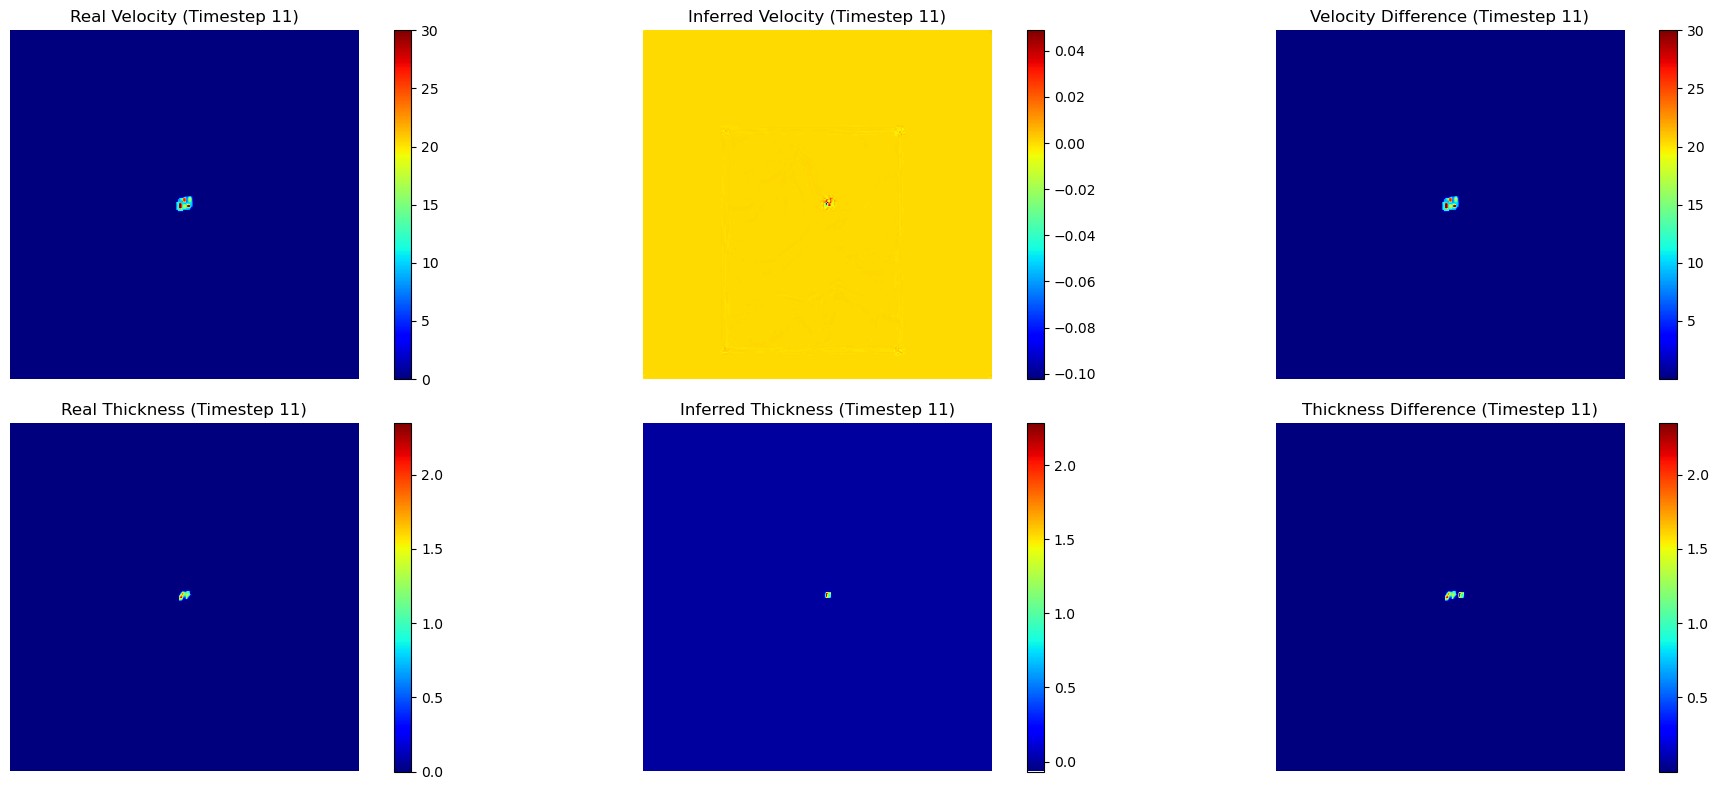

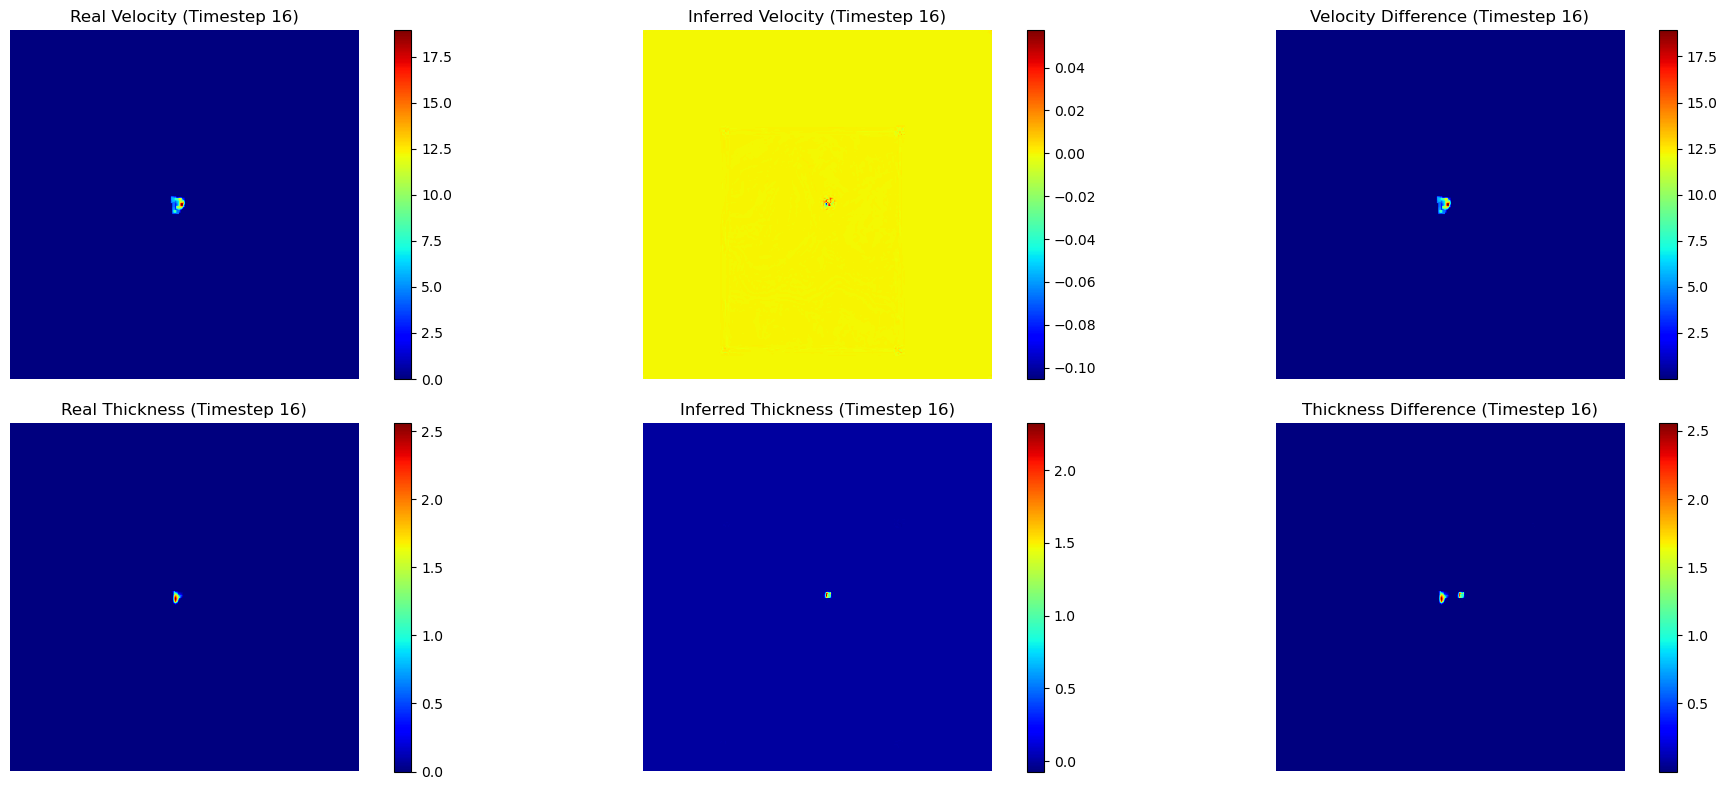

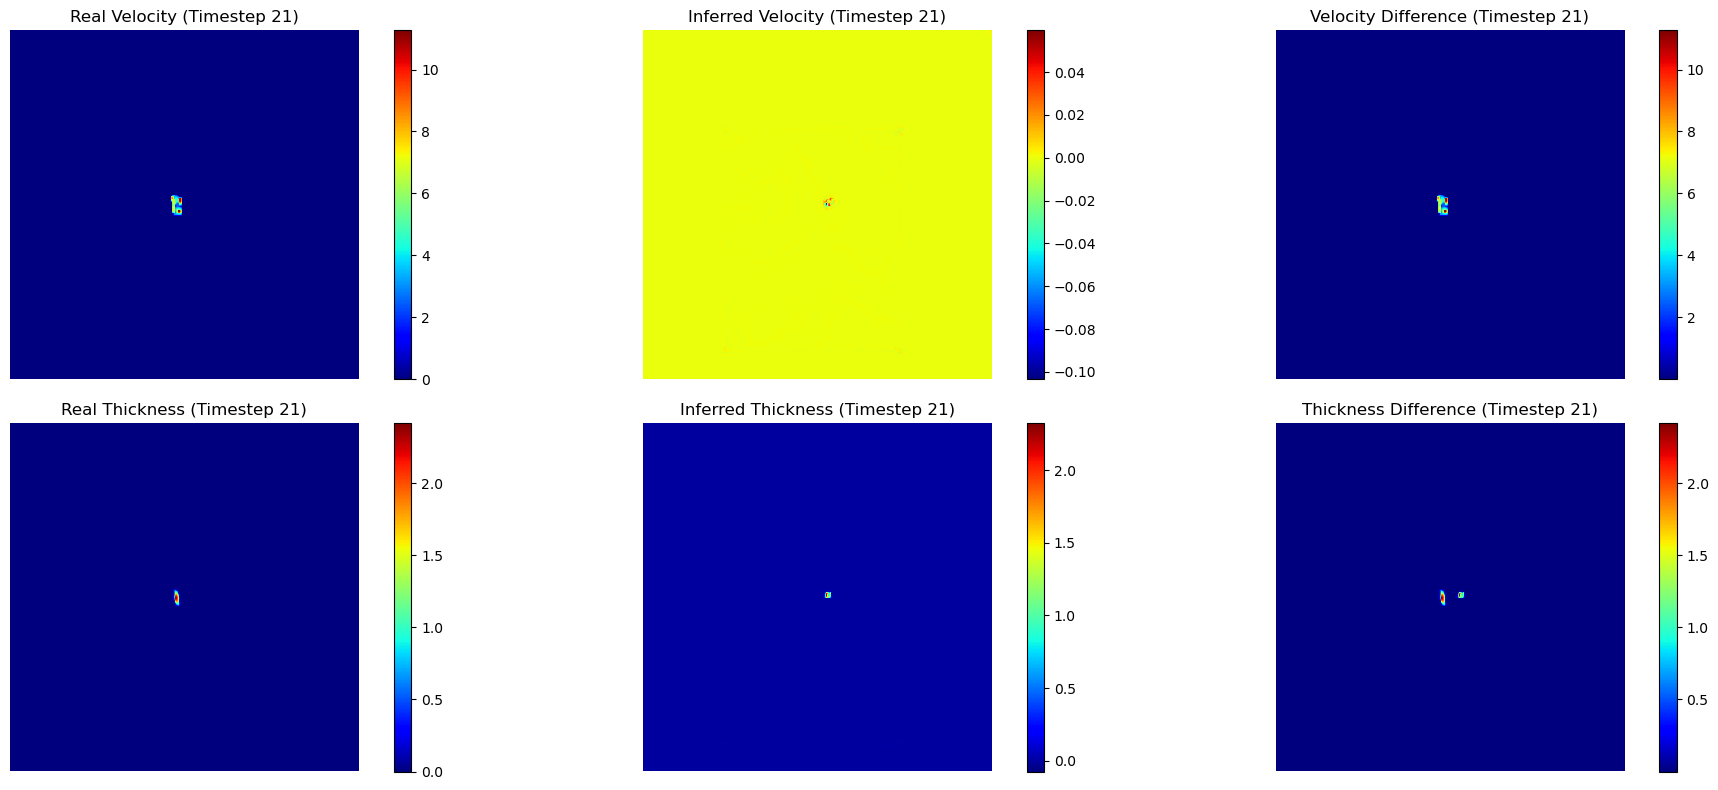

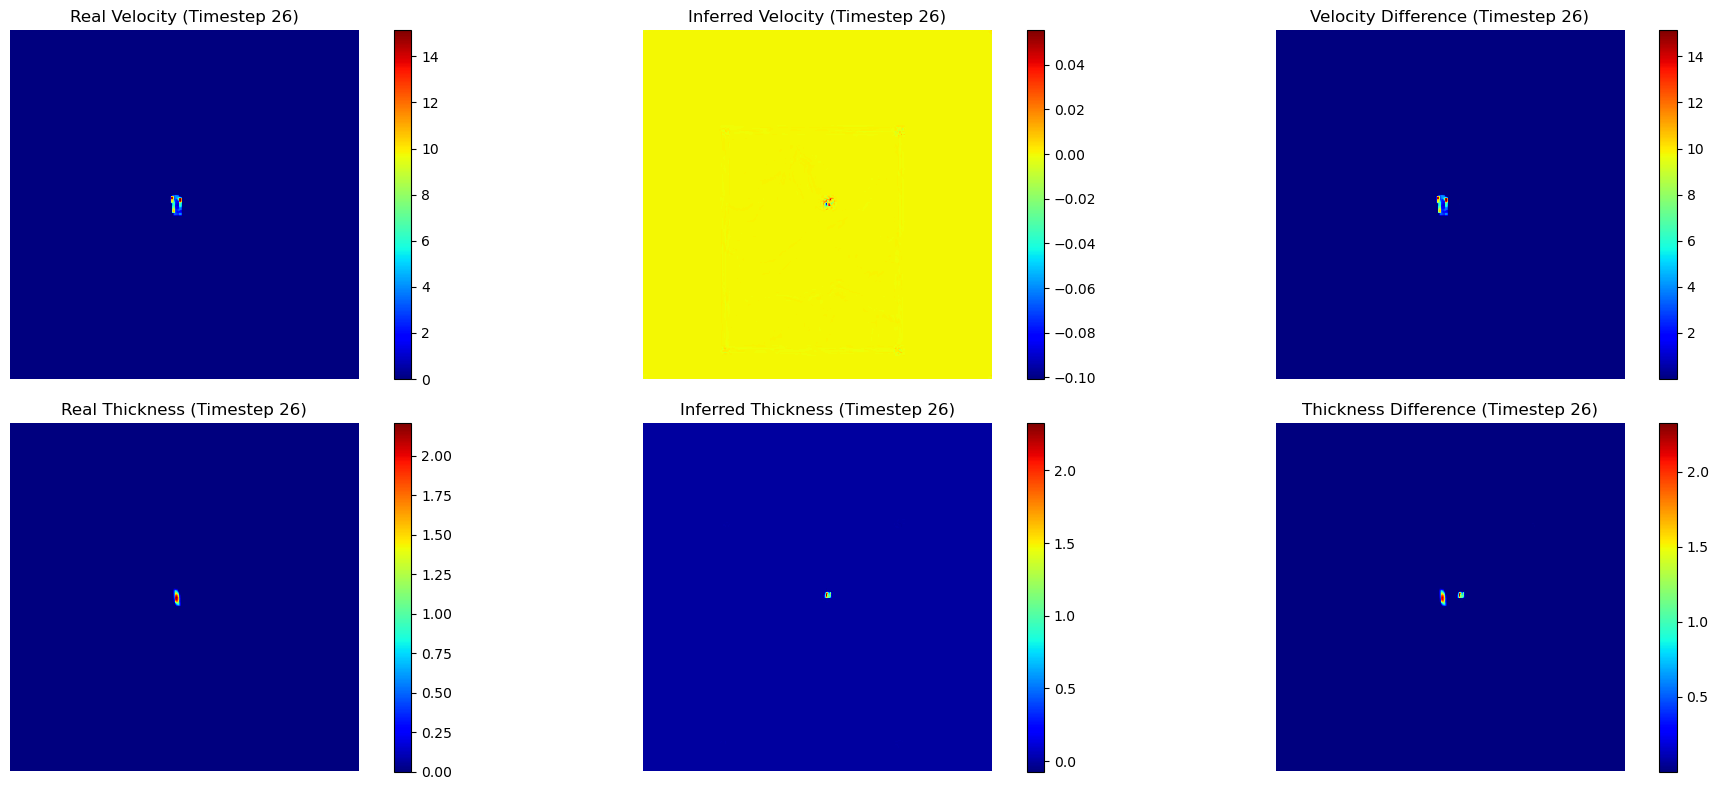

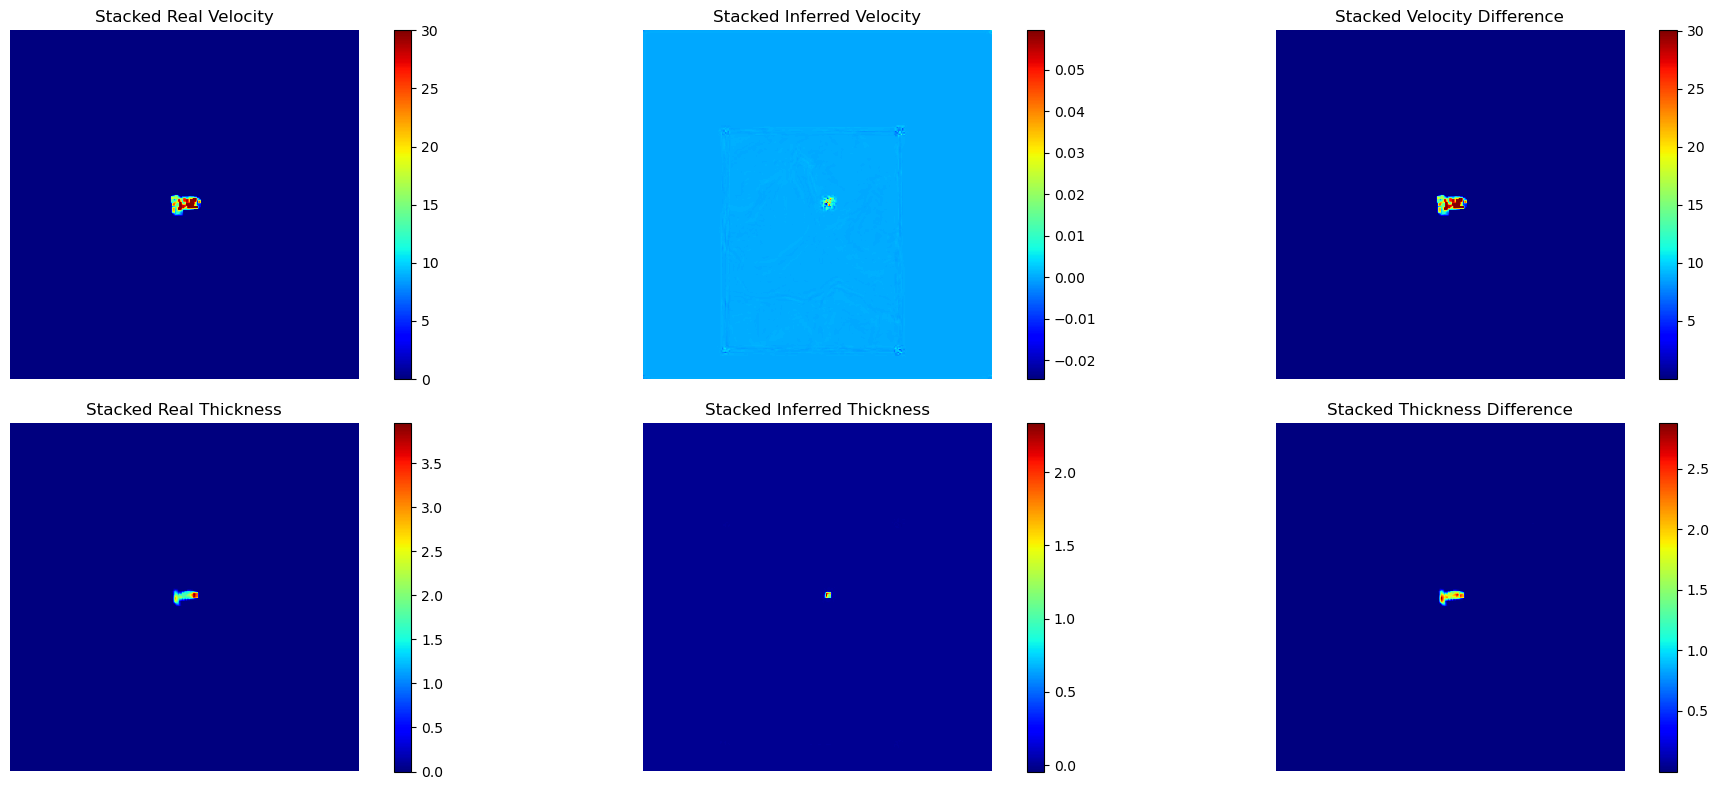

In [ ]:


# Create the initial input
initial_input = med_unet_trainer.create_inference_input(root_dir, '00204', 2, 256)

# Perform inference
num_timesteps = 30
inferred_states = med_unet_trainer.infer(initial_input, num_timesteps)

# Create the real states dictionary
real_states = create_real_states_dict(root_dir, '00204', 2 + 1, num_timesteps, 256)

# Plot real vs inferred states
plot_real_vs_inferred(real_states, inferred_states, n=5)